In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm  
import pomegranate

from python_speech_features import mfcc

from sklearn.externals import joblib

import hmm_model_feature_extraction

import random

import matplotlib.pyplot as plt

from tqdm import tqdm

from ast import literal_eval

from google.cloud import storage

gcp = False

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
if gcp == True:
    
    import gcsfs
    import pickle
    import cupy
    
    mixed_dir = "gs://ad-bucket-15730/mixed_20k"
    hmm_model_dir = "gs://ad-bucket-15730/hmm_models"
    fs = gcsfs.GCSFileSystem(project = 'audio-detection-1')
    pomegranate.utils.enable_gpu()
    print(pomegranate.utils.is_gpu_enabled())
    
    # moving pre-populated validation list for faster model validation
    bucket_name = "ad-bucket-15730"
    validation_dir = "gs://{}/validation".format(bucket_name)
    
    # need to create folder on vm instance
    if "validation" not in os.listdir():
        
        os.mkdir("validation")
        
    # ten arbitrarily chosen    
    if len(os.listdir("validation")) < 10:
        
        os.system("gsutil -m cp {}/* ./validation".format(validation_dir))
        
else:
    
    mixed_dir = "../../../mixed"
    hmm_model_dir = "../../../hmm_models"

In [18]:
# name this particular trial
trial_name = "gpu_test_2_multi-dim_multi-state_20-iter"

# initialize feature extraction class
fe = hmm_model_feature_extraction.feature_extraction(mixed_dir="../../../mixed/", sampling_freq = 20000, gcp = False)

# load in mixed_metadata
metadata = pd.read_csv(mixed_dir + "/mixed_metadata.csv")

# determine the number of iterations for each HMM
num_iterations = 50

# number of cepstral coefficients to return from mfcc (13 is default)
num_cep_coefs = 13

# whether we will feed concatenated, 2-dimensional cepstral coefficients for each track as a sample
multidimensional_input = True

# whether to use the pomegranate package for fitting hmm
use_pomegranate = True

# what distribution to use for the states 
distribution = pomegranate.MultivariateGaussianDistribution



In [35]:
# re-configuring metadata df if we're using on the cloud given the set-aside validation set:

validation_samples = os.listdir("../../../validation")
validation_df = metadata[metadata['slice_file_name'].isin(validation_samples)]
validation_samples = [(validation_df['slice_file_name'].iloc[i], validation_df['class'].iloc[i]) for i in range(len(validation_df))]
metadata = metadata[~metadata['slice_file_name'].isin(validation_samples)]

In [20]:
# choose hidden states per self-organizing maps

label_states = pd.Series({"air_conditioner":20, "car_horn":18, "children_playing":11,
             "dog_bark":17, "drilling":20, "engine_idling":20,
             "gun_shot":9, "jackhammer":18, "siren":17,
             "street_music":17})

881


Text(0.5, 1.05, 'MFCC')

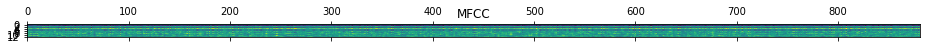

In [21]:
# test data intake

time_signal = fe.read("100852-0-0-13.wav")
mfccs = fe.return_mfcc(time_signal, nfft=1200)
print(mfccs.shape[0])
plt.matshow(mfccs.T)
plt.title('MFCC')

In [22]:
### Define a class to train the HMM ###

# Parameters of `hmm.GaussianHMM()`:
# `n_components`: number of states of HMM
# `covariance_type`: type of covariance matrix for each state. 
# Each state is a random vector. 
# This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

class HMM_Model(object):
    
    def __init__(self, num_components=12, 
                 num_iter=100,
                use_pomegranate=True,
                distribution=pomegranate.NormalDistribution,
                gpu=False):
        
        self.n_components = num_components
        self.n_iter = num_iter
        self.use_pomegranate = use_pomegranate
        self.distribution = distribution
        
        # define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
        
        # initialize the variable in which we will store the models for each word:
        self.models = []
        
        # define the model using the specified parameters:
        if not self.use_pomegranate:

            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                     covariance_type=self.cov_type,
                                     n_iter=self.n_iter, verbose=True)
        
        # we anble pomegranate's gpu utility if gpu is set to true 
        self.gpu = gpu
        if self.gpu==True:
            
            pomegranate.utils.enable_gpu()
            print("pomegranate_gpu is enabled: ", pomegranate.utils.is_gpu_enabled())
            

    def train(self, training_data, multidimensional_input):
        
        """
        Defines a method to train the model
        'training_data' is a 2D numpy array where each row has the 
        length of number of mfcc coefficients
        """
        # for default case using pomegranate package        
        if self.use_pomegranate:
            
            # training on multidimensional input (i.e. n_samples x n_windows x n_cepstral_coefs)
            if multidimensional_input:
                
                print("training on multidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter, 
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=-1, 
                                                                    verbose=True)
            
            # training on unidimensional input (i.e. one cepstral grid per track)
            else:
                
                print("training on unidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter, 
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=-1, 
                                                                    verbose=True)
                
                
            self.models.append(self.model)
        
        # for alternative case using hmmlearn
        else:
            
            print("training on unidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
            np.seterr(all='ignore')
            cur_model = self.model.fit(training_data)
            self.models.append(cur_model)

    
    def compute_score(self, input_data):
        
        """
        Define a method to compute log likelihood score for input features
        Returns: Log likelihood of sample input_data
        """
        if self.use_pomegranate:
            print("scoring input of shape ", input_data.shape, " using pomegranate")
            return self.model.log_probability(input_data)
            
        else:
            print("scoring input of shape ", input_data.shape, " hmmlearn")
            return self.model.score(input_data)

In [23]:
def build_one_model(features_vector, num_states, num_iterations, multidimensional_input, use_pomegranate, distribution, gpu):
    
    """
    features_vector: nparray of features from Class above
    num_states: number of hidden states in HMM
    """
    
    # initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = HMM_Model(num_components=num_states, num_iter=num_iterations, 
                          use_pomegranate=use_pomegranate, distribution=distribution, gpu=gpu)

    # train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(features_vector, multidimensional_input)
        model_score = model.compute_score(features_vector)
        
    return model, model_score

In [24]:
def hmm_aic(LLik, n, k):
    
    """
    Takes in loglikelihood of trained HMM plus number of params
    Returns: Model AIC
    """
    return -2*LLik+2*(n*n+k*n-1)

In [25]:
def build_all_models(label_name, metadata, num_states, num_iterations, training_prop = 0.7, \
                     multidimensional_input=False, use_pomegranate=True, \
                     distribution = pomegranate.NormalDistribution, gpu=False):
    
    """
    Given an input data folder with subfolders for each response label
    """
    
    # empty list for storing model results
    model_results = []
    validation_set = []
    

    # load in filenames relevant to a particular label
    label_file_names = metadata[metadata['class'] == label_name]['slice_file_name'].tolist()
    # reserve 30 percent for validation
    num_to_train = int(np.ceil(len(label_file_names) * training_prop)) # may need to reduce for pomegranate training
    train = random.sample(label_file_names, num_to_train)
    print(label_name,"train length:", len(train))
    validate = list(set(label_file_names) - set(train))
    print(label_name," validation length:", len(validate))
    # append the list of validation filenames and respective label to validation_set
    validation_set.append((validate, label_name))
    
    # for unidimensional inputs
    if multidimensional_input == False:
    
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)

        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)

            if len(X) == 0:
                
                X = mfcc_features
            
            else:
                
                X = np.append(X, mfcc_features, axis=0)
            
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # reset model variable
        model = None

        return model_results, validation_set
    
    # for multidimensional inputs
    else:
        
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)
        
        # need to count the number of samples not discarded
        counter = 0
        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)
            
            # need to have all mfcc features the same 
            if mfcc_features.shape[0] == 399: # this number likely not robust to other sampling rates

                if len(X) == 0:
                
                    X = mfcc_features
                    counter += 1
            
                else:
                
                    X = np.append(X, mfcc_features, axis=0)
                    counter += 1
                    
            else:
                
                pass
        
        # (n_samples x n_windows x n_cepstral_coefs)
        X = X.reshape(counter, 399, num_cep_coefs) # this number likely not robust to other sampling rates
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # Reset model variable
        model = None

        return model_results, validation_set
                
                
        
        
        


In [28]:
"""
Initiate Training
"""

# empty list to which to append fitted hmms and validation sets

models, validation_sample = [],[]

# loop through each of the labels
for i in range(len(label_states.index)):
    
    # extract the label name
    label_name = label_states.index[i]
    # extract corresponding chosen number of states
    num_states = label_states[label_states.index[i]]
    
    # send through model build functions
    ### we make training_prop = 1 when on the cloud ###
    model_results, validation_set = build_all_models(label_name, metadata, num_states, num_iterations, \
                                                     training_prop = 1, \
                                                     multidimensional_input = multidimensional_input, \
                                                     use_pomegranate = use_pomegranate, \
                                                     distribution = distribution, \
                                                    gpu=True)
    models.append(model_results)
    validation_sample.append(validation_set)
    

  0%|          | 0/2384 [00:00<?, ?it/s]

air_conditioner train length: 2384
air_conditioner  validation length: 0
loading in files for label:  air_conditioner


100%|██████████| 2384/2384 [05:39<00:00,  7.02it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (2376, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001678
Total Training Improvement: 0.0
Total Training Time (s): 0.0543
scoring input of shape  (2376, 399, 13)  using pomegranate


  0%|          | 0/1050 [00:00<?, ?it/s]

car_horn train length: 1050
car_horn  validation length: 0
loading in files for label:  car_horn


100%|██████████| 1050/1050 [02:00<00:00,  8.74it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 18 states, 50 iterations, and sample shape (502, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001681
Total Training Improvement: 0.0
Total Training Time (s): 0.0054
scoring input of shape  (502, 399, 13)  using pomegranate


  0%|          | 1/2381 [00:00<04:06,  9.67it/s]

children_playing train length: 2381
children_playing  validation length: 0
loading in files for label:  children_playing


100%|██████████| 2381/2381 [05:33<00:00,  7.14it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 11 states, 50 iterations, and sample shape (2299, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001464
Total Training Improvement: 0.0
Total Training Time (s): 0.0354
scoring input of shape  (2299, 399, 13)  using pomegranate


  0%|          | 0/2436 [00:00<?, ?it/s]

dog_bark train length: 2436
dog_bark  validation length: 0
loading in files for label:  dog_bark


100%|██████████| 2436/2436 [05:01<00:00,  8.09it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (1645, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001581
Total Training Improvement: 0.0
Total Training Time (s): 0.0318
scoring input of shape  (1645, 399, 13)  using pomegranate


  0%|          | 1/2386 [00:00<06:19,  6.28it/s]

drilling train length: 2386
drilling  validation length: 0
loading in files for label:  drilling


100%|██████████| 2386/2386 [05:06<00:00,  7.78it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (1918, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001478
Total Training Improvement: 0.0
Total Training Time (s): 0.0364
scoring input of shape  (1918, 399, 13)  using pomegranate


  0%|          | 1/2389 [00:00<06:49,  5.83it/s]

engine_idling train length: 2389
engine_idling  validation length: 0
loading in files for label:  engine_idling


100%|██████████| 2389/2389 [05:27<00:00,  7.29it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (2296, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001838
Total Training Improvement: 0.0
Total Training Time (s): 0.0561
scoring input of shape  (2296, 399, 13)  using pomegranate


  0%|          | 1/878 [00:00<01:36,  9.05it/s]

gun_shot train length: 878
gun_shot  validation length: 0
loading in files for label:  gun_shot


  0%|          | 0/2408 [00:00<?, ?it/s]

pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 9 states, 50 iterations, and sample shape (41, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0003097
Total Training Improvement: 0.0
Total Training Time (s): 0.0027
scoring input of shape  (41, 399, 13)  using pomegranate
jackhammer train length: 2408
jackhammer  validation length: 0
loading in files for label:  jackhammer


100%|██████████| 2408/2408 [05:12<00:00,  7.70it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 18 states, 50 iterations, and sample shape (1951, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001945
Total Training Improvement: 0.0
Total Training Time (s): 0.0434
scoring input of shape  (1951, 399, 13)  using pomegranate


  0%|          | 0/2209 [00:00<?, ?it/s]

siren train length: 2209
siren  validation length: 0
loading in files for label:  siren


100%|██████████| 2209/2209 [04:59<00:00,  7.38it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (2133, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001616
Total Training Improvement: 0.0
Total Training Time (s): 0.0408
scoring input of shape  (2133, 399, 13)  using pomegranate


  0%|          | 1/2436 [00:00<05:34,  7.27it/s]

street_music train length: 2436
street_music  validation length: 0
loading in files for label:  street_music


100%|██████████| 2436/2436 [05:44<00:00,  7.07it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (2436, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001736
Total Training Improvement: 0.0
Total Training Time (s): 0.0593
scoring input of shape  (2436, 399, 13)  using pomegranate


In [30]:
models

[[((<__main__.HMM_Model at 0x7f6a80610cf8>, -105492.75657460364),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x7f6a80610940>, -22037.906184785454), 'car_horn')],
 [((<__main__.HMM_Model at 0x7f6a80e1a9e8>, -97672.523136716),
   'children_playing')],
 [((<__main__.HMM_Model at 0x7f6a8061b630>, -73561.26404492122), 'dog_bark')],
 [((<__main__.HMM_Model at 0x7f6a805fd438>, -84669.94979091972), 'drilling')],
 [((<__main__.HMM_Model at 0x7f6a8048fe10>, -96174.10823416575),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x7f6a80419080>, -1669.9264783365345), 'gun_shot')],
 [((<__main__.HMM_Model at 0x7f6a80474ac8>, -81018.41662892162),
   'jackhammer')],
 [((<__main__.HMM_Model at 0x7f6a80615eb8>, -95453.03698144322), 'siren')],
 [((<__main__.HMM_Model at 0x7f6a803cb160>, -107079.75395971509),
   'street_music')]]

In [44]:
# format validation_sample outputs for validation

if gcp == False:
    
    validation_samples = [(validation_sample[0][0][0][i],validation_sample[0][0][1]) for i in range(len(validation_sample[0][0][0]))] + \
[(validation_sample[1][0][0][i],validation_sample[1][0][1]) for i in range(len(validation_sample[1][0][0]))] + \
[(validation_sample[2][0][0][i],validation_sample[2][0][1]) for i in range(len(validation_sample[2][0][0]))] + \
[(validation_sample[3][0][0][i],validation_sample[3][0][1]) for i in range(len(validation_sample[3][0][0]))] + \
[(validation_sample[4][0][0][i],validation_sample[4][0][1]) for i in range(len(validation_sample[4][0][0]))] + \
[(validation_sample[5][0][0][i],validation_sample[5][0][1]) for i in range(len(validation_sample[5][0][0]))] + \
[(validation_sample[6][0][0][i],validation_sample[6][0][1]) for i in range(len(validation_sample[6][0][0]))] + \
[(validation_sample[7][0][0][i],validation_sample[7][0][1]) for i in range(len(validation_sample[7][0][0]))] + \
[(validation_sample[8][0][0][i],validation_sample[8][0][1]) for i in range(len(validation_sample[8][0][0]))] + \
[(validation_sample[9][0][0][i],validation_sample[9][0][1]) for i in range(len(validation_sample[9][0][0]))]

In [28]:
# convert to validation_samples to txt

if gcp == True:
    
    with fs.open('ad-bucket-15730/hmm_models/validation_samples_{}.txt'.format(trial_name),'w') as file:
        for ele in validation_samples:
            file.write(str(ele) + "\n")
    
    file.close()
    
else:
    
    with open(hmm_model_dir + 'validation_samples_{}.txt'.format(trial_name),'w') as file:
        for ele in validation_samples:
            file.write(str(ele)+'\n')
    
    file.close()

In [19]:
### in case you stop before validation ####

"""
f = fs.open('ad-bucket-15730/hmm_models/validation_samples_{}.txt'.format(trial_name),'r')
validation_samples = f.readlines()
f.close()
validation_samples = [literal_eval(validation_samples[i]) for i in range(len(validation_samples))]

"""

In [45]:
# model save to pkl

if gcp == True:

    with fs.open('ad-bucket-15730/hmm_models/model_{}.pkl'.format(trial_name), 'wb') as file:
        pickle.dump(models, file)
        
else:
    
    joblib.dump(models,hmm_model_dir+'/model{}.pkl'.format(trial_name))
    

In [26]:
# load model from pkl

if gcp == True:
    
    with fs.open('ad-bucket-15730/hmm_models/model_{}.pkl'.format(trial_name), 'rb') as file:
        asdf = pickle.load(file)
        
else:

    trained_models = joblib.load(hmm_model_dir+'/model_{}.pkl'.format(trial_name))

In [28]:
trained_models

[[((<__main__.HMM_Model at 0x1c23a98750>, -105492.75657460364),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x1c23aa9610>, -22037.906184785454), 'car_horn')],
 [((<__main__.HMM_Model at 0x1c23aa9dd0>, -97672.523136716),
   'children_playing')],
 [((<__main__.HMM_Model at 0x108f84e50>, -73561.26404492122), 'dog_bark')],
 [((<__main__.HMM_Model at 0x1c22875a10>, -84669.94979091972), 'drilling')],
 [((<__main__.HMM_Model at 0x1c23aa9f50>, -96174.10823416575),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x1c22895cd0>, -1669.9264783365345), 'gun_shot')],
 [((<__main__.HMM_Model at 0x1c22d3e710>, -81018.41662892162), 'jackhammer')],
 [((<__main__.HMM_Model at 0x1c22d59850>, -95453.03698144322), 'siren')],
 [((<__main__.HMM_Model at 0x1c228ecb50>, -107079.75395971509),
   'street_music')]]

In [18]:
trained_models

[[((<__main__.HMM_Model at 0x1c1eb389d0>, -80102.11350754816),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x1b1d975ed0>, -16931.410792991417), 'car_horn')],
 [((<__main__.HMM_Model at 0x1c1e9623d0>, -87839.82903534864),
   'children_playing')],
 [((<__main__.HMM_Model at 0x1c1e962490>, -60292.65693878569), 'dog_bark')],
 [((<__main__.HMM_Model at 0x1c1eb9aa90>, -71055.81563962506), 'drilling')],
 [((<__main__.HMM_Model at 0x1c1ebf5590>, -78008.93994351785),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x1c1eb9a850>, -1110.9918373460123), 'gun_shot')],
 [((<__main__.HMM_Model at 0x1c1ea04f50>, -63477.56404528492), 'jackhammer')],
 [((<__main__.HMM_Model at 0x1c1ed00d50>, -77886.51982565396), 'siren')],
 [((<__main__.HMM_Model at 0x1c1eb0cc10>, -88849.50451911007),
   'street_music')]]

In [30]:
def score_one_sample(trained_models, test_file_name):
    
    """
    trained_model: ModelHMM object with trained model
    test_file_path: path to wav file
    """
    # empty list to hold all of the scores
    scores = []
    
    # load in file from validation set and convert to mfcc features
    fe = hmm_model_feature_extraction.feature_extraction(mixed_dir="../../../validation/", sampling_freq = 20000, gcp = False)
    loaded = fe.read(test_file_name)
    mfcc_features = fe.return_mfcc(loaded, nfft=1200)
    
    # iterate through each of the trained models
    for i in trained_models:
        
        # compute log likelihood score for using each of the trained models
        sample_score = i[0][0][0].compute_score(mfcc_features)
        scores.append(sample_score)
        
    predicted = scores.index(max(scores))
    print("max score is:", max(scores), "at index:", predicted)
    predicted = trained_models[predicted][0][1]
   
    return predicted

In [37]:
points = 0
validation_list = []

for i in tqdm(range(len(validation_samples))):
    
    print("validation sample size: ", len(validation_samples))
    actual = validation_samples[i][1]
    print("actual:", actual)
    predicted = score_one_sample(trained_models, validation_samples[i][0])
    print("predicted:", predicted)
    validation_list.append((actual,predicted))
    if actual == predicted:
        
        points += 1
        print("scored a point!")
        print(points, "points")

  0%|          | 2/5239 [00:00<04:46, 18.25it/s]

validation sample size:  5239
actual: dog_bark
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
max score is: -1584.6068940490377 at index: 3
predicted: dog_bark
scored a point!
1 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

  0%|          | 6/5239 [00:00<05:25, 16.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19757.97573196079 at index: 3
predicted: dog_bark
scored a point!
4 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20217.41438809054 at index: 3
predicted: dog_bark
scored a point!
5 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

  0%|          | 8/5239 [00:00<05:52, 14.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17105.56967497138 at index: 0
predicted: air_conditioner
scored a point!
7 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

  0%|          | 10/5239 [00:00<06:20, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17076.682688761015 at index: 0
predicted: air_conditioner
scored a point!
9 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17172.868343206224 at index: 0
predicted: air_conditioner
scored a point!
10 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scorin

  0%|          | 12/5239 [00:00<06:32, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17146.930579308075 at index: 0
predicted: air_conditioner
scored a point!
12 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

  0%|          | 16/5239 [00:01<06:55, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19824.216635564328 at index: 2
predicted: children_playing
scored a point!
13 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19736.4394395922 at index: 3
predicted: dog_bark
scored a point!
14 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

  0%|          | 18/5239 [00:01<06:56, 12.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17427.10819061618 at index: 0
predicted: air_conditioner
scored a point!
16 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 20/5239 [00:01<06:57, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17357.643082299524 at index: 0
predicted: air_conditioner
scored a point!
18 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17452.716924697466 at index: 0
predicted: air_conditioner
scored a point!
19 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scori

  0%|          | 22/5239 [00:01<07:02, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17426.893833624323 at index: 0
predicted: air_conditioner
scored a point!
21 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  0%|          | 26/5239 [00:02<06:58, 12.46it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17364.48822536548 at index: 0
predicted: air_conditioner
scored a point!
23 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18622.09757012237 at index: 9
predicted: street_music
scored a point!
24 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

  1%|          | 28/5239 [00:02<06:56, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18701.471044499634 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18325.52022880814 a

  1%|          | 30/5239 [00:02<06:54, 12.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16943.24549172729 at index: 5
predicted: engine_idling
scored a point!
28 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

  1%|          | 34/5239 [00:02<06:49, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16850.400808964056 at index: 5
predicted: engine_idling
scored a point!
30 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16905.55563249592 at index: 5
predicted: engine_idling
scored a point!
31 points
validation sa

  1%|          | 36/5239 [00:02<06:51, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16774.45156760267 at index: 5
predicted: engine_idling
scored a point!
33 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  1%|          | 38/5239 [00:02<06:53, 12.58it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18292.162891316977 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18754.82872357486 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

  1%|          | 42/5239 [00:03<06:33, 13.21it/s]

max score is: -5999.058969428029 at index: 7
predicted: jackhammer
scored a point!
34 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17062.897310708733 at index: 7
predicted: jackhammer
scored a point!
35 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

  1%|          | 44/5239 [00:03<06:17, 13.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16893.86238045666 at index: 4
predicted: drilling
scored a point!
37 points
validation sample size:  5239
actual: drilling
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
max score is: 

  1%|          | 46/5239 [00:03<06:28, 13.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15879.959704869527 at index: 5
predicted: engine_idling
scored a point!
40 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

  1%|          | 50/5239 [00:03<06:35, 13.12it/s]

max score is: -16387.807786386187 at index: 5
predicted: engine_idling
scored a point!
42 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15840.846675822802 at index: 5
predicted: engine_idling
scored a point!
43 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

  1%|          | 52/5239 [00:03<06:39, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17171.4922948327 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17901.569885501423 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of s

  1%|          | 54/5239 [00:04<06:39, 12.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17475.91197459136 at index: 4
predicted: drilling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

  1%|          | 58/5239 [00:04<06:42, 12.87it/s]

max score is: -17517.52992255576 at index: 4
predicted: drilling
scored a point!
44 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17935.884064591588 at index: 4
predicted: drilling
scored a point!
45 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

  1%|          | 60/5239 [00:04<06:44, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18087.327974752137 at index: 4
predicted: drilling
scored a point!
47 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17770.300687711093 at index: 4
predicted: drilling


  1%|          | 62/5239 [00:04<06:47, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17285.159775725453 at index: 4
predicted: drilling
scored a point!
50 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

  1%|▏         | 66/5239 [00:05<06:50, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17218.558985172443 at index: 7
predicted: jackhammer
scored a point!
52 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17658.27343987955 at index: 7
predicted: jackhammer
scored a point!
53 points
validation sample size

  1%|▏         | 68/5239 [00:05<06:51, 12.58it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17802.83572611189 at index: 7
predicted: jackhammer
scored a point!
55 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

  1%|▏         | 70/5239 [00:05<06:52, 12.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17949.388784148967 at index: 7
predicted: jackhammer
scored a point!
57 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17741.792606879153 at index: 7
predicted: jackhammer
scored a point!
58 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

  1%|▏         | 72/5239 [00:05<06:50, 12.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18084.83020228841 at index: 7
predicted: jackhammer
scored a point!
60 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

  1%|▏         | 76/5239 [00:05<06:44, 12.76it/s]

max score is: -18064.311191103727 at index: 7
predicted: jackhammer
scored a point!
62 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17540.448482368804 at index: 7
predicted: jackhammer
scored a point!
63 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

  1%|▏         | 78/5239 [00:06<06:49, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17846.692699805375 at index: 7
predicted: jackhammer
scored a point!
65 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17572.53276961662 at index: 7
predicted: jackhammer
scored a point!
66 points
validation sample size

  2%|▏         | 80/5239 [00:06<06:46, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17273.374339687136 at index: 7
predicted: jackhammer
scored a point!
68 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

  2%|▏         | 84/5239 [00:06<06:43, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17470.188916275445 at index: 7
predicted: jackhammer
scored a point!
70 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17161.383230926782 at index: 7
predicted: jackhammer
scored a point!
71 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

  2%|▏         | 86/5239 [00:06<06:43, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17013.42054355088 at index: 7
predicted: jackhammer
scored a point!
73 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18277.547170237085 at index: 7
predicted: jackha

  2%|▏         | 88/5239 [00:06<06:42, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19380.222767176117 at index: 8
predicted: siren
scored a point!
76 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

  2%|▏         | 92/5239 [00:07<06:50, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18342.42897664681 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18624.66874802116 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

  2%|▏         | 94/5239 [00:07<06:48, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17325.405280416682 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

  2%|▏         | 96/5239 [00:07<06:55, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18697.318371520632 at index: 5
predicted: engine_idling
scored a point!
79 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18628.24023020674 at index: 5
predicted: engine_idling
scored a point!
80 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input 

  2%|▏         | 98/5239 [00:07<06:55, 12.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18652.725980922038 at index: 5
predicted: engine_idling
scored a point!
82 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

  2%|▏         | 102/5239 [00:07<06:44, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18223.34554061348 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17604.864441720136 at index: 5
predicted: engine_idling
scored a point!
84 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

  2%|▏         | 104/5239 [00:08<06:41, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19893.027615960935 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18017.711142291 at index: 5
predicted: engine_idling
scored a point!

  2%|▏         | 106/5239 [00:08<06:40, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19019.437721790044 at index: 8
predicted: siren
scored a point!
88 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

  2%|▏         | 110/5239 [00:08<06:55, 12.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18290.788791403298 at index: 8
predicted: siren
scored a point!
90 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19699.190219890053 at index: 2
predicted: children

  2%|▏         | 112/5239 [00:08<06:56, 12.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18312.921176867992 at index: 4
predicted: drilling
scored a point!
91 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

  2%|▏         | 114/5239 [00:08<06:56, 12.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18486.92523074392 at index: 9
predicted: street_music
scored a point!
93 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18354.843854955627 at index: 9
predicted: st

  2%|▏         | 116/5239 [00:09<07:02, 12.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18843.52884590427 at index: 2
predicted: children_playing
scored a point!
96 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  2%|▏         | 120/5239 [00:09<06:57, 12.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18675.10703777385 at index: 2
predicted: children_playing
scored a point!
97 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20094.442450383387 at index: 9
predicted

  2%|▏         | 122/5239 [00:09<06:51, 12.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18269.04041939046 at index: 2
predicted: children_playing
scored a point!
100 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

  2%|▏         | 124/5239 [00:09<06:50, 12.46it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18371.08948418612 at index: 3
predicted: dog_bark
scored a point!
102 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18601.97281847669 at index: 4
predicted: drilling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scori

  2%|▏         | 128/5239 [00:10<06:26, 13.21it/s]

max score is: -19573.250141682292 at index: 3
predicted: dog_bark
scored a point!
103 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19441.88776378909 at index: 3
predicted: dog_bark
scored a point!
104 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

  2%|▏         | 130/5239 [00:10<06:29, 13.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17363.863075655296 at index: 5
predicted: engine_idling
scored a point!
105 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17485.22593807855 at index: 1
predicted:

  3%|▎         | 132/5239 [00:10<06:31, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20661.17770604151 at index: 8
predicted: siren
scored a point!
107 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

  3%|▎         | 136/5239 [00:10<06:48, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19309.98381375553 at index: 8
predicted: siren
scored a point!
109 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19948.102798064167 at index: 8
predicted: siren
scored a point!
110 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

  3%|▎         | 138/5239 [00:10<06:45, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17078.571194547123 at index: 5
predicted: engine_idling
scored a point!
112 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  3%|▎         | 140/5239 [00:10<06:43, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17071.406119382264 at index: 5
predicted: engine_idling
scored a point!
114 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17098.928339069753 at index: 5
predicted: engine_idling
scored a point!
115 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring inp

  3%|▎         | 142/5239 [00:11<06:57, 12.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16503.507629186013 at index: 5
predicted: engine_idling
scored a point!
117 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  3%|▎         | 146/5239 [00:11<06:52, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16505.581119702947 at index: 5
predicted: engine_idling
scored a point!
119 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16518.708713790573 at index: 5
predicted: engine_idling
scored a point!
120 points
validation sample size:  5239
actual: engine_idling
scoring inp

  3%|▎         | 148/5239 [00:11<06:48, 12.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16503.280352070436 at index: 5
predicted: engine_idling
scored a point!
122 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  3%|▎         | 150/5239 [00:11<06:46, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16692.46262653748 at index: 5
predicted: engine_idling
scored a point!
124 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17087.799949150907 at index: 5
predicted: engine_idling
scored a point!
125 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  3%|▎         | 152/5239 [00:11<06:50, 12.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17088.574611035925 at index: 5
predicted: engine_idling
scored a point!
126 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  3%|▎         | 156/5239 [00:12<06:05, 13.89it/s]

max score is: -17918.907503065602 at index: 5
predicted: engine_idling
scored a point!
128 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
max score is: -2961.6975799452903 at index: 3
predicted: dog_bark
scored a point!
129 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

  3%|▎         | 158/5239 [00:12<06:30, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19918.203830217903 at index: 9
predicted: street_music
scored a point!
132 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

  3%|▎         | 162/5239 [00:12<06:40, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19478.996226751606 at index: 9
predicted: street_music
scored a point!
134 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20844.84549905038 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  usin

  3%|▎         | 164/5239 [00:12<06:04, 13.92it/s]

scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
scoring input of shape  (26, 13)  using pomegranate
max score is: -1296.0362524709033 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

  3%|▎         | 166/5239 [00:12<06:13, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20543.29740872968 at index: 2
predicted: children_playing
scored a point!
138 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

  3%|▎         | 170/5239 [00:13<06:42, 12.60it/s]

max score is: -19150.896687667697 at index: 3
predicted: dog_bark
scored a point!
140 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19371.687497367315 at index: 3
predicted: dog_bark
scored a point!
141 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

  3%|▎         | 173/5239 [00:13<06:08, 13.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18532.016817377018 at index: 9
predicted: street_music
scored a point!
143 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of shape  (22, 13)  using pomegranate
scoring input of

  3%|▎         | 175/5239 [00:13<06:16, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18378.171559459643 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18896.188240116684 at index: 4
predicted: drilling
scored a point!
145 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate


  3%|▎         | 177/5239 [00:13<06:23, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18538.126599841285 at index: 8
predicted: siren
scored a point!
147 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

  3%|▎         | 181/5239 [00:14<05:47, 14.55it/s]

max score is: -17610.2585652369 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18625.93204715886 at index: 8
predicted: siren
scored a point!
148 points
validation sample size:  5239
actual: drilling
scoring input of shape  (81, 13)  using pomegranate
scoring input of shape  (81, 13)  using pomegranate
scoring input of shape  (81, 13)  using pomegranate
scoring input of shape  (81, 13)  using pomegranate
scoring in

  4%|▎         | 186/5239 [00:14<05:33, 15.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17112.324157088828 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17297.829168196477 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

  4%|▎         | 188/5239 [00:14<05:35, 15.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20406.592618695857 at index: 3
predicted: dog_bark
scored a point!
151 points
validation sample size:  5239
actual: drilling
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring inpu

  4%|▎         | 192/5239 [00:14<05:35, 15.04it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17534.173385778853 at index: 5
predicted: engine_idling
scored a point!
154 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17006.959722282725 at index: 0
predicted: air_conditioner
scored a point!
155 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  4%|▎         | 194/5239 [00:14<05:54, 14.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18711.14791949467 at index: 9
predicted: street_music
scored a point!
157 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18580.26561175108 at index: 9
predicted: st

  4%|▎         | 196/5239 [00:15<06:08, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18898.9151320168 at index: 2
predicted: children_playing
scored a point!
160 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  4%|▍         | 200/5239 [00:15<06:26, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19555.927395576302 at index: 2
predicted: children_playing
scored a point!
162 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20097.195045887882 at index: 5
predicted: engine_idling
scored a point!
163 points
validat

  4%|▍         | 202/5239 [00:15<06:45, 12.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19931.36262008653 at index: 5
predicted: engine_idling
scored a point!
165 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

  4%|▍         | 204/5239 [00:15<06:42, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18794.87443139948 at index: 8
predicted: siren
scored a point!
167 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18223.74374594444 at index: 8
predicted: siren
scored a point!
168 points
validation sample size:  5239
actual

  4%|▍         | 206/5239 [00:15<07:00, 11.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17840.813666984526 at index: 8
predicted: siren
scored a point!
170 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

  4%|▍         | 210/5239 [00:16<06:14, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17734.77266434715 at index: 8
predicted: siren
scored a point!
171 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
max score is: -4302.253289638783 at index: 2
predicted: children_playing
valida

  4%|▍         | 212/5239 [00:16<06:30, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16405.68977424378 at index: 7
predicted: jackhammer
scored a point!
173 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16152.036234075335 at index: 7
predicted: jackhammer
scored a point!
174 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  

  4%|▍         | 214/5239 [00:16<06:32, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16460.1245590234 at index: 7
predicted: jackhammer
scored a point!
176 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

  4%|▍         | 218/5239 [00:16<06:30, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16414.231620239974 at index: 7
predicted: jackhammer
scored a point!
178 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16267.118371528311 at index: 7
predicted: jackhammer
scored a point!
179 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (

  4%|▍         | 220/5239 [00:16<06:37, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19812.948695994022 at index: 3
predicted: dog_bark
scored a point!
181 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

  4%|▍         | 222/5239 [00:17<06:44, 12.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19171.196988120733 at index: 9
predicted: street_music
scored a point!
183 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18742.965759241964 at index: 9
predicted: street_music
scored a point!
184 points
validation sample size:  5239
actual: dog_bark
scoring input of sh

  4%|▍         | 226/5239 [00:17<06:17, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19103.933854546616 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18888.204566488093 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

  4%|▍         | 228/5239 [00:17<06:23, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16701.632841781295 at index: 4
predicted: drilling
scored a point!
185 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  4%|▍         | 230/5239 [00:17<06:25, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18362.27396591073 at index: 5
predicted: engine_idling
scored a point!
188 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

  4%|▍         | 234/5239 [00:18<06:25, 12.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18460.99783167729 at index: 5
predicted: engine_idling
scored a point!
190 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18403.805024183206 at index: 5
predicted: engine_idling
scored a point!
191 points
validation sample size:  5239
actual: dog_bark
scoring input of 

  5%|▍         | 236/5239 [00:18<06:27, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20188.13612313738 at index: 3
predicted: dog_bark
scored a point!
193 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

  5%|▍         | 238/5239 [00:18<06:29, 12.83it/s]

max score is: -18010.4327866277 at index: 1
predicted: car_horn
scored a point!
195 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17707.8812421713 at index: 1
predicted: car_horn
scored a point!
196 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

  5%|▍         | 242/5239 [00:18<06:33, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19953.39033715021 at index: 3
predicted: dog_bark
scored a point!
198 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is:

  5%|▍         | 244/5239 [00:18<06:33, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16905.904912317998 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

  5%|▍         | 246/5239 [00:18<06:47, 12.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17018.334747495588 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17424.705725001753 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  

  5%|▍         | 248/5239 [00:19<06:53, 12.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18031.56726594455 at index: 7
predicted: jackhammer
scored a point!
202 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

  5%|▍         | 250/5239 [00:19<07:05, 11.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17345.089329899325 at index: 7
predicted: jackhammer
scored a point!
204 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

  5%|▍         | 254/5239 [00:19<06:56, 11.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16624.70429472568 at index: 7
predicted: jackhammer
scored a point!
206 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16624.3195373137 at index: 7
predicted: jackhammer
scored a point!
207 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (3

  5%|▍         | 256/5239 [00:19<06:10, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18517.6513251336 at index: 9
predicted: street_music
scored a point!
209 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

  5%|▍         | 260/5239 [00:20<06:20, 13.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17976.321809308298 at index: 0
predicted: air_conditioner
scored a point!
211 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17805.187283070973 at index: 0
predicted: air_conditioner
scored a point!
212 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
sco

  5%|▌         | 262/5239 [00:20<06:42, 12.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18264.45777542252 at index: 0
predicted: air_conditioner
scored a point!
214 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  5%|▌         | 264/5239 [00:20<06:37, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18069.353449879072 at index: 2
predicted: children_playing
scored a point!
216 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17987.79221833618 at index: 2
predicted: children_playing
scored a point!
217 points
va

  5%|▌         | 266/5239 [00:20<06:35, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19014.00934623904 at index: 2
predicted: children_playing
scored a point!
218 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

  5%|▌         | 270/5239 [00:20<06:31, 12.71it/s]

max score is: -18751.19059317052 at index: 2
predicted: children_playing
scored a point!
220 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19577.58081803679 at index: 8
predicted: siren
scored a point!
221 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

  5%|▌         | 272/5239 [00:21<06:29, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18550.73438921724 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19122.066129271585 at index: 2
predicted: children_playing
scored

  5%|▌         | 274/5239 [00:21<06:44, 12.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17426.800068587992 at index: 0
predicted: air_conditioner
scored a point!
225 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  5%|▌         | 276/5239 [00:21<06:58, 11.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17393.05955292588 at index: 0
predicted: air_conditioner
scored a point!
227 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  5%|▌         | 280/5239 [00:21<06:24, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19873.75678019722 at index: 4
predicted: drilling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19617.275139915924 at index: 8
predicted: siren
scored a point!
229 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (144, 13)  using pomegranate
scoring input of shape  (144, 13)  using pomegranate
scoring input of shape  (144, 13)  using pomegranate
scoring inpu

  5%|▌         | 286/5239 [00:21<05:01, 16.41it/s]

scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
max score is: -8190.320883844184 at index: 6
predicted: gun_shot
scored a point!
232 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
max score is: -4741.354012577794 at index: 6
predicted: gun_shot
scored a point!
233 points
validation sample size:  52

  6%|▌         | 289/5239 [00:22<04:38, 17.77it/s]

scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
scoring input of shape  (225, 13)  using pomegranate
max score is: -8189.761792746554 at index: 6
predicted: gun_shot
scored a point!
237 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input of shape  (233, 13)  using pomegranate
scoring input

  6%|▌         | 295/5239 [00:22<03:45, 21.97it/s]

scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
max score is: -3696.815105594412 at index: 6
predicted: gun_shot
scored a point!
242 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape 

  6%|▌         | 298/5239 [00:22<04:36, 17.86it/s]

max score is: -19615.728217297277 at index: 2
predicted: children_playing
scored a point!
246 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20287.167657901347 at index: 2
predicted: children_playing
scored a point!
247 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  6%|▌         | 301/5239 [00:22<04:22, 18.83it/s]

scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
max score is: -15731.458099414052 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  using pomegranate
scoring input of shape  (192, 13)  usin

  6%|▌         | 304/5239 [00:22<04:59, 16.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18551.04224068973 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

  6%|▌         | 306/5239 [00:23<05:26, 15.13it/s]

max score is: -19413.894968978057 at index: 3
predicted: dog_bark
scored a point!
251 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20424.99382436394 at index: 2
predicted: children_playing
scored a point!
252 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

  6%|▌         | 308/5239 [00:23<05:44, 14.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18639.479608779275 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20218.715834221097 at index: 8
predicted: siren
validation sample size:  5239

  6%|▌         | 312/5239 [00:23<06:16, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19960.863814506847 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19550.82713615606 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

  6%|▌         | 314/5239 [00:23<06:18, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18075.235066504352 at index: 9
predicted: street_music
scored a point!
255 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

  6%|▌         | 318/5239 [00:24<05:57, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17586.468890816122 at index: 4
predicted: drilling
scored a point!
258 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  6%|▌         | 321/5239 [00:24<05:36, 14.62it/s]

scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
scoring input of shape  (284, 13)  using pomegranate
max score is: -13501.809205075493 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomeg

  6%|▌         | 323/5239 [00:24<06:05, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19986.39535981751 at index: 3
predicted: dog_bark
scored a point!
260 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is:

  6%|▌         | 325/5239 [00:24<06:48, 12.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19550.94008496093 at index: 2
predicted: children_playing
scored a point!
262 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

  6%|▌         | 327/5239 [00:24<07:05, 11.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18265.882592522208 at index: 9
predicted: street_music
scored a point!
263 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18592.11902151263 at index: 9
predicted: street_music
scored a point!
264 points
validation sam

  6%|▋         | 329/5239 [00:24<06:57, 11.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17978.706850259496 at index: 9
predicted: street_music
scored a point!
265 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17233.899208246265 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

  6%|▋         | 333/5239 [00:25<06:37, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16811.823327271803 at index: 5
predicted: engine_idling
scored a point!
266 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16620.02359908914 at index: 5
predicted:

  6%|▋         | 335/5239 [00:25<06:38, 12.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16989.819786100277 at index: 5
predicted: engine_idling
scored a point!
269 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  6%|▋         | 337/5239 [00:25<06:33, 12.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16878.550786217795 at index: 5
predicted: engine_idling
scored a point!
271 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16919.531800722307 at index: 5
predicted: engine_idling
scored a point!
272 points
validation sample size:  5239
actual: engine_idling
scoring inp

  7%|▋         | 341/5239 [00:25<06:27, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16875.258175351893 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

  7%|▋         | 343/5239 [00:26<06:24, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17051.686738121858 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

  7%|▋         | 345/5239 [00:26<06:10, 13.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16815.802479966434 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
max score is: -11614.868950694881 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

  7%|▋         | 349/5239 [00:26<06:19, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.910476613637 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16859.12739791437 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of sh

  7%|▋         | 351/5239 [00:26<06:29, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17219.458562155312 at index: 4
predicted: drilling
scored a point!
274 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

  7%|▋         | 353/5239 [00:26<06:26, 12.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16861.672972118984 at index: 4
predicted: drilling
scored a point!
276 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17063.03374530853 at index: 4
predicted: drilling
scored a point!
277 points
validation sample size:  5

  7%|▋         | 357/5239 [00:27<06:01, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18626.49044620898 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  u

  7%|▋         | 360/5239 [00:27<05:11, 15.66it/s]

scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
max score is: -4618.25231335768 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

  7%|▋         | 364/5239 [00:27<05:08, 15.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17783.186521347183 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

  7%|▋         | 368/5239 [00:27<04:16, 19.02it/s]

scoring input of shape  (115, 13)  using pomegranate
scoring input of shape  (115, 13)  using pomegranate
scoring input of shape  (115, 13)  using pomegranate
scoring input of shape  (115, 13)  using pomegranate
max score is: -4970.29586329505 at index: 6
predicted: gun_shot
scored a point!
283 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
scoring input of shape  (117, 13)  using pomegranate
max score is: -5163.2563435972625 at index: 6
predicted: gun_shot
scored a point!
284 points
validation sample size:  52

  7%|▋         | 371/5239 [00:27<04:56, 16.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17795.08287072451 at index: 5
predicted: engine_idling
scored a point!
287 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17840.44060347414 at index: 5
predicted: engine_idling
scored a point!
288 points
validation s

  7%|▋         | 373/5239 [00:27<05:20, 15.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17655.856215380813 at index: 0
predicted: air_conditioner
scored a point!
290 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  7%|▋         | 377/5239 [00:28<05:49, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17765.412514820157 at index: 0
predicted: air_conditioner
scored a point!
292 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17428.465389988516 at index: 0
predicted: air_conditioner
scored a point!
293 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

  7%|▋         | 379/5239 [00:28<05:59, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16534.40651456405 at index: 0
predicted: air_conditioner
scored a point!
295 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16919.14010099766 at index: 0
predict

  7%|▋         | 381/5239 [00:28<06:06, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16924.41106872505 at index: 0
predicted: air_conditioner
scored a point!
298 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  7%|▋         | 385/5239 [00:28<06:13, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16426.18339322502 at index: 0
predicted: air_conditioner
scored a point!
300 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16623.63782942006 at index: 0
predicted: air_conditioner
scored a point!
301 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scori

  7%|▋         | 387/5239 [00:29<06:14, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19915.853442355656 at index: 0
predicted: air_conditioner
scored a point!
303 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  7%|▋         | 389/5239 [00:29<06:16, 12.88it/s]

max score is: -20257.146186453476 at index: 0
predicted: air_conditioner
scored a point!
305 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20303.929034816014 at index: 0
predicted: air_conditioner
scored a point!
306 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

  8%|▊         | 393/5239 [00:29<06:21, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20092.277818996194 at index: 0
predicted: air_conditioner
scored a point!
308 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20149.48586994064 at index: 0
predic

  8%|▊         | 395/5239 [00:29<06:19, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17281.64523786871 at index: 0
predicted: air_conditioner
scored a point!
311 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

  8%|▊         | 397/5239 [00:29<06:17, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17083.89341512915 at index: 0
predicted: air_conditioner
scored a point!
313 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17128.726930695673 at index: 0
predicted: air_conditioner
scored a point!
314 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

  8%|▊         | 401/5239 [00:30<05:59, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17464.348874669427 at index: 0
predicted: air_conditioner
scored a point!
316 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17091.844222122963 at index: 0
predi

  8%|▊         | 406/5239 [00:30<04:50, 16.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19452.404102754703 at index: 9
predicted: street_music
scored a point!
318 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
scoring input of shape  (209, 13)  using pomegranate
max sc

  8%|▊         | 408/5239 [00:30<05:20, 15.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17068.930015552625 at index: 0
predicted: air_conditioner
scored a point!
321 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

  8%|▊         | 410/5239 [00:30<05:45, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16977.16463454908 at index: 0
predicted: air_conditioner
scored a point!
323 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17108.417518107643 at index: 0
predic

  8%|▊         | 412/5239 [00:30<05:54, 13.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18688.401534979996 at index: 8
predicted: siren
scored a point!
326 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

  8%|▊         | 416/5239 [00:31<06:07, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18989.136918641954 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18254.832808325205 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

  8%|▊         | 418/5239 [00:31<05:35, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17890.69425551599 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

  8%|▊         | 422/5239 [00:31<05:53, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16971.436534044387 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17421.725023744144 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

  8%|▊         | 424/5239 [00:31<05:58, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18780.28272988083 at index: 4
predicted: drilling
scored a point!
331 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is:

  8%|▊         | 426/5239 [00:31<06:03, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17553.759497895506 at index: 2
predicted: children_playing
scored a point!
334 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (13, 13)  using pomegranate
scoring input of shape  (13, 13)  using pomegranate
scoring input of shape  (13, 13)  using pomegranate
scoring input of shape  (13, 13)  using pomegranate
scoring input of shape  (13, 13)  using pomegranate
scoring input of shape  (13, 13)  using pomegranate
scoring in

  8%|▊         | 433/5239 [00:32<05:04, 15.79it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17263.946689781496 at index: 0
predicted: air_conditioner
scored a point!
336 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
scoring input of shape  (241, 13)  using pomegranate
max score is: -11743.311772603874 at index: 3
predicted: dog_bark
scored a point!
337 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

  8%|▊         | 435/5239 [00:32<05:25, 14.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18308.646794803677 at index: 5
predicted: engine_idling
scored a point!
339 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20013.030012495998 at index: 2
predicted: children_playing
scored a point!
340 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
sc

  8%|▊         | 437/5239 [00:32<05:40, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17541.682011254827 at index: 5
predicted: engine_idling
scored a point!
342 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max

  8%|▊         | 442/5239 [00:32<05:35, 14.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18688.481966569983 at index: 9
predicted: street_music
scored a point!
344 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18611.77121049601 at index: 9
predicted: street_music
scored a point!
345 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (16, 13)  using pomegranate
scoring input of shap

  8%|▊         | 444/5239 [00:33<05:46, 13.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19802.352787991185 at index: 9
predicted: street_music
scored a point!
347 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

  9%|▊         | 446/5239 [00:33<06:00, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20089.281814119448 at index: 9
predicted: street_music
scored a point!
349 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19053.86580175642 at index: 2
predicted: children_playing
scored a point!
350 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring 

  9%|▊         | 450/5239 [00:33<05:41, 14.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18587.196870506246 at index: 9
predicted: street_music
scored a point!
352 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

  9%|▊         | 452/5239 [00:33<05:50, 13.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18132.13460108849 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19516.773399577345 at index: 9
predicted: street_music
scored a point!

  9%|▊         | 454/5239 [00:33<05:56, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19510.915459464784 at index: 9
predicted: street_music
scored a point!
356 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

  9%|▊         | 458/5239 [00:34<06:03, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18008.50689451864 at index: 2
predicted: children_playing
scored a point!
357 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17617.74771039811 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

  9%|▉         | 460/5239 [00:34<06:14, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18700.70837697436 at index: 2
predicted: children_playing
scored a point!
358 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

  9%|▉         | 462/5239 [00:34<06:00, 13.26it/s]

max score is: -17967.223093768604 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
scoring input of shape  (276, 13)  using pomegranate
max score is: -15147.921689121335 at index: 3
predicted: dog_bark
scored a point!
360 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

  9%|▉         | 466/5239 [00:34<06:19, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21392.516752114978 at index: 3
predicted: dog_bark
scored a point!
362 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20329.177875800437 at index: 3
predicted: dog_bark
scored a point!
363 points
validation sample size:  

  9%|▉         | 468/5239 [00:34<06:14, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17966.912686179647 at index: 5
predicted: engine_idling
scored a point!
365 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

  9%|▉         | 470/5239 [00:35<06:01, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17780.871716086498 at index: 5
predicted: engine_idling
scored a point!
367 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
max score is: -11345.606466400106 at index: 2
predicted: children_playing
scored a point!
368 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scori

  9%|▉         | 474/5239 [00:35<06:07, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18169.504973840147 at index: 5
predicted: engine_idling
scored a point!
370 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18553.682354130662 at index: 4
predicted: drilling
scored a point!
371 points
validation sample size:  5239
actual: drilling
scoring input of shape  (3

  9%|▉         | 476/5239 [00:35<06:08, 12.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18592.52621590163 at index: 4
predicted: drilling
scored a point!
373 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

  9%|▉         | 478/5239 [00:35<06:09, 12.88it/s]

max score is: -18965.29704413358 at index: 5
predicted: engine_idling
scored a point!
375 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18894.3299317284 at index: 5
predicted: engine_idling
scored a point!
376 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

  9%|▉         | 482/5239 [00:35<05:34, 14.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18592.906192243063 at index: 5
predicted: engine_idling
scored a point!
378 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18551.5498743449 at index: 5
predicted: 

  9%|▉         | 484/5239 [00:36<05:45, 13.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20151.026858585694 at index: 8
predicted: siren
scored a point!
380 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20647.35986075315 at index: 8
predicted: siren
scored a point!
381 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

  9%|▉         | 489/5239 [00:36<05:09, 15.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20401.80407523331 at index: 8
predicted: siren
scored a point!
383 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
max score is: -5420.605587528742 at index: 4
predicted: drilling
va

  9%|▉         | 492/5239 [00:36<04:24, 17.93it/s]

scoring input of shape  (196, 13)  using pomegranate
scoring input of shape  (196, 13)  using pomegranate
max score is: -9259.25142899684 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
max score is: -4168.36381110718 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  usi

  9%|▉         | 496/5239 [00:36<04:08, 19.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19285.045154377618 at index: 3
predicted: dog_bark
scored a point!
384 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18007.70427897061 at index: 8
predicted: siren
scored

 10%|▉         | 499/5239 [00:36<04:52, 16.20it/s]

max score is: -20912.144582835204 at index: 3
predicted: dog_bark
scored a point!
386 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17917.53864719594 at index: 8
predicted: siren
scored a point!
387 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 10%|▉         | 503/5239 [00:37<05:39, 13.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17923.28764642907 at index: 8
predicted: siren
scored a point!
389 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19745.22224487937 at index: 8
predicted: siren
scored a point!
390 points
validation sample size:  5239
actual

 10%|▉         | 505/5239 [00:37<05:54, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19492.267238901157 at index: 8
predicted: siren
scored a point!
392 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 10%|▉         | 507/5239 [00:37<06:03, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19479.452066020036 at index: 8
predicted: siren
scored a point!
394 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16928.38121926508 at index: 8
predicted: siren
scored a point!
395 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pom

 10%|▉         | 509/5239 [00:37<06:06, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16986.923424328135 at index: 8
predicted: siren
scored a point!
397 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 10%|▉         | 513/5239 [00:37<05:33, 14.18it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17743.206717772235 at index: 2
predicted: children_playing
scored a point!
399 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
max score is: -4543.009559935003 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 10%|▉         | 517/5239 [00:38<05:07, 15.37it/s]

scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
max score is: -8975.016732151174 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using pomegranate
scoring input of shape  (173, 13)  using

 10%|▉         | 520/5239 [00:38<04:29, 17.53it/s]

max score is: -9978.37655822159 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
scoring input of shape  (201, 13)  using pomegranate
max score is: -9696.097934878444 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape 

 10%|█         | 524/5239 [00:38<03:59, 19.69it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20960.74860888705 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19560.36837924876 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 10%|█         | 529/5239 [00:38<05:03, 15.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19683.996298854498 at index: 8
predicted: siren
scored a point!
402 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19581.204841159335 at index: 8
predicted: siren
scored a

 10%|█         | 531/5239 [00:38<05:22, 14.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20273.416374935976 at index: 8
predicted: siren
scored a point!
404 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 10%|█         | 533/5239 [00:39<05:35, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20562.355182826213 at index: 8
predicted: siren
scored a point!
406 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22861.485354876666 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 10%|█         | 537/5239 [00:39<05:52, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19891.4430732888 at index: 8
predicted: siren
scored a point!
408 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19491

 10%|█         | 539/5239 [00:39<06:03, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19289.168729784804 at index: 8
predicted: siren
scored a point!
411 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 10%|█         | 541/5239 [00:39<06:05, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19579.39029968848 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19863.73434540344 at index: 8
predicted: siren
scored a point!
413 points
validat

 10%|█         | 543/5239 [00:39<06:06, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20712.001507607252 at index: 8
predicted: siren
scored a point!
415 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 10%|█         | 547/5239 [00:40<06:13, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20209.886630549296 at index: 8
predicted: siren
scored a point!
417 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19402.65698751687 at index: 8
predicted: siren
scored a point!
418 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 10%|█         | 549/5239 [00:40<06:22, 12.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21366.10848196481 at index: 8
predicted: siren
scored a point!
420 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 11%|█         | 551/5239 [00:40<06:18, 12.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21682.33177151079 at index: 8
predicted: siren
scored a point!
422 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19956.023884263344 at index: 8
predicted: siren
scored a point!
423 points
validation sample size:  5239
actua

 11%|█         | 553/5239 [00:40<06:15, 12.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19272.949980991794 at index: 8
predicted: siren
scored a point!
425 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 11%|█         | 557/5239 [00:41<05:36, 13.93it/s]

max score is: -19196.528229913933 at index: 8
predicted: siren
scored a point!
427 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19149.37530413701 at index: 8
predicted: siren
scored a point!
428 points
validation sample size:  5239
actual: siren
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegra

 11%|█         | 559/5239 [00:41<05:51, 13.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19967.456594927626 at index: 8
predicted: siren
scored a point!
431 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 11%|█         | 563/5239 [00:41<05:59, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17524.040004152022 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18971.41831404967 at index: 2
predicted: children_playing
scored a point!
433 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  

 11%|█         | 565/5239 [00:41<06:08, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18785.346669937586 at index: 2
predicted: children_playing
scored a point!
435 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 11%|█         | 567/5239 [00:41<06:09, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17248.616297228316 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17257.083484743678 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 11%|█         | 571/5239 [00:42<06:05, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20218.9534022206 at index: 3
predicted: dog_bark
scored a point!
437 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: 

 11%|█         | 573/5239 [00:42<05:29, 14.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18319.583199463745 at index: 4
predicted: drilling
scored a point!
439 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (79, 13)  using pomegranate
scoring input of shape  (79, 13)  using pomegranate
scoring input of shape  (79, 13)  using pomegranate
scoring input of shape  (79, 13)  using pomegranate
scoring input of shape  (79, 13)  using pomegranate
scoring input of shape  (79, 13)  using pomegranate
scoring input of s

 11%|█         | 575/5239 [00:42<05:46, 13.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19452.857204221138 at index: 3
predicted: dog_bark
scored a point!
441 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 11%|█         | 579/5239 [00:42<05:54, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16614.221012638227 at index: 0
predicted: air_conditioner
scored a point!
443 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16537.341917779835 at index: 0
predicted: air_conditioner
scored a point!
444 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 11%|█         | 581/5239 [00:42<06:03, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16662.928598924926 at index: 0
predicted: air_conditioner
scored a point!
446 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16656.80843404341 at index: 0
predic

 11%|█         | 583/5239 [00:43<06:02, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18095.39824556593 at index: 7
predicted: jackhammer
scored a point!
449 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring i

 11%|█         | 587/5239 [00:43<06:01, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17204.02469020716 at index: 7
predicted: jackhammer
scored a point!
451 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17248.383745598825 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 11%|█         | 589/5239 [00:43<06:03, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16622.166258712412 at index: 7
predicted: jackhammer
scored a point!
453 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 11%|█▏        | 591/5239 [00:43<06:02, 12.82it/s]

max score is: -16908.767010605112 at index: 7
predicted: jackhammer
scored a point!
455 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16882.88935754152 at index: 7
predicted: jackhammer
scored a point!
456 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 11%|█▏        | 595/5239 [00:43<06:02, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16842.231001292264 at index: 7
predicted: jackhammer
scored a point!
458 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17755.786173332268 at index: 7
predicted: jack

 11%|█▏        | 597/5239 [00:44<06:10, 12.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17423.03390140439 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 11%|█▏        | 599/5239 [00:44<06:07, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17096.742145723187 at index: 7
predicted: jackhammer
scored a point!
461 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16795.006238414662 at index: 7
predicted: jackhammer
scored a point!
462 points
validation sample s

 12%|█▏        | 603/5239 [00:44<05:38, 13.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17702.029959810465 at index: 2
predicted: children_playing
scored a point!
464 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 12%|█▏        | 614/5239 [00:44<03:32, 21.74it/s]

scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
scoring input of shape  (95, 13)  using pomegranate
max score is: -4606.788213931144 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegrana

 12%|█▏        | 618/5239 [00:44<03:15, 23.65it/s]

scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
max score is: -2569.0596855499343 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
scoring input of shape  (84, 13)  using pomegranate
max

 12%|█▏        | 622/5239 [00:45<03:48, 20.17it/s]

max score is: -19825.077550844846 at index: 3
predicted: dog_bark
scored a point!
466 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
max score is: -17323.00106541664 at index: 3
predicted: dog_bark
scored a point!
467 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13

 12%|█▏        | 625/5239 [00:45<04:20, 17.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19017.68731682429 at index: 9
predicted: street_music
scored a point!
470 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 12%|█▏        | 630/5239 [00:45<05:11, 14.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16847.99379701896 at index: 7
predicted: jackhammer
scored a point!
475 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17275.688138202673 at index: 7
predicted: jackhammer
scored a point!
476 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  

 12%|█▏        | 632/5239 [00:45<05:26, 14.12it/s]

scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
max score is: -17186.714894479876 at index: 7
predicted: jackhammer
scored a point!
478 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 12%|█▏        | 634/5239 [00:46<05:35, 13.72it/s]

max score is: -20140.032049931633 at index: 8
predicted: siren
scored a point!
480 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19370.779572292315 at index: 8
predicted: siren
scored a point!
481 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 12%|█▏        | 638/5239 [00:46<05:51, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17755.100671040553 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17446.612685489486 at index: 0
predicted: air_conditioner
scored a point!
483 points
validation sample size:  5239
actual: 

 12%|█▏        | 640/5239 [00:46<05:53, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20950.975856980593 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 12%|█▏        | 646/5239 [00:46<04:27, 17.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21565.15150107253 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
scoring input of shape  (87, 13)  using pomegranate
max score is: -4567.137656553555 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: drilling
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  u

 12%|█▏        | 649/5239 [00:46<04:12, 18.21it/s]

max score is: -7438.71859672034 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
max score is: -6208.969919388556 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 12%|█▏        | 652/5239 [00:47<04:29, 17.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18948.36986394869 at index: 5
predicted: engine_idling
scored a point!
486 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18939.55759333685 at index: 3
predicted: dog_bark
scored a point!
487 points
validation sample size

 12%|█▏        | 654/5239 [00:47<04:56, 15.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16564.69234418171 at index: 4
predicted: drilling
scored a point!
489 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 13%|█▎        | 658/5239 [00:47<05:26, 14.04it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17741.722955543 at index: 4
predicted: drilling
scored a point!
491 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16723.403077883395 at index: 4
predicted: drilling
scored a point!
492 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 13%|█▎        | 660/5239 [00:47<05:42, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17812.271204347864 at index: 0
predicted: air_conditioner
scored a point!
494 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 13%|█▎        | 664/5239 [00:48<05:20, 14.26it/s]

max score is: -16641.81084982949 at index: 0
predicted: air_conditioner
scored a point!
496 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16691.092339148065 at index: 0
predicted: air_conditioner
scored a point!
497 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 13%|█▎        | 666/5239 [00:48<05:16, 14.46it/s]

scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
max score is: -10788.36750617082 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 13%|█▎        | 671/5239 [00:48<04:41, 16.25it/s]

max score is: -18367.55746478984 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
max score is: -13903.459455715123 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (303, 13)  using pomegranate
scoring input of shape  (303, 13)  using pomegranate
scoring input of shape  (303, 13)  using pomegranate
scoring input of shape  (303, 13)  using pomegranate
scoring input of shape  (

 13%|█▎        | 674/5239 [00:48<04:26, 17.16it/s]

scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
max score is: -6781.48339152465 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  us

 13%|█▎        | 676/5239 [00:48<04:56, 15.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18019.33491156484 at index: 9
predicted: street_music
scored a point!
500 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19478.474837272042 at index: 9
predicted: street_music
scored a point!
501 points
validation sample size:  5239
actual: street_music
scoring input of

 13%|█▎        | 678/5239 [00:48<05:15, 14.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18936.82290132776 at index: 8
predicted: siren
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 13%|█▎        | 682/5239 [00:49<05:58, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18915.48087101261 at index: 8
predicted: siren
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19308.146900841384 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 13%|█▎        | 684/5239 [00:49<05:58, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16960.75668550853 at index: 5
predicted: engine_idling
scored a point!
504 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 13%|█▎        | 686/5239 [00:49<06:00, 12.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18385.58029108199 at index: 2
predicted: children_playing
scored a point!
506 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19485.85243172417 at index: 2
predicted: children_playing
scored a point!
507 points
validation sample size:  5239
actual: children_playing
s

 13%|█▎        | 688/5239 [00:49<06:03, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18968.42746317242 at index: 2
predicted: children_playing
scored a point!
509 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 13%|█▎        | 692/5239 [00:50<05:58, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17165.613339101837 at index: 7
predicted: jackhammer
scored a point!
511 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17382.986788823087 at index: 7
predicted: jackhammer
scored a point!
512 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 13%|█▎        | 694/5239 [00:50<06:09, 12.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18317.65263801995 at index: 7
predicted: jackhammer
scored a point!
514 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score

 13%|█▎        | 698/5239 [00:50<05:27, 13.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17334.306034404493 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 13%|█▎        | 700/5239 [00:50<05:53, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19063.682502182033 at index: 2
predicted: children_playing
scored a point!
518 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 13%|█▎        | 702/5239 [00:50<05:56, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19920.592671870967 at index: 9
predicted: street_music
scored a point!
520 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19695.9642440817 at index: 9
predicted: st

 13%|█▎        | 707/5239 [00:51<05:06, 14.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17620.181417559997 at index: 9
predicted: street_music
scored a point!
523 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring inpu

 14%|█▎        | 709/5239 [00:51<05:14, 14.43it/s]

scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
scoring input of shape  (308, 13)  using pomegranate
max score is: -16162.11335805086 at index: 1
predicted: car_horn
validation sample size:  5239
actual: jackhammer
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  usi

 14%|█▎        | 711/5239 [00:51<04:58, 15.18it/s]

max score is: -21710.935798746323 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
max score is: -6773.167662922111 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 14%|█▎        | 715/5239 [00:51<05:11, 14.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18243.903931749304 at index: 9
predicted: street_music
scored a point!
526 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17426.39712991713 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using po

 14%|█▎        | 717/5239 [00:51<05:27, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17726.57138483822 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18796.393931765 at index: 9
predicted: street_music
scored a point!
528 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 14%|█▎        | 719/5239 [00:52<05:35, 13.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18204.630888582844 at index: 9
predicted: street_music
scored a point!
530 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18525.855747618734 at index: 2
predicted: 

 14%|█▍        | 723/5239 [00:52<05:53, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18392.55387105743 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17959.036859387506 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 14%|█▍        | 725/5239 [00:52<05:56, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18433.332034505416 at index: 9
predicted: street_music
scored a point!
532 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18497.275326577743 at index: 2
predict

 14%|█▍        | 727/5239 [00:52<05:59, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19584.633912027268 at index: 8
predicted: siren
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 14%|█▍        | 731/5239 [00:52<05:54, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21580.420910532208 at index: 3
predicted: dog_bark
scored a point!
534 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21554.82482389743 at index: 3
predicted: dog_bark
scored a point!
535 points
validation sample size:  5

 14%|█▍        | 733/5239 [00:53<05:52, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21604.39451138035 at index: 3
predicted: dog_bark
scored a point!
537 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 14%|█▍        | 737/5239 [00:53<05:09, 14.53it/s]

max score is: -17680.142967432337 at index: 7
predicted: jackhammer
scored a point!
538 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
max score is: -12460.420864508354 at index: 7
predicted: jackhammer
scored a point!
539 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (262, 13)  using pomegranate
scoring input of shape  (262, 13)  using pomegranate
scoring input of shape  (262, 13)  using pomegranate
scoring input of shape  (

 14%|█▍        | 739/5239 [00:53<04:51, 15.45it/s]

scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
max score is: -11110.12490133302 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
scoring input of shape  (288, 13)  using pomegranate
max score is: -14061.801894671664 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (253, 13)

 14%|█▍        | 743/5239 [00:53<05:14, 14.30it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18570.24901160773 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18612.271899075215 at index: 2
predicted: children_playing
scored a point!
540 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 14%|█▍        | 745/5239 [00:53<05:25, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18014.237235466117 at index: 2
predicted: children_playing
scored a point!
542 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 14%|█▍        | 747/5239 [00:54<05:32, 13.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18662.23396450005 at index: 2
predicted: children_playing
scored a point!
544 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 14%|█▍        | 751/5239 [00:54<05:41, 13.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16795.689468775257 at index: 5
predicted: engine_idling
scored a point!
546 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16789.748917861147 at index: 5
predicted: engine_idling
scored a point!
547 points
validation sample size:  5239
actual: engine_idling
scoring inp

 14%|█▍        | 753/5239 [00:54<05:49, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16791.9787968085 at index: 5
predicted: engine_idling
scored a point!
549 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 14%|█▍        | 755/5239 [00:54<05:55, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16772.973692630803 at index: 5
predicted: engine_idling
scored a point!
551 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16756.173064776263 at index: 5
predicted: engine_idling
scored a point!
552 points
validation sample size:  5239
actual: engine_idling
scoring inp

 14%|█▍        | 757/5239 [00:54<05:56, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16647.784952317146 at index: 5
predicted: engine_idling
scored a point!
554 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring

 15%|█▍        | 763/5239 [00:55<05:19, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19217.43282712615 at index: 2
predicted: children_playing
scored a point!
555 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19950.356212110546 at index: 3
predicted: dog_bark
scored a point!
556 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  

 15%|█▍        | 765/5239 [00:55<05:30, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20286.732858644926 at index: 3
predicted: dog_bark
scored a point!
558 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 15%|█▍        | 767/5239 [00:55<05:35, 13.32it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20167.216080805923 at index: 3
predicted: dog_bark
scored a point!
560 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17738.161194411878 at index: 5
predicted: engine_idling
scored a point!
561 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 15%|█▍        | 771/5239 [00:55<05:42, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22356.474908222026 at index: 3
predicted: dog_bark
scored a point!
563 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sco

 15%|█▍        | 773/5239 [00:56<05:42, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19782.317509787445 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 15%|█▍        | 775/5239 [00:56<05:44, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17870.482842206962 at index: 5
predicted: engine_idling
scored a point!
566 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18811.05425536812 at index: 5
predicted: engine_idling
scored a point!
567 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 15%|█▍        | 777/5239 [00:56<05:53, 12.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15899.856900230268 at index: 7
predicted: jackhammer
scored a point!
569 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max scor

 15%|█▍        | 781/5239 [00:56<06:02, 12.31it/s]

max score is: -16290.130524418566 at index: 7
predicted: jackhammer
scored a point!
571 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16675.945121946013 at index: 7
predicted: jackhammer
scored a point!
572 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 15%|█▍        | 783/5239 [00:56<05:58, 12.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16196.148153309612 at index: 7
predicted: jackhammer
scored a point!
574 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 15%|█▍        | 785/5239 [00:56<05:55, 12.51it/s]

max score is: -21332.83003987723 at index: 3
predicted: dog_bark
scored a point!
575 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20651.89927702565 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 15%|█▌        | 789/5239 [00:57<05:51, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17553.036779799007 at index: 0
predicted: air_conditioner
scored a point!
577 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17804.32558082039 at index: 0
predic

 15%|█▌        | 791/5239 [00:57<05:50, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18201.14086973032 at index: 0
predicted: air_conditioner
scored a point!
580 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 15%|█▌        | 793/5239 [00:57<05:50, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16939.850635621784 at index: 0
predicted: air_conditioner
scored a point!
582 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16948.755461907323 at index: 0
predicted: air_conditioner
scored a point!
583 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 15%|█▌        | 797/5239 [00:57<05:48, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16950.412413847716 at index: 0
predicted: air_conditioner
scored a point!
585 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 15%|█▌        | 799/5239 [00:58<05:48, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17031.983499283382 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 15%|█▌        | 801/5239 [00:58<05:47, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18496.39008514475 at index: 0
predicted: air_conditioner
scored a point!
589 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18142.019202449712 at index: 0
predicted: air_conditioner
scored a point!
590 points
validation sample size:  5239
actual: air_conditioner
scor

 15%|█▌        | 803/5239 [00:58<05:48, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18270.8788586392 at index: 0
predicted: air_conditioner
scored a point!
592 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 15%|█▌        | 807/5239 [00:58<05:45, 12.81it/s]

max score is: -18289.295528435403 at index: 0
predicted: air_conditioner
scored a point!
594 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19317.1029126333 at index: 0
predicted: air_conditioner
scored a point!
595 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 15%|█▌        | 809/5239 [00:58<05:47, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18485.866600716443 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16413.05808886061 at index: 7
predicted: jackhammer
validation sam

 15%|█▌        | 811/5239 [00:59<05:47, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16905.09140683594 at index: 0
predicted: air_conditioner
scored a point!
597 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 16%|█▌        | 815/5239 [00:59<05:47, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20391.174658178057 at index: 2
predicted: children_playing
scored a point!
598 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18367.186613416256 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 16%|█▌        | 817/5239 [00:59<05:48, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17630.49420723189 at index: 7
predicted: jackhammer
scored a point!
600 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score

 16%|█▌        | 819/5239 [00:59<05:47, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17226.08368724656 at index: 7
predicted: jackhammer
scored a point!
603 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 16%|█▌        | 823/5239 [00:59<05:45, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17483.866675129622 at index: 7
predicted: jackhammer
scored a point!
605 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20345.391322646472 at index: 3
predicted: dog_bark
scored a point!
606 points
validation sample size:  5239
actual: children_playing
scoring input of shap

 16%|█▌        | 825/5239 [01:00<05:44, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16948.424640028206 at index: 5
predicted: engine_idling
scored a point!
608 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 16%|█▌        | 827/5239 [01:00<06:02, 12.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16916.757575443142 at index: 0
predicted: air_conditioner
scored a point!
610 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17075.84974633541 at index: 0
predicted: air_conditioner
scored a point!
611 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scor

 16%|█▌        | 829/5239 [01:00<06:03, 12.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17332.194594188863 at index: 0
predicted: air_conditioner
scored a point!
612 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 16%|█▌        | 833/5239 [01:00<05:57, 12.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17723.856506524367 at index: 0
predicted: air_conditioner
scored a point!
614 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17056.128721000656 at index: 0
predicted: air_conditioner
scored a point!
615 points
vali

 16%|█▌        | 835/5239 [01:00<05:53, 12.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18505.19786347397 at index: 2
predicted: children_playing
scored a point!
617 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 16%|█▌        | 837/5239 [01:01<05:56, 12.35it/s]

max score is: -19075.01909920524 at index: 2
predicted: children_playing
scored a point!
619 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17668.34239886735 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 16%|█▌        | 841/5239 [01:01<05:54, 12.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20187.698860229117 at index: 3
predicted: dog_bark
scored a point!
621 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20255.080307238375 at index: 3
predicted: dog_bark

 16%|█▌        | 843/5239 [01:01<05:51, 12.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20180.32618356339 at index: 2
predicted: children_playing
scored a point!
624 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 16%|█▌        | 846/5239 [01:01<05:05, 14.39it/s]

scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
max score is: -10522.238704538362 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
scoring input of shape  (305, 13)  using pomegranate
max score is: -14870.847726365446 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (60, 13)  using pomegranate
scoring input of shape  (

 16%|█▋        | 852/5239 [01:02<04:26, 16.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19542.76352599676 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
max score is: -10403.625280936358 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shap

 16%|█▋        | 854/5239 [01:02<04:48, 15.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17850.549637415334 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17337.60340104261 at index: 4
predicted: drilling
scored a point!
627 points
validation sample size:  5239
actual: drillin

 16%|█▋        | 856/5239 [01:02<05:05, 14.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16343.777393768665 at index: 4
predicted: drilling
scored a point!
629 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 16%|█▋        | 860/5239 [01:02<05:32, 13.18it/s]

max score is: -18082.68203116533 at index: 4
predicted: drilling
scored a point!
631 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16312.132856932742 at index: 4
predicted: drilling
scored a point!
632 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 16%|█▋        | 862/5239 [01:02<05:38, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18026.872410873068 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 16%|█▋        | 864/5239 [01:02<05:43, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17780.02327834157 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17521.27266855943 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 17%|█▋        | 868/5239 [01:03<05:40, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20284.818856364993 at index: 4
predicted: drilling
scored a point!
635 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18757.584957808765 at index: 4
predicted: drilling

 17%|█▋        | 870/5239 [01:03<05:22, 13.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18027.375782591578 at index: 4
predicted: drilling
scored a point!
638 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring inpu

 17%|█▋        | 875/5239 [01:03<04:54, 14.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20605.326506143865 at index: 3
predicted: dog_bark
scored a point!
640 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16665.873086744326 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 17%|█▋        | 877/5239 [01:03<05:18, 13.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17244.959280246687 at index: 7
predicted: jackhammer
scored a point!
642 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 17%|█▋        | 879/5239 [01:04<05:30, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17092.727203189956 at index: 7
predicted: jackhammer
scored a point!
644 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17016.710835560818 at index: 7
predicted: jackhammer
scored a point!
645 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 17%|█▋        | 881/5239 [01:04<05:39, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17375.8613232478 at index: 7
predicted: jackhammer
scored a point!
647 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 17%|█▋        | 885/5239 [01:04<05:39, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16228.337201727001 at index: 7
predicted: jackhammer
scored a point!
649 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16290.954908960388 at index: 7
predicted: jackhammer
scored a point!
650 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 17%|█▋        | 887/5239 [01:04<05:40, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16292.82639440981 at index: 7
predicted: jackhammer
scored a point!
652 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 17%|█▋        | 891/5239 [01:04<05:03, 14.32it/s]

max score is: -16507.972236196612 at index: 7
predicted: jackhammer
scored a point!
654 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16511.777862043007 at index: 7
predicted: jackhammer
scored a point!
655 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 17%|█▋        | 894/5239 [01:05<04:17, 16.89it/s]

scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
max score is: -8349.989675903535 at index: 4
predicted: drilling
scored a point!
659 points
validation sample size:  5239
actual: drilling
scoring input of shape  (195, 13)  using pomegranate
scoring input of shape  (195, 13)  using pomegranate
scoring input of shape  (195, 13)  using pomegranate
scoring input of shape  (195, 13)  using pomegranate
scoring input of shape  (195, 13)  using pomegranate
scoring input of shape  (195, 13)  using pomegranate
scoring input

 17%|█▋        | 898/5239 [01:05<04:57, 14.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17741.547648170417 at index: 9
predicted: street_music
scored a point!
662 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17618.518545705225 at index: 2
predict

 17%|█▋        | 900/5239 [01:05<05:10, 13.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19044.39393556071 at index: 3
predicted: dog_bark
scored a point!
665 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 17%|█▋        | 904/5239 [01:05<05:00, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20546.011294212574 at index: 3
predicted: dog_bark
scored a point!
667 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20309.450761777112 at index: 3
predicted: dog_bark
scored a point!
668 points
validation sample size:  

 17%|█▋        | 906/5239 [01:05<05:12, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19532.961796683987 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 17%|█▋        | 908/5239 [01:06<05:19, 13.55it/s]

max score is: -17595.562041773843 at index: 0
predicted: air_conditioner
scored a point!
670 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19195.19891338433 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 17%|█▋        | 912/5239 [01:06<05:31, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18350.430295463007 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17804.89493425531 at index: 8
predicted: siren
validation sample size:  5239
actual: street_music
scoring input of shap

 17%|█▋        | 915/5239 [01:06<05:04, 14.19it/s]

scoring input of shape  (98, 13)  using pomegranate
scoring input of shape  (98, 13)  using pomegranate
scoring input of shape  (98, 13)  using pomegranate
scoring input of shape  (98, 13)  using pomegranate
scoring input of shape  (98, 13)  using pomegranate
scoring input of shape  (98, 13)  using pomegranate
max score is: -4266.599884209036 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
scoring input of shape  (296, 13)  using pomegranate
max score is: -13332.344262976976 at inde

 18%|█▊        | 917/5239 [01:06<05:16, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17544.907996722355 at index: 0
predicted: air_conditioner
scored a point!
674 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18107.899809200095 at index: 4
predicted: drilling
scored a point!
675 points
validation sample 

 18%|█▊        | 919/5239 [01:06<05:26, 13.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18010.681821746995 at index: 2
predicted: children_playing
scored a point!
676 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 18%|█▊        | 924/5239 [01:07<05:13, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19002.267817853593 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17591.568828028314 at index: 5
predicted: engine_idling
scored a

 18%|█▊        | 927/5239 [01:07<04:51, 14.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19897.227854345398 at index: 2
predicted: children_playing
scored a point!
680 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (36, 13)  using pomegranate
scoring input of shape  (36, 13)  using pomegranate
scoring input of shape  (36, 13)  using pomegranate
scoring input of shape  (36, 13)  using pomegranate
scoring input of shape  (36, 13)  using pomegranate
scoring input of shape  (36, 13)  using pomegranate
scoring in

 18%|█▊        | 929/5239 [01:07<05:07, 14.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19573.523691605493 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
max score is: -12525.332941281138 at index: 4
predicted: drilling
validation sample size: 

 18%|█▊        | 933/5239 [01:07<05:07, 14.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17697.53374327085 at index: 7
predicted: jackhammer
scored a point!
684 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 18%|█▊        | 937/5239 [01:07<04:10, 17.15it/s]

scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
max score is: -6209.1078576396 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13

 18%|█▊        | 940/5239 [01:08<04:08, 17.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16881.767507252764 at index: 0
predicted: air_conditioner
scored a point!
687 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 18%|█▊        | 944/5239 [01:08<04:21, 16.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17899.17021428851 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18200.532583141056 at index: 9
predicted: street_music
scored a point!
689 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pom

 18%|█▊        | 948/5239 [01:08<04:38, 15.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16268.181162471074 at index: 0
predicted: air_conditioner
scored a point!
690 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16315.795100911528 at index: 0
predicted: air_conditioner
scored a point!
691 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
sco

 18%|█▊        | 950/5239 [01:08<04:56, 14.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16167.805473887684 at index: 0
predicted: air_conditioner
scored a point!
693 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 18%|█▊        | 952/5239 [01:08<05:08, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16390.54428063816 at index: 0
predicted: air_conditioner
scored a point!
695 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16261.30840662121 at index: 0
predicted: air_conditioner
scored a point!
696 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 18%|█▊        | 956/5239 [01:09<05:25, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16256.421554131695 at index: 0
predicted: air_conditioner
scored a point!
698 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 18%|█▊        | 958/5239 [01:09<05:28, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16649.622723732075 at index: 0
predicted: air_conditioner
scored a point!
701 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 18%|█▊        | 962/5239 [01:09<04:59, 14.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16193.597373191124 at index: 0
predicted: air_conditioner
scored a point!
703 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16292.363765242932 at index: 0
predicted: air_conditioner
scored a point!
704 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
sco

 18%|█▊        | 964/5239 [01:09<05:12, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19277.72418692105 at index: 2
predicted: children_playing
scored a point!
706 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 18%|█▊        | 966/5239 [01:10<05:17, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22054.91602661795 at index: 3
predicted: dog_bark
scored a point!
708 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22120.599790088625 at index: 3
predicted: dog_bark
scored a point!
709 points
validation sample size:  5

 18%|█▊        | 968/5239 [01:10<05:29, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18938.026799346626 at index: 2
predicted: children_playing
scored a point!
711 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 19%|█▊        | 972/5239 [01:10<05:30, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19389.68501920693 at index: 2
predicted: children_playing
scored a point!
713 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20469.736899276635 at index: 3
predicted: dog_bark
scored a point!
714 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 19%|█▊        | 974/5239 [01:10<05:31, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18366.63384203128 at index: 2
predicted: children_playing
scored a point!
716 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 19%|█▊        | 976/5239 [01:10<05:33, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18149.953648517196 at index: 2
predicted: children_playing
scored a point!
719 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 19%|█▊        | 980/5239 [01:11<05:31, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18234.331507266925 at index: 2
predicted: children_playing
scored a point!
721 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21696.16023130716 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using po

 19%|█▊        | 982/5239 [01:11<05:32, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19946.72226302966 at index: 9
predicted: street_music
scored a point!
723 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 19%|█▉        | 984/5239 [01:11<05:32, 12.78it/s]

max score is: -17455.58475910913 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17689.864349228264 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 19%|█▉        | 988/5239 [01:11<05:34, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19492.52471371688 at index: 8
predicted: siren
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21222.21875576183 at index: 9
predicted: street_music
scored a point!
725 points
validation sample size:  5239
actual: street_musi

 19%|█▉        | 990/5239 [01:11<05:33, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20769.948514852185 at index: 9
predicted: street_music
scored a point!
727 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 19%|█▉        | 992/5239 [01:12<05:33, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -21323.52466950795 at index: 9
predicted: street_music
scored a point!
728 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21316.10056533678 at index: 9
predicted: street_music
scored a point!
729 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shap

 19%|█▉        | 997/5239 [01:12<05:07, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17707.89553277634 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17817.39425519734 at index: 4
predicted: drilling
validation sample size:

 19%|█▉        | 999/5239 [01:12<05:13, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17955.720725047493 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 19%|█▉        | 1001/5239 [01:12<05:19, 13.28it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17089.787945660384 at index: 0
predicted: air_conditioner
scored a point!
733 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17153.559282750593 at index: 0
predicted: air_conditioner
scored a point!
734 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 19%|█▉        | 1005/5239 [01:12<04:58, 14.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17332.441092303518 at index: 0
predicted: air_conditioner
scored a point!
736 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 19%|█▉        | 1007/5239 [01:13<05:10, 13.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20132.56875802764 at index: 2
predicted: children_playing
scored a point!
738 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20200.114385201436 at index: 2
pred

 19%|█▉        | 1009/5239 [01:13<05:17, 13.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21042.675608219844 at index: 2
predicted: children_playing
scored a point!
741 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 19%|█▉        | 1013/5239 [01:13<05:28, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21173.11810749281 at index: 2
predicted: children_playing
scored a point!
742 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19958.84402918192 at index: 3
predicted: dog_bark
scored a point!
743 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 19%|█▉        | 1015/5239 [01:13<05:27, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19488.286585625803 at index: 9
predicted: street_music
scored a point!
745 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 19%|█▉        | 1017/5239 [01:13<05:27, 12.90it/s]

max score is: -19872.23600540406 at index: 3
predicted: dog_bark
scored a point!
747 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19647.280012419913 at index: 3
predicted: dog_bark
scored a point!
748 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (182, 13)  using pomegranate
scoring input of shape  (182, 13)  using pomegranate
scoring input of shape  (182, 13)  using pomegranate
scoring input of shape  (182, 13

 20%|█▉        | 1022/5239 [01:14<04:49, 14.57it/s]

max score is: -9897.220349255613 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
max score is: -13907.896951934712 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 20%|█▉        | 1024/5239 [01:14<05:02, 13.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19539.33931234568 at index: 2
predicted: children_playing
scored a point!
750 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16909.177646137738 at index: 1
predicted: car_horn
scored a point!
751 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 20%|█▉        | 1026/5239 [01:14<05:12, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18644.408749101953 at index: 1
predicted: car_horn
scored a point!
753 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 20%|█▉        | 1031/5239 [01:14<04:36, 15.21it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16820.101928098138 at index: 1
predicted: car_horn
scored a point!
755 points
validation sample size:  5239
actual: drilling
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
max score is: -11895.697779827415 at index: 4
predicted: drilling
scored a point!
756 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 1

 20%|█▉        | 1033/5239 [01:14<04:59, 14.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17404.84880470948 at index: 5
predicted: engine_idling
scored a point!
757 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17068.025402621417 at index: 5
predicted: engine_idling
scored a point!
758 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 20%|█▉        | 1037/5239 [01:15<05:12, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16923.113725082414 at index: 5
predicted: engine_idling
scored a point!
760 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
ma

 20%|█▉        | 1039/5239 [01:15<05:17, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19269.08793795011 at index: 5
predicted: engine_idling
scored a point!
763 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 20%|█▉        | 1041/5239 [01:15<05:20, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18868.20470091844 at index: 5
predicted: engine_idling
scored a point!
765 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19156.070801623522 at index: 5
predicted: engine_idling
scored a point!
766 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 20%|█▉        | 1043/5239 [01:15<05:23, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18039.779460350906 at index: 9
predicted: street_music
scored a point!
768 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
m

 20%|██        | 1048/5239 [01:16<05:02, 13.87it/s]

max score is: -16946.068866100482 at index: 0
predicted: air_conditioner
scored a point!
770 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17807.853154692093 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pom

 20%|██        | 1050/5239 [01:16<04:50, 14.41it/s]

scoring input of shape  (193, 13)  using pomegranate
scoring input of shape  (193, 13)  using pomegranate
scoring input of shape  (193, 13)  using pomegranate
scoring input of shape  (193, 13)  using pomegranate
scoring input of shape  (193, 13)  using pomegranate
scoring input of shape  (193, 13)  using pomegranate
max score is: -9031.801808483297 at index: 1
predicted: car_horn
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18231.345263688287 at index:

 20%|██        | 1052/5239 [01:16<05:01, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17620.380867187418 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 20%|██        | 1056/5239 [01:16<05:13, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16300.007895137813 at index: 7
predicted: jackhammer
scored a point!
775 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16441.476938472606 at index: 7
predicted: jackhammer
scored a point!
776 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 20%|██        | 1058/5239 [01:16<05:16, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17195.575132820326 at index: 7
predicted: jackhammer
scored a point!
778 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16091.452473118023 at index: 7
predicted: jack

 20%|██        | 1060/5239 [01:16<05:20, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19752.03057273809 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 20%|██        | 1064/5239 [01:17<05:23, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16041.57290788997 at index: 0
predicted: air_conditioner
scored a point!
781 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -14408.932781008318 at index: 0
predicted: air_conditioner
scored a point!
782 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scor

 20%|██        | 1066/5239 [01:17<05:25, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -14531.816069509276 at index: 0
predicted: air_conditioner
scored a point!
784 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 20%|██        | 1068/5239 [01:17<05:26, 12.77it/s]

max score is: -14506.945542812286 at index: 0
predicted: air_conditioner
scored a point!
786 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20039.343689676687 at index: 2
predicted: children_playing
scored a point!
787 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 20%|██        | 1072/5239 [01:17<05:25, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19308.70415580098 at index: 2
predicted: children_playing
scored a point!
789 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20700.013054937648 at index: 3
pred

 21%|██        | 1074/5239 [01:18<05:24, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20084.385419128805 at index: 3
predicted: dog_bark
scored a point!
790 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 21%|██        | 1076/5239 [01:18<05:24, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18914.0295685892 at index: 2
predicted: children_playing
scored a point!
792 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20841.46589240172 at index: 2
predicted: children_playing
scored a point!
793 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring in

 21%|██        | 1080/5239 [01:18<05:17, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19556.74337850947 at index: 2
predicted: children_playing
scored a point!
795 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18814.39412469921 at index: 2
predicted: children_playing
scored a point!
796 points
validation sample size:  5239
actual: children_playing
s

 21%|██        | 1082/5239 [01:18<05:19, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18834.239870159683 at index: 2
predicted: children_playing
scored a point!
798 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 21%|██        | 1086/5239 [01:18<04:28, 15.44it/s]

max score is: -18159.413236211934 at index: 2
predicted: children_playing
scored a point!
800 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
scoring input of shape  (136, 13)  using pomegranate
max score is: -7203.6889872340425 at index: 3
predicted: dog_bark
scored a point!
801 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (312, 13)  using pomegranate
scoring input of shape  (312, 13)  using pomegranate
scoring input of shape  (312, 13)  using pomegranate
scoring input of shape 

 21%|██        | 1088/5239 [01:19<04:47, 14.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18863.64727910997 at index: 5
predicted: engine_idling
scored a point!
803 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15695.388009826296 at index: 5
predicted: engine_idling
scored a point!
804 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 21%|██        | 1090/5239 [01:19<05:13, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15986.501125658437 at index: 5
predicted: engine_idling
scored a point!
806 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 21%|██        | 1094/5239 [01:19<05:22, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19017.4106658268 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18903.75593140174 at index: 9
predicted: street_music
scored a point!
808 points
validation sample size:  5239
actual: s

 21%|██        | 1096/5239 [01:19<05:23, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19068.343639611157 at index: 9
predicted: street_music
scored a point!
810 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 21%|██        | 1098/5239 [01:19<05:24, 12.78it/s]

max score is: -19516.441069555774 at index: 9
predicted: street_music
scored a point!
812 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17719.610968279638 at index: 8
predicted: siren
scored a point!
813 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 21%|██        | 1102/5239 [01:20<05:23, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17753.27483811475 at index: 8
predicted: siren
scored a point!
815 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17692.884245207937 at index: 8
predicted: siren
scored a 

 21%|██        | 1104/5239 [01:20<05:22, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17702.41499278801 at index: 8
predicted: siren
scored a point!
818 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 21%|██        | 1106/5239 [01:20<05:30, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17723.586996258982 at index: 8
predicted: siren
scored a point!
820 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18186.242550877378 at index: 8
predicted: siren
scored a point!
821 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 21%|██        | 1108/5239 [01:20<05:36, 12.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17464.01708062068 at index: 8
predicted: siren
scored a point!
823 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 21%|██        | 1112/5239 [01:20<05:05, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18343.653149089085 at index: 8
predicted: siren
scored a point!
825 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17915.771678310168 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jack

 21%|██▏       | 1116/5239 [01:21<04:45, 14.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18958.872861798347 at index: 7
predicted: jackhammer
scored a point!
827 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 21%|██▏       | 1118/5239 [01:21<04:27, 15.39it/s]

scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
max score is: -18595.673744270563 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using 

 21%|██▏       | 1123/5239 [01:21<04:29, 15.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19458.109074016433 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18407.00043096734 at index: 7
predicted: jackhammer
scored a point!
832

 21%|██▏       | 1125/5239 [01:21<04:18, 15.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18468.32346292365 at index: 7
predicted: jackhammer
scored a point!
834 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring i

 22%|██▏       | 1129/5239 [01:22<04:29, 15.26it/s]

scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
max score is: -5966.1191901840375 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13

 22%|██▏       | 1133/5239 [01:22<03:53, 17.62it/s]

scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
max score is: -6813.891632615887 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 22%|██▏       | 1135/5239 [01:22<04:21, 15.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17582.900769515796 at index: 1
predicted: car_horn
scored a point!
838 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 22%|██▏       | 1139/5239 [01:22<04:52, 14.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18392.46849420396 at index: 8
predicted: siren
scored a point!
840 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18330.322997082512 at index: 8
predicted: siren
scored a point!
841 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 22%|██▏       | 1141/5239 [01:22<05:05, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18063.299265961978 at index: 8
predicted: siren
scored a point!
843 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 22%|██▏       | 1143/5239 [01:22<05:15, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19093.686031731577 at index: 8
predicted: siren
scored a point!
845 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19072.154218675758 at index: 8
predicted: siren
scored a point!
846 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 22%|██▏       | 1145/5239 [01:23<05:19, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18494.639651484147 at index: 8
predicted: siren
scored a point!
848 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 22%|██▏       | 1149/5239 [01:23<05:29, 12.42it/s]

max score is: -19328.865340501743 at index: 8
predicted: siren
scored a point!
850 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19179.357029673993 at index: 8
predicted: siren
scored a point!
851 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 22%|██▏       | 1151/5239 [01:23<05:30, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19700.142498679386 at index: 8
predicted: siren
scored a point!
853 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 22%|██▏       | 1153/5239 [01:23<05:29, 12.40it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20386.16058798026 at index: 8
predicted: siren
scored a point!
855 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20895.352849744875 at index: 8
predicted: siren
scored a point!
856 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 22%|██▏       | 1158/5239 [01:24<04:47, 14.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16960.089554718754 at index: 4
predicted: drilling
scored a point!
858 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17188.82388899131 at index: 4
predicted: drilling


 22%|██▏       | 1162/5239 [01:24<03:55, 17.30it/s]

scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
max score is: -7743.346963861727 at index: 9
predicted: street_music
validation sample size:  5239
actual: car_horn
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  u

 22%|██▏       | 1165/5239 [01:24<04:13, 16.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19815.092617822804 at index: 3
predicted: dog_bark
scored a point!
863 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18274.64446880788 at index: 9
predicted: street_music
scored a point!
864 points
validation sample size:  5239
actual: children_playing
scoring input of

 22%|██▏       | 1167/5239 [01:24<04:34, 14.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19579.554975670926 at index: 3
predicted: dog_bark
scored a point!
866 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 22%|██▏       | 1171/5239 [01:24<04:59, 13.59it/s]

max score is: -18621.08334092393 at index: 3
predicted: dog_bark
scored a point!
868 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20055.284794205887 at index: 9
predicted: street_music
scored a point!
869 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 22%|██▏       | 1173/5239 [01:25<05:06, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18236.114346447797 at index: 1
predicted: car_horn
scored a point!
871 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17392.04730224608 at index: 7
predicted: jackhamme

 22%|██▏       | 1175/5239 [01:25<05:11, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17658.566337972887 at index: 4
predicted: drilling
scored a point!
873 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 23%|██▎       | 1179/5239 [01:25<05:17, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17304.211146674934 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18191.368880479833 at index: 4
predicted: drilling
scored a point!
874 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 23%|██▎       | 1181/5239 [01:25<04:56, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18785.186330394074 at index: 4
predicted: drilling
scored a point!
876 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring inpu

 23%|██▎       | 1185/5239 [01:25<04:59, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18083.000763749984 at index: 0
predicted: air_conditioner
scored a point!
878 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18365.25512051771 at index: 0
predicted: air_conditioner
scored a point!
879 points
valid

 23%|██▎       | 1187/5239 [01:26<05:05, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17625.110501508556 at index: 0
predicted: air_conditioner
scored a point!
881 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 23%|██▎       | 1189/5239 [01:26<05:09, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17028.619295132674 at index: 7
predicted: jackhammer
scored a point!
883 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17235.21780298685 at index: 7
predicted: jackhammer
scored a point!
884 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 23%|██▎       | 1193/5239 [01:26<05:12, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16981.44887101402 at index: 7
predicted: jackhammer
scored a point!
886 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score

 23%|██▎       | 1195/5239 [01:26<05:14, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17564.146996391308 at index: 7
predicted: jackhammer
scored a point!
889 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 23%|██▎       | 1197/5239 [01:26<05:14, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20354.004690087462 at index: 3
predicted: dog_bark
scored a point!
891 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18793.07377661375 at index: 3
predicted: dog_bark
scored a point!
892 points
validation sample size:  5

 23%|██▎       | 1199/5239 [01:27<05:15, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18669.40489023376 at index: 3
predicted: dog_bark
scored a point!
894 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 23%|██▎       | 1203/5239 [01:27<05:16, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20064.27424877369 at index: 2
predicted: children_playing
scored a point!
895 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20534.222188864194 at index: 2
predicted: children_playing
scored a point!
896 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 23%|██▎       | 1205/5239 [01:27<05:12, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18514.297267095313 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
max score is: -19133.227625818792 at index: 3
predicted: dog_bark
scored a point!
897 po

 23%|██▎       | 1209/5239 [01:27<04:51, 13.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17543.78994412742 at index: 9
predicted: street_music
scored a point!
899 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 23%|██▎       | 1212/5239 [01:27<04:09, 16.13it/s]

scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
scoring input of shape  (266, 13)  using pomegranate
max score is: -12662.067321913255 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape  (127, 13)

 23%|██▎       | 1217/5239 [01:28<04:00, 16.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18958.36208002586 at index: 2
predicted: children_playing
scored a point!
901 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 23%|██▎       | 1220/5239 [01:28<03:44, 17.87it/s]

scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
scoring input of shape  (50, 13)  using pomegranate
max score is: -2253.261059114988 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 23%|██▎       | 1224/5239 [01:28<04:10, 16.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19071.554135784725 at index: 9
predicted: street_music
validation sample size:  5239
actual: gun_shot
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  using pomegranate
scoring input of shape  (134, 13)  

 23%|██▎       | 1226/5239 [01:28<04:32, 14.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19716.095846029304 at index: 9
predicted: street_music
scored a point!
904 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 23%|██▎       | 1228/5239 [01:28<04:46, 13.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20728.287310779302 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20026.775692882486 at index: 3
predicted: dog_bark
scored a point!
906 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 24%|██▎       | 1232/5239 [01:29<04:58, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19607.360327916696 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 24%|██▎       | 1234/5239 [01:29<04:35, 14.54it/s]

scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
max score is: -4319.703447578575 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 24%|██▎       | 1236/5239 [01:29<04:48, 13.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21068.73715058313 at index: 9
predicted: street_music
scored a point!
908 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 24%|██▎       | 1240/5239 [01:29<04:35, 14.50it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18661.759907492178 at index: 9
predicted: street_music
scored a point!
910 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19083.758554393997 at index: 3
predicted: dog_bark
scored a point!
911 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (11

 24%|██▍       | 1245/5239 [01:30<04:04, 16.30it/s]

max score is: -18491.916383710082 at index: 9
predicted: street_music
scored a point!
913 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
max score is: -3787.846453126672 at index: 3
predicted: dog_bark
scored a point!
914 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using p

 24%|██▍       | 1247/5239 [01:30<04:25, 15.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17231.88875247292 at index: 4
predicted: drilling
scored a point!
917 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 24%|██▍       | 1249/5239 [01:30<04:37, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -24940.105996737046 at index: 3
predicted: dog_bark
scored a point!
919 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17679.577510336912 at index: 5
predicted: engine_idling
scored a point!
920 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 24%|██▍       | 1253/5239 [01:30<04:51, 13.69it/s]

scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
max score is: -12689.879699529687 at index: 5
predicted: engine_idling
scored a point!
922 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
ma

 24%|██▍       | 1255/5239 [01:30<04:56, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18830.77823861813 at index: 5
predicted: engine_idling
scored a point!
925 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 24%|██▍       | 1257/5239 [01:30<05:01, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17295.3463517983 at index: 5
predicted: engine_idling
scored a point!
927 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17131.30830558468 at index: 5
predicted: engine_idling
scored a point!
928 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 24%|██▍       | 1261/5239 [01:31<05:06, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17261.283633905477 at index: 5
predicted: engine_idling
scored a point!
930 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18038.26693478477 at index: 5
predicted:

 24%|██▍       | 1263/5239 [01:31<05:07, 12.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18493.964957648015 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 24%|██▍       | 1265/5239 [01:31<05:08, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17744.039764054673 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17836.761864130833 at index: 9
predicted: street_music
scored a point!
932 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 24%|██▍       | 1269/5239 [01:31<05:08, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21109.903521968412 at index: 8
predicted: siren
scored a point!
934 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20638.999380111505 at index: 8
predicted: siren
scored a

 24%|██▍       | 1271/5239 [01:32<05:11, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19760.942849571657 at index: 3
predicted: dog_bark
scored a point!
937 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 24%|██▍       | 1275/5239 [01:32<04:49, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20074.03287274345 at index: 3
predicted: dog_bark
scored a point!
938 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
max score is: -1232.7017180086755 at index: 3
predicted: dog_bark
scored a point!
939 points
validation sample size:  5239
actual

 24%|██▍       | 1277/5239 [01:32<04:54, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17586.236446107036 at index: 8
predicted: siren
scored a point!
941 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 24%|██▍       | 1279/5239 [01:32<05:04, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18431.916036685157 at index: 8
predicted: siren
scored a point!
943 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19500.85810935667 at index: 4
predicted: drilling
scored a point!
944 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  

 24%|██▍       | 1281/5239 [01:32<05:05, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18230.20189972492 at index: 4
predicted: drilling
scored a point!
946 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 25%|██▍       | 1285/5239 [01:33<05:08, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19699.637656201314 at index: 9
predicted: street_music
scored a point!
948 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19585.721858613295 at index: 9
predicted: street_music
scored a point!
949 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 25%|██▍       | 1288/5239 [01:33<04:46, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19866.60792694546 at index: 9
predicted: street_music
scored a point!
951 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of s

 25%|██▍       | 1292/5239 [01:33<04:37, 14.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18158.331806625698 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18917.870133

 25%|██▍       | 1294/5239 [01:33<04:17, 15.32it/s]

validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18288.407356735916 at index: 9
predicted: street_music
validation sample size:  5239
actual: gun_shot
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using 

 25%|██▍       | 1298/5239 [01:33<04:25, 14.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18533.701239424518 at index: 4
predicted: drilling
scored a point!
953 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19849.79702115604 at index: 4
predicted: drilling
scored a point!
954 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 25%|██▍       | 1300/5239 [01:34<04:39, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20128.636179684803 at index: 4
predicted: drilling
scored a point!
956 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is

 25%|██▍       | 1302/5239 [01:34<04:46, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19271.62908488735 at index: 2
predicted: children_playing
scored a point!
958 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 25%|██▍       | 1307/5239 [01:34<04:10, 15.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18171.231730018517 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
max score is: -2439.657205080673 at index: 3
predicted: dog_bark
scored a point!
960 points
validation sample size:  5239
actual: dog_bark
scoring inpu

 25%|██▍       | 1309/5239 [01:34<04:32, 14.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18266.360054601282 at index: 2
predicted: children_playing
scored a point!
963 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18294.561480224627 at index: 2
predicted: children_playing
validation sample size:  5239
ac

 25%|██▌       | 1313/5239 [01:34<04:32, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -21442.683703858464 at index: 3
predicted: dog_bark
scored a point!
965 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17367.28375099498 at index: 4
predicted: drilling
scored a point!
966 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 25%|██▌       | 1315/5239 [01:35<04:43, 13.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21845.1657763037 at index: 4
predicted: drilling
scored a point!
968 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: 

 25%|██▌       | 1319/5239 [01:35<04:33, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19642.87804809088 at index: 4
predicted: drilling
scored a point!
971 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19046.64186582147 at index: 4
predicted: drilling
scored a point!
972 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399

 25%|██▌       | 1322/5239 [01:35<04:22, 14.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16565.125196561487 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomegranate
scoring input of shape  (45, 13)  using pomeg

 25%|██▌       | 1324/5239 [01:35<04:37, 14.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19437.043203167097 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21481.452343668276 at index: 3
predicted: dog_bark
scored a point!
975 points
validation sample size:  5239
actual: dog_ba

 25%|██▌       | 1326/5239 [01:35<04:46, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17692.31385440045 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 25%|██▌       | 1330/5239 [01:36<04:54, 13.28it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19459.033217686723 at index: 3
predicted: dog_bark
scored a point!
977 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19653.566251719036 at index: 3
predicted: dog_bark
scored a point!
978 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 25%|██▌       | 1332/5239 [01:36<04:59, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18634.90170270074 at index: 2
predicted: children_playing
scored a point!
979 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20676.798035639655 at index: 2
predicted: children_playing
validation sample size:  5239
act

 26%|██▌       | 1336/5239 [01:36<04:47, 13.58it/s]

scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
max score is: -6546.280945435838 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17056.0242

 26%|██▌       | 1338/5239 [01:36<04:52, 13.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19411.189649061915 at index: 3
predicted: dog_bark
scored a point!
983 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 26%|██▌       | 1340/5239 [01:36<05:11, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17307.008275654556 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17231.945037210877 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 26%|██▌       | 1342/5239 [01:37<05:11, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18074.599928816413 at index: 8
predicted: siren
scored a point!
986 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 26%|██▌       | 1346/5239 [01:37<05:08, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18976.03709961501 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20588.15018664358 at index: 2
predicted: children_playing
scored a point!
988 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 26%|██▌       | 1348/5239 [01:37<05:08, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18155.134161465903 at index: 4
predicted: drilling
scored a point!
989 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 26%|██▌       | 1350/5239 [01:37<05:08, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19482.912528926412 at index: 0
predicted: air_conditioner
scored a point!
991 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16728.255779840925 at index: 0
predicted: air_conditioner
scored a point!
992 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 26%|██▌       | 1352/5239 [01:37<05:11, 12.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18369.7765475334 at index: 0
predicted: air_conditioner
scored a point!
994 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 26%|██▌       | 1356/5239 [01:38<05:15, 12.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18931.86389221505 at index: 4
predicted: drilling
scored a point!
996 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19291.078585371168 at index: 4
predicted: drilling
scored a point!
997 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 26%|██▌       | 1358/5239 [01:38<05:13, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18310.093389713107 at index: 9
predicted: street_music
scored a point!
999 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 26%|██▌       | 1360/5239 [01:38<05:10, 12.51it/s]

max score is: -20873.687270865328 at index: 3
predicted: dog_bark
scored a point!
1000 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21660.315510837594 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 26%|██▌       | 1364/5239 [01:38<05:07, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18743.3214578417 at index: 0
predicted: air_conditioner
scored a point!
1002 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19544.48698508024 at index: 0
predicted: air_conditioner
scored a point!
1003 points
valid

 26%|██▌       | 1366/5239 [01:39<05:04, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19459.325012930643 at index: 0
predicted: air_conditioner
scored a point!
1005 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 26%|██▌       | 1368/5239 [01:39<05:03, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18266.220458813816 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18889.356438628532 at index: 4
predicted: drilling
scored a point!
1007 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 26%|██▌       | 1372/5239 [01:39<05:01, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17397.602977118248 at index: 4
predicted: drilling
scored a point!
1009 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17639.653424853837 at index: 4
predicted: drillin

 26%|██▌       | 1374/5239 [01:39<05:02, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19096.19516923044 at index: 2
predicted: children_playing
scored a point!
1012 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 26%|██▋       | 1376/5239 [01:39<05:02, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19182.13425554511 at index: 2
predicted: children_playing
scored a point!
1014 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17335.24848936657 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 26%|██▋       | 1380/5239 [01:40<04:55, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19323.806542439605 at index: 4
predicted: drilling
scored a point!
1015 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
max

 26%|██▋       | 1382/5239 [01:40<04:55, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17484.127473814442 at index: 0
predicted: air_conditioner
scored a point!
1017 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 26%|██▋       | 1384/5239 [01:40<04:57, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17562.73407062871 at index: 0
predicted: air_conditioner
scored a point!
1019 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21133.45626570958 at index: 9
predicted: street_music
scored a point!
1020 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 26%|██▋       | 1388/5239 [01:40<04:58, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21575.61747023751 at index: 2
predicted: children_playing
scored a point!
1022 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21258.412377275712 at index: 2
pre

 27%|██▋       | 1390/5239 [01:40<04:59, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20720.013066740317 at index: 2
predicted: children_playing
scored a point!
1025 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 27%|██▋       | 1392/5239 [01:41<05:00, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20000.576616520982 at index: 9
predicted: street_music
scored a point!
1026 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20488.453641007472 at index: 9
predicted: street_music
scored a point!
1027 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input

 27%|██▋       | 1394/5239 [01:41<05:01, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21151.711489448066 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18396.94133945653

 27%|██▋       | 1398/5239 [01:41<05:02, 12.71it/s]

max score is: -16872.790003212154 at index: 5
predicted: engine_idling
scored a point!
1030 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17034.58281241108 at index: 5
predicted: engine_idling
scored a point!
1031 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 27%|██▋       | 1400/5239 [01:41<05:03, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16681.363039063188 at index: 5
predicted: engine_idling
scored a point!
1033 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16788.718758695977 at index: 5
predicte

 27%|██▋       | 1402/5239 [01:41<05:02, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17059.73047165743 at index: 5
predicted: engine_idling
scored a point!
1036 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 27%|██▋       | 1406/5239 [01:42<05:10, 12.36it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16403.78829897335 at index: 5
predicted: engine_idling
scored a point!
1038 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16772.476866994457 at index: 5
predicted: engine_idling
scored a point!
1039 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 27%|██▋       | 1408/5239 [01:42<05:06, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16777.63026941145 at index: 7
predicted: jackhammer
scored a point!
1041 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 27%|██▋       | 1410/5239 [01:42<05:04, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16319.818223911941 at index: 7
predicted: jackhammer
scored a point!
1043 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16378.171844544966 at index: 7
predicted: jackhammer
scored a point!
1044 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 27%|██▋       | 1414/5239 [01:42<04:59, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16555.90193055355 at index: 7
predicted: jackhammer
scored a point!
1046 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15978.394623646456 at index: 7
predicted: jack

 27%|██▋       | 1416/5239 [01:42<05:00, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16152.514450049654 at index: 7
predicted: jackhammer
scored a point!
1049 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 27%|██▋       | 1418/5239 [01:43<05:03, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16505.6207611038 at index: 7
predicted: jackhammer
scored a point!
1051 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16254.213677538759 at index: 7
predicted: jackhammer
scored a point!
1052 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 27%|██▋       | 1422/5239 [01:43<05:00, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15837.28703151604 at index: 7
predicted: jackhammer
scored a point!
1054 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is:

 27%|██▋       | 1424/5239 [01:43<05:04, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17292.57889117908 at index: 4
predicted: drilling
scored a point!
1057 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 27%|██▋       | 1426/5239 [01:43<05:02, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17325.759287589357 at index: 4
predicted: drilling
scored a point!
1059 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17617.047129116127 at index: 0
predicted: air_conditioner
scored a point!
1060 points
validation sample size:  5239
actual: air_conditioner
scoring 

 27%|██▋       | 1428/5239 [01:43<05:00, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17484.85953466646 at index: 0
predicted: air_conditioner
scored a point!
1062 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 27%|██▋       | 1432/5239 [01:44<04:57, 12.81it/s]

max score is: -20907.74062877594 at index: 9
predicted: street_music
scored a point!
1064 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21438.91684265807 at index: 9
predicted: street_music
scored a point!
1065 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 27%|██▋       | 1434/5239 [01:44<04:57, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19324.162187845468 at index: 3
predicted: dog_bark
scored a point!
1067 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18223.939187924603 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: st

 27%|██▋       | 1439/5239 [01:44<04:27, 14.20it/s]

scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
max score is: -1669.7226544834155 at index: 3
predicted: dog_bark
scored a point!
1069 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 28%|██▊       | 1441/5239 [01:44<04:35, 13.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20959.620284309833 at index: 4
predicted: drilling
scored a point!
1072 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 28%|██▊       | 1443/5239 [01:44<04:42, 13.44it/s]

max score is: -19248.297290134466 at index: 4
predicted: drilling
scored a point!
1074 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17155.588039800645 at index: 7
predicted: jackhammer
scored a point!
1075 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (158, 13)  using pomegranate
scoring input of shape  (158, 13)  using pomegranate
scoring input of shape  (158, 13)  using pomegranate
scoring input of shape  (

 28%|██▊       | 1447/5239 [01:45<04:06, 15.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18540.723513509183 at index: 2
predicted: children_playing
scored a point!
1077 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 28%|██▊       | 1451/5239 [01:45<04:33, 13.86it/s]

max score is: -19185.823975331226 at index: 2
predicted: children_playing
scored a point!
1079 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19172.18498280559 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 28%|██▊       | 1453/5239 [01:45<04:41, 13.46it/s]

scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
max score is: -19703.74905841853 at index: 4
predicted: drilling
scored a point!
1081 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19801.272660758023 at index: 2
predicted: children

 28%|██▊       | 1457/5239 [01:45<04:18, 14.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19883.729985015834 at index: 2
predicted: children_playing
validation sample size:  5239
actual: car_horn
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  usin

 28%|██▊       | 1459/5239 [01:45<04:13, 14.89it/s]

scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
max score is: -10939.944183386415 at index: 3
predicted: dog_bark
scored a point!
1084 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21902.7575595012 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 28%|██▊       | 1464/5239 [01:46<03:37, 17.34it/s]

scoring input of shape  (154, 13)  using pomegranate
max score is: -7175.571484282611 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
max score is: -9288.07200629646 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (21

 28%|██▊       | 1467/5239 [01:46<03:30, 17.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17236.762135517383 at index: 4
predicted: drilling
scored a point!
1088 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 28%|██▊       | 1471/5239 [01:46<04:00, 15.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17806.96987535957 at index: 4
predicted: drilling
scored a point!
1090 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18373.313956064634 at index: 4
predicted: drilling
scored a point!
1091 points
validation sample size:  5239
actual: drilling
scoring input of shape  (231, 

 28%|██▊       | 1473/5239 [01:46<04:16, 14.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18316.3613987162 at index: 2
predicted: children_playing
scored a point!
1092 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18210.7398724439 at index: 2
predicted: children_playing
scored a point!
1093 points
val

 28%|██▊       | 1475/5239 [01:46<04:28, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22160.603933633498 at index: 8
predicted: siren
scored a point!
1094 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 28%|██▊       | 1479/5239 [01:47<04:20, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18788.61103262732 at index: 1
predicted: car_horn
scored a point!
1096 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18239.39297317351 at index: 1
predicted: car_horn
scored a point!
1097 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 1

 28%|██▊       | 1481/5239 [01:47<04:31, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18630.00933818083 at index: 4
predicted: drilling
scored a point!
1098 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18630.939574024083 at index: 4
predicted: drilling
scored a point!
1099 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 28%|██▊       | 1485/5239 [01:47<04:44, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17225.665412429713 at index: 4
predicted: drilling
scored a point!
1101 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19238.66047582932 at index: 2
predicted: children

 28%|██▊       | 1487/5239 [01:47<04:47, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17673.41847945868 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 28%|██▊       | 1489/5239 [01:48<04:49, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17387.00086955531 at index: 1
predicted: car_horn
scored a point!
1103 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17512.14460885795 at index: 1
predicted: car_horn
scored a point!
1104 points
validation sample size:  

 28%|██▊       | 1493/5239 [01:48<04:44, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17779.422480455607 at index: 1
predicted: car_horn
scored a point!
1106 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring input of shape  (322, 13)  using pomegranate
scoring inp

 29%|██▊       | 1495/5239 [01:48<04:49, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18282.02858811711 at index: 1
predicted: car_horn
scored a point!
1109 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 29%|██▊       | 1497/5239 [01:48<04:50, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19172.967517490888 at index: 1
predicted: car_horn
scored a point!
1111 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17530.88082615754 at index: 1
predicted: car_horn
scored a point!
1112 points
validation sample size: 

 29%|██▊       | 1499/5239 [01:48<04:52, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17722.184608115444 at index: 1
predicted: car_horn
scored a point!
1114 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 29%|██▊       | 1503/5239 [01:49<04:55, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -20192.56425990631 at index: 3
predicted: dog_bark
scored a point!
1116 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19498.16762574509 at index: 3
predicted: dog_bark
scored a point!
1117 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 29%|██▊       | 1505/5239 [01:49<04:56, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18293.341820595764 at index: 1
predicted: car_horn
scored a point!
1119 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score i

 29%|██▉       | 1509/5239 [01:49<04:43, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20816.356152382512 at index: 3
predicted: dog_bark
scored a point!
1122 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20443.43139657268 at index: 3
predicted: dog_bark

 29%|██▉       | 1511/5239 [01:49<04:45, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17626.719202309723 at index: 0
predicted: air_conditioner
scored a point!
1125 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 29%|██▉       | 1513/5239 [01:49<04:47, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17599.642030116323 at index: 0
predicted: air_conditioner
scored a point!
1127 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17179.359515990756 at index: 0
predicted: air_conditioner
scored a point!
1128 points
validation sample size:  5239
actual: air_conditioner
s

 29%|██▉       | 1517/5239 [01:50<04:37, 13.42it/s]

scoring input of shape  (190, 13)  using pomegranate
scoring input of shape  (190, 13)  using pomegranate
scoring input of shape  (190, 13)  using pomegranate
scoring input of shape  (190, 13)  using pomegranate
scoring input of shape  (190, 13)  using pomegranate
max score is: -8395.358774088369 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20223.195644590167 at index: 4
predicted: drilling
validation sample size:  

 29%|██▉       | 1519/5239 [01:50<04:40, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19698.903728199384 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 29%|██▉       | 1521/5239 [01:50<04:44, 13.07it/s]

max score is: -18347.474602862836 at index: 1
predicted: car_horn
scored a point!
1132 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18186.323036564077 at index: 1
predicted: car_horn
scored a point!
1133 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 29%|██▉       | 1523/5239 [01:50<04:57, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19385.674589270104 at index: 9
predicted: street_music
scored a point!
1135 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 29%|██▉       | 1527/5239 [01:51<05:08, 12.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19994.305852383248 at index: 8
predicted: siren
scored a point!
1137 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20677.073140650762 at index: 8
predicted: siren
scored a point!
1138 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 29%|██▉       | 1529/5239 [01:51<05:03, 12.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19484.593167022154 at index: 8
predicted: siren
scored a point!
1140 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 29%|██▉       | 1531/5239 [01:51<04:59, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20786.87362653869 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18098.802388237094 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 29%|██▉       | 1535/5239 [01:51<04:53, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16046.992276027597 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16153.806898998

 29%|██▉       | 1537/5239 [01:51<04:56, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17840.45495647277 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 29%|██▉       | 1539/5239 [01:51<04:54, 12.58it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18324.944648968092 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17955.187776870964 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scorin

 29%|██▉       | 1541/5239 [01:52<04:54, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17627.604492122056 at index: 0
predicted: air_conditioner
scored a point!
1143 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 29%|██▉       | 1545/5239 [01:52<04:55, 12.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17777.111281617726 at index: 0
predicted: air_conditioner
scored a point!
1144 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -22569.18792567368 at index: 3
predicted: dog_bark
scored a point!
1145 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 30%|██▉       | 1547/5239 [01:52<04:53, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19709.95817070442 at index: 8
predicted: siren
scored a point!
1147 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 30%|██▉       | 1549/5239 [01:52<04:53, 12.59it/s]

max score is: -19173.31191560667 at index: 8
predicted: siren
scored a point!
1149 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19230.310729472174 at index: 8
predicted: siren
scored a point!
1150 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 30%|██▉       | 1553/5239 [01:53<04:48, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18830.861960605587 at index: 8
predicted: siren
scored a point!
1152 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19347.97115284376 at index: 8
predicted: siren
scored a point!
1153 points
validation sample size:  5239
act

 30%|██▉       | 1555/5239 [01:53<04:48, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19603.2483277802 at index: 9
predicted: street_music
scored a point!
1154 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 30%|██▉       | 1557/5239 [01:53<04:51, 12.63it/s]

max score is: -19339.233497106277 at index: 4
predicted: drilling
scored a point!
1156 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17861.971798208 at index: 4
predicted: drilling
scored a point!
1157 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 30%|██▉       | 1559/5239 [01:53<05:03, 12.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18308.775859404464 at index: 4
predicted: drilling
scored a point!
1159 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 30%|██▉       | 1563/5239 [01:53<04:55, 12.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15609.922433380336 at index: 0
predicted: air_conditioner
scored a point!
1160 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15689.773638590643 at index: 0
predicted: air_conditioner
scored a point!
1161 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring 

 30%|██▉       | 1565/5239 [01:54<04:54, 12.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17227.17066956618 at index: 4
predicted: drilling
scored a point!
1163 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 30%|██▉       | 1570/5239 [01:54<03:48, 16.07it/s]

max score is: -17877.431145680577 at index: 4
predicted: drilling
scored a point!
1165 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
scoring input of shape  (19, 13)  using pomegranate
max score is: -973.2990518211715 at index: 4
predicted: drilling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of sh

 30%|███       | 1572/5239 [01:54<04:05, 14.92it/s]

max score is: -19982.491382246586 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20486.10391403871 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 30%|███       | 1574/5239 [01:54<04:21, 14.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17836.530397891187 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17704.698170825843 at index: 9
predicted: street_music
validation

 30%|███       | 1578/5239 [01:54<04:36, 13.26it/s]

max score is: -17644.20372117788 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19252.035433110716 at index: 9
predicted: street_music
scored a point!
1166 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 30%|███       | 1580/5239 [01:55<04:34, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18598.35894914113 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
max score is: -15429.418769350914 at index: 9
predicted: street_music
validation sample siz

 30%|███       | 1582/5239 [01:55<04:38, 13.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18783.419456086325 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 30%|███       | 1586/5239 [01:55<04:42, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18284.15413434667 at index: 9
predicted: street_music
scored a point!
1168 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18351.423654811635 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 30%|███       | 1588/5239 [01:55<04:43, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19245.78257542312 at index: 9
predicted: street_music
scored a point!
1169 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 30%|███       | 1590/5239 [01:55<04:46, 12.74it/s]

max score is: -19384.622130670632 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18847.93510784797 at index: 9
predicted: street_music
scored a point!
1170 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 30%|███       | 1594/5239 [01:56<04:51, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17953.20773064682 at index: 4
predicted: drilling
scored a point!
1172 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17067.854135618894 at index: 4
predicted: drilling

 30%|███       | 1596/5239 [01:56<04:49, 12.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17377.15198577403 at index: 4
predicted: drilling
scored a point!
1175 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 31%|███       | 1598/5239 [01:56<04:47, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17800.943612303345 at index: 5
predicted: engine_idling
scored a point!
1177 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17928.451588062082 at index: 5
predicted: engine_idling
scored a point!
1178 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring i

 31%|███       | 1602/5239 [01:56<04:47, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17810.480734620858 at index: 5
predicted: engine_idling
scored a point!
1180 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17847.158016348632 at index: 5
predicte

 31%|███       | 1604/5239 [01:56<04:51, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18231.191794457278 at index: 9
predicted: street_music
scored a point!
1182 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 31%|███       | 1606/5239 [01:57<04:54, 12.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18494.647764463443 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15043.783313384623 at index: 0
predicted: air_conditioner
scored a point!
1183 points
validation sample size:  5239

 31%|███       | 1608/5239 [01:57<04:52, 12.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17156.924320207036 at index: 5
predicted: engine_idling
scored a point!
1184 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 31%|███       | 1612/5239 [01:57<04:47, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18601.253991018777 at index: 2
predicted: children_playing
scored a point!
1186 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19732.874287535302 at index: 2
predicted: children_playing
scored a point!
1187 points
validation sample size:  5239
actual: children_playi

 31%|███       | 1614/5239 [01:57<04:47, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -23004.305809278078 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 31%|███       | 1616/5239 [01:57<04:45, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19778.69248962299 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20182.875377189994 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 31%|███       | 1620/5239 [01:58<04:45, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18843.89699881368 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18598.04017488888 at index: 9
predicted: street_music
scored a point!
1190

 31%|███       | 1622/5239 [01:58<04:43, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19339.886110194897 at index: 0
predicted: air_conditioner
scored a point!
1191 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 31%|███       | 1624/5239 [01:58<04:45, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18513.716516495548 at index: 5
predicted: engine_idling
scored a point!
1192 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17518.630495813177 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 31%|███       | 1628/5239 [01:58<04:44, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17940.660044306285 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18672.0592336006

 31%|███       | 1631/5239 [01:59<04:18, 13.96it/s]

scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
max score is: -4940.719020718102 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using

 31%|███       | 1635/5239 [01:59<03:58, 15.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18700.59461810517 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
max score is: -9726.479720642947 at index: 4
predicted: drilling
scored a point!
1197 poi

 31%|███▏      | 1638/5239 [01:59<03:42, 16.15it/s]

scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
max score is: -11177.830645667185 at index: 3
predicted: dog_bark
scored a point!
1199 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of 

 31%|███▏      | 1640/5239 [01:59<04:00, 14.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18040.07539762383 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18021.78981628238 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring inp

 31%|███▏      | 1645/5239 [01:59<03:26, 17.42it/s]

scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
max score is: -11351.63706959488 at index: 3
predicted: dog_bark
scored a point!
1202 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
max score is: -5224.752715857081 at index: 5
predicted: engine_id

 31%|███▏      | 1647/5239 [01:59<03:31, 16.95it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18663.64051204559 at index: 8
predicted: siren
scored a point!
1205 points
validation sample size:  5239
actual: siren
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
scoring input of shape  (194, 13)  using pomegranate
max score is: -9073.487793163898 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 32%|███▏      | 1651/5239 [02:00<04:16, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17378.362180551867 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18714.3670227191 at index: 4
predicted: drilling
scored a point!
1206 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 32%|███▏      | 1654/5239 [02:00<03:59, 14.98it/s]

scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
max score is: -10345.150418880197 at index: 3
predicted: dog_bark
scored a point!
1208 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
max score i

 32%|███▏      | 1656/5239 [02:00<04:16, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18539.726590652957 at index: 9
predicted: street_music
scored a point!
1210 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17227.42324352833 at index: 0
predicted:

 32%|███▏      | 1658/5239 [02:00<04:23, 13.58it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17397.18264180806 at index: 7
predicted: jackhammer
scored a point!
1211 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 32%|███▏      | 1662/5239 [02:01<04:31, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17703.002428867516 at index: 7
predicted: jackhammer
scored a point!
1213 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17570.479645052365 at index: 7
predicted: jackhammer
scored a point!
1214 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 32%|███▏      | 1665/5239 [02:01<03:59, 14.90it/s]

scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
max score is: -6260.784875070795 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 32%|███▏      | 1667/5239 [02:01<04:13, 14.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19470.71976795615 at index: 2
predicted: children_playing
scored a point!
1218 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 32%|███▏      | 1671/5239 [02:01<04:26, 13.39it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18835.926329047095 at index: 2
predicted: children_playing
scored a point!
1220 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17999.864113980868 at index: 9
predicted: street_music
scored a point!
1221 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 32%|███▏      | 1673/5239 [02:01<04:31, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18492.000687056247 at index: 1
predicted: car_horn
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18878.560181554778 at index: 9
predicted: street_music
scored a point!
12

 32%|███▏      | 1677/5239 [02:02<04:18, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17831.350014072177 at index: 1
predicted: car_horn
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 32%|███▏      | 1679/5239 [02:02<04:23, 13.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18777.660192261104 at index: 9
predicted: street_music
scored a point!
1223 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 32%|███▏      | 1681/5239 [02:02<04:28, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17032.75765707264 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18737.267097763433 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 32%|███▏      | 1685/5239 [02:02<04:18, 13.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19219.85299918528 at index: 8
predicted: siren
scored a point!
1226 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring in

 32%|███▏      | 1687/5239 [02:02<04:22, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -21629.809958577604 at index: 3
predicted: dog_bark
scored a point!
1228 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 32%|███▏      | 1689/5239 [02:03<04:27, 13.28it/s]

max score is: -18190.824885155813 at index: 9
predicted: street_music
scored a point!
1230 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19548.99891506113 at index: 8
predicted: siren
scored a point!
1231 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 32%|███▏      | 1691/5239 [02:03<04:39, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19580.65396658606 at index: 8
predicted: siren
scored a point!
1233 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 32%|███▏      | 1695/5239 [02:03<04:42, 12.55it/s]

max score is: -17242.933400403916 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18148.206641716675 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 32%|███▏      | 1697/5239 [02:03<04:40, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19175.751640067945 at index: 3
predicted: dog_bark
scored a point!
1236 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max

 32%|███▏      | 1701/5239 [02:03<04:19, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19126.81472497514 at index: 2
predicted: children_playing
scored a point!
1238 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
sc

 33%|███▎      | 1703/5239 [02:04<04:11, 14.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18198.089406120904 at index: 9
predicted: street_music
scored a point!
1241 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scoring input of shape  (253, 13)  using pomegranate
scori

 33%|███▎      | 1706/5239 [02:04<03:54, 15.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19239.30743628294 at index: 9
predicted: street_music
scored a point!
1245 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 33%|███▎      | 1710/5239 [02:04<04:14, 13.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18928.686070519136 at index: 9
predicted: street_music
scored a point!
1247 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19723.777714360138 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegr

 33%|███▎      | 1712/5239 [02:04<04:21, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20762.503383949595 at index: 9
predicted: street_music
scored a point!
1248 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 33%|███▎      | 1714/5239 [02:04<04:30, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18255.98165625087 at index: 4
predicted: drilling
scored a point!
1250 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18494.595658084592 at index: 4
predicted: drilling
scored a point!
1251 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 33%|███▎      | 1718/5239 [02:05<04:31, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18261.74062165624 at index: 4
predicted: drilling
scored a point!
1253 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 33%|███▎      | 1720/5239 [02:05<04:33, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18904.003855362655 at index: 2
predicted: children_playing
scored a point!
1256 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 33%|███▎      | 1722/5239 [02:05<04:33, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19746.878746244704 at index: 9
predicted: street_music
scored a point!
1258 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19055.555957671622 at index: 9
predicted: street_music
scored a point!
1259 points
validation sample size:  5239
actual: car_horn
scoring input of 

 33%|███▎      | 1726/5239 [02:05<04:21, 13.43it/s]

scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
scoring input of shape  (350, 13)  using pomegranate
max score is: -16341.18257643419 at index: 2
predicted: children_playing
validation sample size:  5239
actual: car_horn
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13

 33%|███▎      | 1728/5239 [02:05<04:28, 13.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16565.07968058821 at index: 7
predicted: jackhammer
scored a point!
1261 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 33%|███▎      | 1730/5239 [02:06<04:35, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17997.746421836175 at index: 9
predicted: street_music
scored a point!
1262 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16383.990677832882 at index: 0
predicted: air_conditioner
scored a point!
1263 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (96, 13)  using pomegranate
scoring inpu

 33%|███▎      | 1735/5239 [02:06<04:10, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17161.954000447917 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15864.84149784491 at index: 0
predicted: air_conditioner
scored a 

 33%|███▎      | 1737/5239 [02:06<04:19, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17199.69436150179 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 33%|███▎      | 1739/5239 [02:06<04:27, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16609.381289706984 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17576.80286356204 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input 

 33%|███▎      | 1743/5239 [02:07<04:05, 14.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17229.851062782946 at index: 7
predicted: jackhammer
scored a point!
1266 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
scoring input of shape  (286, 13)  using pomegranate
max score is: -12397.781216541138 at index: 7
predicted: jackhammer
scored a point!
1267 points
validation sample

 33%|███▎      | 1745/5239 [02:07<04:15, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16743.82472804034 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18390.94531432383 at index: 4
predicted: drilling
scored a point!
1269 poi

 33%|███▎      | 1747/5239 [02:07<04:21, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17043.948219826394 at index: 5
predicted: engine_idling
scored a point!
1271 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 33%|███▎      | 1751/5239 [02:07<04:34, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16831.120735545377 at index: 1
predicted: car_horn
scored a point!
1273 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16918.431189892617 at index: 2
predicted:

 33%|███▎      | 1753/5239 [02:07<04:38, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16322.215014123109 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 33%|███▎      | 1755/5239 [02:07<04:35, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17564.947454214238 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15650.381782703336 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 34%|███▎      | 1757/5239 [02:08<04:35, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17391.729223775947 at index: 9
predicted: street_music
scored a point!
1277 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 34%|███▎      | 1762/5239 [02:08<03:55, 14.78it/s]

max score is: -16969.785585530084 at index: 9
predicted: street_music
scored a point!
1279 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
scoring input of shape  (38, 13)  using pomegranate
max score is: -1604.7049453543082 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 34%|███▎      | 1764/5239 [02:08<04:08, 13.98it/s]

max score is: -17359.924732978125 at index: 8
predicted: siren
scored a point!
1281 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16426.138496267668 at index: 4
predicted: drilling
scored a point!
1282 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 34%|███▎      | 1768/5239 [02:08<04:20, 13.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16990.261246566828 at index: 4
predicted: drilling
scored a point!
1284 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15748.867320336207 at index: 0
predicted:

 34%|███▍      | 1770/5239 [02:09<04:29, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17080.303890111554 at index: 5
predicted: engine_idling
scored a point!
1285 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 34%|███▍      | 1772/5239 [02:09<04:30, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17761.414529370337 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17692.689703048272 at index: 9
predicted: street_music
scored a point!
1287 points
validation sample size:  5239
actual

 34%|███▍      | 1776/5239 [02:09<04:13, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18045.553129912725 at index: 8
predicted: siren
validation sample size:  5239
actual: gun_shot
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
max score is: -11676.847150651482 at index: 0
predicted: air_conditioner
validation sample size

 34%|███▍      | 1778/5239 [02:09<04:19, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17407.864066312115 at index: 7
predicted: jackhammer
scored a point!
1289 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 34%|███▍      | 1780/5239 [02:09<04:23, 13.13it/s]

max score is: -17188.647299820106 at index: 4
predicted: drilling
scored a point!
1290 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16619.24612923514 at index: 8
predicted: siren
scored a point!
1291 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 34%|███▍      | 1784/5239 [02:10<04:29, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17734.636895931897 at index: 8
predicted: siren
scored a point!
1293 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15796.553159798452 at index: 0
predicted: air_condition

 34%|███▍      | 1786/5239 [02:10<04:28, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16974.162638614416 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 34%|███▍      | 1788/5239 [02:10<04:28, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17362.414377354995 at index: 2
predicted: children_playing
scored a point!
1295 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17724.422205461946 at index: 0
predicted: air_conditioner
scored a point!
1296 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 34%|███▍      | 1792/5239 [02:10<04:26, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17997.682409456414 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18049.379348084844 at index: 8
predicted: siren
scored a point!
1297 poi

 34%|███▍      | 1794/5239 [02:10<04:29, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16368.432493085482 at index: 7
predicted: jackhammer
scored a point!
1299 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 34%|███▍      | 1796/5239 [02:11<04:28, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16452.492894151575 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17208.63218390324 at index: 3
predicted: dog_bark
scored a point!
1301 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 34%|███▍      | 1800/5239 [02:11<04:28, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16942.2538374111 at index: 8
predicted: siren
scored a point!
1302 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -1

 34%|███▍      | 1802/5239 [02:11<04:28, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16896.15252257607 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 34%|███▍      | 1804/5239 [02:11<04:32, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17528.89458511252 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16401.924956424013 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input

 34%|███▍      | 1806/5239 [02:11<04:32, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16194.437184353525 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 35%|███▍      | 1810/5239 [02:12<04:28, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18273.885612316528 at index: 8
predicted: siren
scored a point!
1306 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18095.592664697284 at index: 1
predicted: car_horn
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 35%|███▍      | 1812/5239 [02:12<04:28, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17954.025827994858 at index: 9
predicted: street_music
scored a point!
1307 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 35%|███▍      | 1816/5239 [02:12<04:04, 14.03it/s]

max score is: -17337.048790122233 at index: 4
predicted: drilling
scored a point!
1309 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16791.585462951814 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegra

 35%|███▍      | 1818/5239 [02:12<03:43, 15.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17002.124722094486 at index: 9
predicted: street_music
scored a point!
1311 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (20, 13)  using pomegranate
scoring input of shape  (20, 13)  using pomegranate
scoring input of shape  (20, 13)  using pomegranate
scoring input of shape  (20, 13)  using pomegranate
scoring input of shape  (20, 13)  using pomegranate
scoring input of shape  (20, 13)  using pomegranate
scoring input

 35%|███▍      | 1822/5239 [02:13<04:07, 13.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16622.907685106205 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17610.2018608915 at index

 35%|███▍      | 1825/5239 [02:13<03:54, 14.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16539.68584054779 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  usin

 35%|███▍      | 1827/5239 [02:13<04:05, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17253.701478325424 at index: 4
predicted: drilling
scored a point!
1314 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sc

 35%|███▍      | 1829/5239 [02:13<04:11, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16840.055183737528 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 35%|███▌      | 1834/5239 [02:13<03:57, 14.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15878.94806370195 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17705.11256409063 at index: 7
predicted: jackhammer
scored a point!
1317 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (25, 13)  using pomegranate
scoring input of shape  (25, 13)  using pomegrana

 35%|███▌      | 1836/5239 [02:13<03:42, 15.30it/s]

scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
max score is: -4881.535123858562 at index: 6
predicted: gun_shot
scored a point!
1318 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 35%|███▌      | 1840/5239 [02:14<03:50, 14.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17507.316675667273 at index: 7
predicted: jackhammer
scored a point!
1321 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 35%|███▌      | 1842/5239 [02:14<04:03, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16800.263841164066 at index: 0
predicted: air_conditioner
scored a point!
1322 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 35%|███▌      | 1844/5239 [02:14<04:14, 13.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16261.107613982671 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16299.074183368937 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 35%|███▌      | 1846/5239 [02:14<04:18, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18024.648035868708 at index: 2
predicted: children_playing
scored a point!
1325 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 35%|███▌      | 1850/5239 [02:15<04:21, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17274.59136469061 at index: 3
predicted: dog_bark
scored a point!
1327 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16671.69688859592 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 35%|███▌      | 1853/5239 [02:15<03:55, 14.36it/s]

scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
max score is: -7575.135230877679 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 35%|███▌      | 1857/5239 [02:15<03:55, 14.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16828.060296385782 at index: 7
predicted: jackhammer
scored a point!
1331 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 35%|███▌      | 1859/5239 [02:15<04:07, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16997.52137255146 at index: 2
predicted: children_playing
scored a point!
1332 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 36%|███▌      | 1861/5239 [02:15<04:01, 13.99it/s]

scoring input of shape  (270, 13)  using pomegranate
max score is: -11252.770121480493 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17636.00312890589 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 36%|███▌      | 1865/5239 [02:16<04:14, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16827.071557402778 at index: 7
predicted: jackhammer
scored a point!
1333 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15680.475353312539 at index: 0
predicted: a

 36%|███▌      | 1867/5239 [02:16<04:16, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16407.99115702213 at index: 5
predicted: engine_idling
scored a point!
1335 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 36%|███▌      | 1869/5239 [02:16<04:02, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17142.48667272194 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
scoring input of shape  (188, 13)  using pomegranate
max score is: -8315.713414346868 at index: 3
predicted: dog_bark
scored a point!
1336 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate

 36%|███▌      | 1873/5239 [02:16<04:15, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17318.666116173183 at index: 8
predicted: siren
scored a point!
1337 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17136.313437849534 at index: 7
predicted: jackhammer
scored a point!
1338 points
validation sample size

 36%|███▌      | 1875/5239 [02:16<04:18, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15988.493375206202 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 36%|███▌      | 1877/5239 [02:17<04:20, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17452.49564973078 at index: 4
predicted: drilling
scored a point!
1341 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17860.460498072724 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 36%|███▌      | 1879/5239 [02:17<04:22, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16376.725178369012 at index: 7
predicted: jackhammer
scored a point!
1343 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
m

 36%|███▌      | 1883/5239 [02:17<04:00, 13.97it/s]

max score is: -16629.803433529683 at index: 4
predicted: drilling
scored a point!
1345 points
validation sample size:  5239
actual: drilling
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
max score is: -3749.6301339677966 at index: 4
predicted: drilling
scored a point!
1346 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 36%|███▌      | 1885/5239 [02:17<04:06, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16393.6307422974 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 36%|███▌      | 1889/5239 [02:17<04:14, 13.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17850.463191269766 at index: 4
predicted: drilling
scored a point!
1348 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15750.402553168138 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pom

 36%|███▌      | 1891/5239 [02:18<03:53, 14.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16434.432143074035 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 36%|███▌      | 1895/5239 [02:18<04:01, 13.83it/s]

scoring input of shape  (313, 13)  using pomegranate
max score is: -12747.070571559232 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17446.274913518326 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 36%|███▌      | 1897/5239 [02:18<04:10, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17769.785924088945 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17986.868422618478 at index: 5
predicted: engine_idling
scored a point!


 36%|███▌      | 1899/5239 [02:18<04:14, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16814.940641170597 at index: 4
predicted: drilling
scored a point!
1351 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 36%|███▋      | 1904/5239 [02:18<03:54, 14.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15839.090322161686 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
scoring input of shape  (12, 13)  using pomegranate
max score is: -537.2808349902082 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 36%|███▋      | 1906/5239 [02:19<03:41, 15.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16021.8203941505 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13)  using pomegranate
scoring input of shape  (153, 13) 

 36%|███▋      | 1908/5239 [02:19<04:02, 13.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16519.2127662015 at index: 5
predicted: engine_idling
scored a point!
1354 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 36%|███▋      | 1912/5239 [02:19<03:54, 14.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16067.44475168298 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
max score is: -6071.039472654556 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring i

 37%|███▋      | 1914/5239 [02:19<04:02, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16270.082706527372 at index: 5
predicted: engine_idling
scored a point!
1356 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
max score is: -14374.642361304755 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: e

 37%|███▋      | 1916/5239 [02:19<04:08, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18639.48083357848 at index: 8
predicted: siren
scored a point!
1358 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 37%|███▋      | 1921/5239 [02:20<03:43, 14.87it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16179.000495412281 at index: 7
predicted: jackhammer
scored a point!
1360 points
validation sample size:  5239
actual: drilling
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
scoring input of shape  (157, 13)  using pomegranate
max score is: -7114.833185570002 at index: 4
predicted: drilling
scored a point!
1361 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (85, 13)  using pomegranate
scoring input of shape  (85, 13)  using pomegranate
scoring input of shape  (85, 1

 37%|███▋      | 1923/5239 [02:20<03:53, 14.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16769.42810346963 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17727.168381856314 at index: 8
predicted: siren
scored a point!
1363 points
validation sample size:  5239
actual: children_play

 37%|███▋      | 1925/5239 [02:20<04:02, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16498.856103483773 at index: 7
predicted: jackhammer
scored a point!
1365 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 37%|███▋      | 1929/5239 [02:20<04:14, 13.02it/s]

max score is: -16981.7863384654 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17387.225492944563 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 37%|███▋      | 1931/5239 [02:20<04:19, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16893.073759566178 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16930.66

 37%|███▋      | 1933/5239 [02:21<04:19, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18074.89480477018 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 37%|███▋      | 1937/5239 [02:21<04:18, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16826.03799562489 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17880.146533586456 at index: 4
predicted: drilling
scored a point!
1369 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomeg

 37%|███▋      | 1939/5239 [02:21<03:53, 14.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16632.624496664965 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105,

 37%|███▋      | 1943/5239 [02:21<04:05, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16041.414249414533 at index: 0
predicted: air_conditioner
scored a point!
1370 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15826.340818923327 at index: 0
pred

 37%|███▋      | 1945/5239 [02:21<04:14, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17004.84355096911 at index: 4
predicted: drilling
scored a point!
1373 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 37%|███▋      | 1947/5239 [02:22<04:16, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17102.10424406804 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18927.86386512019 at index: 2
predicted: children_playing
scored a point!
1375 points
validation sample size:  5239
actual:

 37%|███▋      | 1949/5239 [02:22<04:18, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18435.856152794982 at index: 8
predicted: siren
scored a point!
1377 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 37%|███▋      | 1953/5239 [02:22<04:17, 12.74it/s]

max score is: -16848.327699658974 at index: 0
predicted: air_conditioner
scored a point!
1379 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16336.745902703273 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 37%|███▋      | 1957/5239 [02:22<03:32, 15.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16331.557611528395 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
max score is: -3623.5964184873164 at index: 2
predicted: children_playing
validation sample siz

 37%|███▋      | 1960/5239 [02:22<03:15, 16.74it/s]

scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
max score is: -5053.220341894229 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17019.31974128682 at 

 37%|███▋      | 1962/5239 [02:23<03:36, 15.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16764.54721355811 at index: 7
predicted: jackhammer
scored a point!
1385 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 38%|███▊      | 1966/5239 [02:23<03:56, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18667.138071663216 at index: 9
predicted: street_music
scored a point!
1386 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16752.358267582065 at index: 5
predicted: engine_idling
scored a point!
1387 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 38%|███▊      | 1968/5239 [02:23<04:02, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15693.213082679167 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17237.56983035551

 38%|███▊      | 1970/5239 [02:23<04:06, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17897.214787269902 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 38%|███▊      | 1974/5239 [02:24<04:12, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17023.57241961739 at index: 0
predicted: air_conditioner
scored a point!
1390 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17066.540622566066 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomeg

 38%|███▊      | 1976/5239 [02:24<04:14, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17099.40417320974 at index: 5
predicted: engine_idling
scored a point!
1391 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 38%|███▊      | 1978/5239 [02:24<04:14, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17446.613690953054 at index: 2
predicted: children_playing
scored a point!
1393 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16020.558840719967 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using

 38%|███▊      | 1982/5239 [02:24<04:14, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16181.584147921492 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16571.395176614733 at index: 7
predicted: jackhammer
validation sample

 38%|███▊      | 1984/5239 [02:24<04:16, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17315.103498734257 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 38%|███▊      | 1986/5239 [02:25<04:19, 12.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16552.77869770815 at index: 5
predicted: engine_idling
scored a point!
1397 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16764.12310089838 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegr

 38%|███▊      | 1989/5239 [02:25<04:01, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16414.847937769962 at index: 5
predicted: engine_idling
scored a point!
1399 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 38%|███▊      | 1993/5239 [02:25<03:48, 14.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16851.531512978454 at index: 0
predicted: air_conditioner
scored a point!
1401 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
scoring input of shape  (137, 13)  using pomegranate
max score is: -6006.0125561637005 at index: 6
predicted: gun_shot
scored a point!
1402 points
validation sampl

 38%|███▊      | 1995/5239 [02:25<03:56, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16743.697700593864 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16571.257992299456 at index: 9
predicted: street_music
scored a point!
1403 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 38%|███▊      | 1999/5239 [02:25<04:03, 13.32it/s]

scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
scoring input of shape  (352, 13)  using pomegranate
max score is: -15525.542051082648 at index: 3
predicted: dog_bark
scored a point!
1405 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: 

 38%|███▊      | 2001/5239 [02:26<04:05, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16977.22078027672 at index: 5
predicted: engine_idling
scored a point!
1407 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 38%|███▊      | 2003/5239 [02:26<04:07, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16320.627087111608 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16994.312579196587 at index: 9
predicted: street_music
scored a point!
1408 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pome

 38%|███▊      | 2007/5239 [02:26<03:58, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16171.475382567009 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13)  using pomegranate
scoring input of shape  (191, 13

 38%|███▊      | 2009/5239 [02:26<03:59, 13.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17832.86511210899 at index: 8
predicted: siren
scored a point!
1411 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input of shape  (348, 13)  using pomegranate
scoring input o

 38%|███▊      | 2011/5239 [02:26<04:02, 13.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17530.082916570147 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 38%|███▊      | 2015/5239 [02:27<04:11, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16206.769368238956 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16447.67375268922 at index: 5
predicted: engine_idling
scored a point!
1413 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  usi

 39%|███▊      | 2018/5239 [02:27<03:53, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16384.55819833683 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomeg

 39%|███▊      | 2020/5239 [02:27<03:58, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16448.294601700116 at index: 2
predicted: children_playing
scored a point!
1417 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16772.973905099858 at index: 2
predic

 39%|███▊      | 2022/5239 [02:27<04:06, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16868.476639135617 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 39%|███▊      | 2026/5239 [02:27<04:08, 12.95it/s]

scoring input of shape  (325, 13)  using pomegranate
max score is: -12723.59556657364 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17809.77247630484 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 39%|███▊      | 2028/5239 [02:28<03:46, 14.19it/s]

max score is: -4489.016809761182 at index: 6
predicted: gun_shot
scored a point!
1421 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16410.091592229473 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 39%|███▉      | 2032/5239 [02:28<03:58, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18697.856797022298 at index: 8
predicted: siren
scored a point!
1423 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15928.187962441238 at index: 0
predicted: air_condition

 39%|███▉      | 2034/5239 [02:28<04:03, 13.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17523.427121144978 at index: 4
predicted: drilling
scored a point!
1424 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 39%|███▉      | 2036/5239 [02:28<03:56, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16628.25220263106 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151

 39%|███▉      | 2040/5239 [02:29<03:58, 13.42it/s]

max score is: -17773.79368519839 at index: 0
predicted: air_conditioner
scored a point!
1426 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16088.49263679751 at index: 0
predicted: air_conditioner
scored a point!
1427 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 39%|███▉      | 2042/5239 [02:29<04:02, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16460.062556244575 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17640.856046635792 at index: 7
predicted: jackhammer
scored a point!

 39%|███▉      | 2044/5239 [02:29<04:06, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16999.573204382967 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 39%|███▉      | 2048/5239 [02:29<03:41, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17369.568180784172 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17765.60898997226 at index: 4
predicted: drilling
scored a point!
1431 points
validation sample size:  5239
actual: gun_shot
sco

 39%|███▉      | 2050/5239 [02:29<03:52, 13.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18191.602642297996 at index: 4
predicted: drilling
scored a point!
1432 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 39%|███▉      | 2054/5239 [02:30<03:40, 14.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17544.86857367446 at index: 9
predicted: street_music
scored a point!
1434 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17188.308498259976 at index: 5
predicted: engine_idling
scored a point!
1435 points
validation

 39%|███▉      | 2056/5239 [02:30<03:50, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16626.903679819792 at index: 2
predicted: children_playing
scored a point!
1436 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16606.485249324174 at index: 7
predicted: jackhammer
scored a point!
1437 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input

 39%|███▉      | 2058/5239 [02:30<03:56, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16890.123670305024 at index: 1
predicted: car_horn
scored a point!
1438 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score i

 39%|███▉      | 2062/5239 [02:30<04:09, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17216.778449363497 at index: 4
predicted: drilling
scored a point!
1440 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17012.19914274469 at index: 7
predicted: jackhammer
scored a point!
1441 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 39%|███▉      | 2064/5239 [02:30<04:16, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17914.094554468113 at index: 9
predicted: street_music
scored a point!
1443 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 39%|███▉      | 2066/5239 [02:31<04:14, 12.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17633.623165081794 at index: 8
predicted: siren
scored a point!
1445 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16489.76414782939 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 40%|███▉      | 2071/5239 [02:31<03:39, 14.42it/s]

scoring input of shape  (189, 13)  using pomegranate
scoring input of shape  (189, 13)  using pomegranate
max score is: -8255.281110636175 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
max score is: -12081.4477043217 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (102, 13)  using pomegranate
scoring input of shape  (102, 13)  using pomegranate
scoring input o

 40%|███▉      | 2073/5239 [02:31<03:49, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15882.633643317766 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 40%|███▉      | 2075/5239 [02:31<03:36, 14.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17275.171238852592 at index: 4
predicted: drilling
scored a point!
1448 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 40%|███▉      | 2080/5239 [02:31<03:36, 14.56it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17279.607785443033 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16783.298628174893 at index: 3
predicted: dog_bark
scored a point!
1450 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 40%|███▉      | 2082/5239 [02:32<03:45, 13.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17051.702044119615 at index: 1
predicted: car_horn
scored a point!
1452 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 40%|███▉      | 2087/5239 [02:32<03:31, 14.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17157.975029436562 at index: 8
predicted: siren
scored a point!
1455 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
scoring input of shape  (18, 13)  using pomegranate
max score is: -774.5630248959743 at index: 3
predicted: dog_bark
scored a point!
1456 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 40%|███▉      | 2089/5239 [02:32<03:32, 14.82it/s]

scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
max score is: -11522.092009691622 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 40%|███▉      | 2091/5239 [02:32<03:43, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15970.282021161767 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 40%|███▉      | 2094/5239 [02:32<03:33, 14.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16301.720385449466 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 40%|████      | 2098/5239 [02:33<03:49, 13.66it/s]

max score is: -16041.069546833623 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17988.23260404107 at index: 8
predicted: siren
scored a point!
1462 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 40%|████      | 2100/5239 [02:33<03:57, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17447.789099493013 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16097.850922038278 at index: 7
predicted: jackhammer
scored a point

 40%|████      | 2102/5239 [02:33<04:00, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16475.12042814681 at index: 5
predicted: engine_idling
scored a point!
1464 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 40%|████      | 2106/5239 [02:33<04:02, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16577.15825245539 at index: 7
predicted: jackhammer
scored a point!
1465 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16471.451973275594 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using p

 40%|████      | 2108/5239 [02:33<04:03, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17585.41588454101 at index: 2
predicted: children_playing
scored a point!
1467 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 40%|████      | 2110/5239 [02:34<04:05, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16739.6701171196 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16979.662558185642 at index: 5
predicted: engine_idling
scored a point!
1469 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 40%|████      | 2114/5239 [02:34<04:05, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17047.944011817777 at index: 5
predicted: engine_idling
scored a point!
1470 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
ma

 40%|████      | 2116/5239 [02:34<04:05, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18516.72764577753 at index: 8
predicted: siren
scored a point!
1473 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 41%|████      | 2122/5239 [02:34<03:03, 17.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16472.618220450866 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 1

 41%|████      | 2124/5239 [02:34<03:23, 15.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17349.623238431333 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 41%|████      | 2126/5239 [02:35<03:35, 14.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16453.078580825477 at index: 7
predicted: jackhammer
scored a point!
1477 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16952.60268989478 at index: 4
predicted: drilling
scored a point!
1478 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 41%|████      | 2131/5239 [02:35<03:22, 15.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16581.9949189472 at index: 4
predicted: drilling
scored a point!
1480 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape

 41%|████      | 2133/5239 [02:35<03:35, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15571.507859311818 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 41%|████      | 2135/5239 [02:35<03:45, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16779.236299294353 at index: 5
predicted: engine_idling
scored a point!
1484 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17954.993769344288 at index: 9
predicted: street_music
scored a point!
1485 points
validation

 41%|████      | 2137/5239 [02:35<03:50, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17770.71480871774 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 41%|████      | 2141/5239 [02:36<03:34, 14.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16044.281632624552 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16934.57257056915 at index: 4
predicted: drilling
scored a point!
1488 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (92, 13)  using pomegrana

 41%|████      | 2143/5239 [02:36<03:48, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16410.288683324536 at index: 5
predicted: engine_idling
scored a point!
1490 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17553.21326257668 at index: 9
predicted: street_music
scored a point!
1491 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring in

 41%|████      | 2147/5239 [02:36<03:56, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17602.611369378814 at index: 9
predicted: street_music
scored a point!
1493 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 41%|████      | 2149/5239 [02:36<03:58, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16261.31229143645 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 41%|████      | 2151/5239 [02:36<03:52, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16114.63842455048 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
max score is: -12764.019056564675 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring i

 41%|████      | 2155/5239 [02:37<03:56, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17152.30054685922 at index: 5
predicted: engine_idling
scored a point!
1496 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17412.05042221569 at index: 2
predict

 41%|████      | 2157/5239 [02:37<03:57, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17697.219130316196 at index: 3
predicted: dog_bark
scored a point!
1499 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 41%|████      | 2159/5239 [02:37<03:58, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16996.96023840896 at index: 3
predicted: dog_bark
scored a point!
1500 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16942.6559682599 at index: 7
predicted: jackhammer
scored a point!
1501 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 41%|████▏     | 2163/5239 [02:37<03:58, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18764.234971123802 at index: 9
predicted: street_music
scored a point!
1502 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16163.616618077736 at index: 0
predicted:

 41%|████▏     | 2165/5239 [02:38<03:59, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17640.169241470758 at index: 3
predicted: dog_bark
scored a point!
1504 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 41%|████▏     | 2167/5239 [02:38<03:59, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16737.962751394643 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17809.1205128286 at index: 5
predicted: engine_idling
scored a point!
1506 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 41%|████▏     | 2171/5239 [02:38<03:59, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16528.437144162133 at index: 2
predicted: children_playing
scored a point!
1508 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17304.721796700578 at index: 2
pr

 41%|████▏     | 2173/5239 [02:38<04:00, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17344.14461813466 at index: 9
predicted: street_music
scored a point!
1510 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 42%|████▏     | 2177/5239 [02:38<03:27, 14.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18372.077392376283 at index: 3
predicted: dog_bark
scored a point!
1512 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 42%|████▏     | 2179/5239 [02:39<03:39, 13.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17213.311576745382 at index: 4
predicted: drilling
scored a point!
1514 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 42%|████▏     | 2181/5239 [02:39<03:45, 13.56it/s]

max score is: -16830.476632757003 at index: 7
predicted: jackhammer
scored a point!
1515 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17540.602231014574 at index: 8
predicted: siren
scored a point!
1516 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 42%|████▏     | 2185/5239 [02:39<03:53, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15661.60914643753 at index: 0
predicted: air_conditioner
scored a point!
1517 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16846.795642063913 at index: 5
predict

 42%|████▏     | 2187/5239 [02:39<03:56, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15894.756804170227 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 42%|████▏     | 2189/5239 [02:39<03:57, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17863.76954635499 at index: 8
predicted: siren
scored a point!
1520 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16921.955157811848 at index: 7
predicted: jackhammer
scored a point!
1521 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 42%|████▏     | 2191/5239 [02:40<03:59, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16409.334099360767 at index: 0
predicted: air_conditioner
scored a point!
1523 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 42%|████▏     | 2195/5239 [02:40<04:08, 12.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17273.868692026022 at index: 5
predicted: engine_idling
scored a point!
1524 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19411.901109352264 at index: 9
predicted: street_music
scored a point!
1525 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 42%|████▏     | 2197/5239 [02:40<04:05, 12.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17297.83411614331 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 42%|████▏     | 2199/5239 [02:40<04:09, 12.19it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16547.48349651373 at index: 7
predicted: jackhammer
scored a point!
1527 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19548.130432170095 at index: 8
predicted: siren
scored a point!
1528 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 42%|████▏     | 2201/5239 [02:40<04:10, 12.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17450.076692198716 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 42%|████▏     | 2205/5239 [02:41<04:06, 12.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17271.65565685028 at index: 5
predicted: engine_idling
scored a point!
1530 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16261.244212693331 at index: 9
predicted: street_music
scored a point!
1531 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring i

 42%|████▏     | 2207/5239 [02:41<04:18, 11.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16356.253749884607 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 42%|████▏     | 2209/5239 [02:41<04:25, 11.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17154.88207318513 at index: 0
predicted: air_conditioner
scored a point!
1533 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17010.736261840902 at index: 2
pred

 42%|████▏     | 2211/5239 [02:41<04:30, 11.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17434.700469693835 at index: 0
predicted: air_conditioner
scored a point!
1535 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16079.444678892405 at index: 7
predicted: jackhammer
validation sample size:  5239
actual:

 42%|████▏     | 2215/5239 [02:41<03:57, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16247.259696557969 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17395.70504225804 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of

 42%|████▏     | 2219/5239 [02:42<03:23, 14.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16988.629268621953 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 1

 42%|████▏     | 2221/5239 [02:42<03:33, 14.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16776.35782245094 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 42%|████▏     | 2223/5239 [02:42<03:41, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15649.55345405624 at index: 0
predicted: air_conditioner
scored a point!
1540 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18480.221881174864 at index: 1
predicted: car_horn
validation sample size:  5239
actual: 

 43%|████▎     | 2227/5239 [02:42<03:29, 14.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16709.63729681945 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13

 43%|████▎     | 2229/5239 [02:42<03:18, 15.16it/s]

scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
max score is: -9483.035208964988 at index: 9
predicted: street_music
validation sample size:  5239
actual: car_horn
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using po

 43%|████▎     | 2234/5239 [02:43<03:00, 16.64it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15510.194267828725 at index: 0
predicted: air_conditioner
scored a point!
1544 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
scoring input of shape  (204, 13)  using pomegranate
max score is: -8364.642309599849 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 43%|████▎     | 2236/5239 [02:43<03:16, 15.31it/s]

max score is: -17333.607112641366 at index: 8
predicted: siren
scored a point!
1545 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16585.287654432104 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 43%|████▎     | 2240/5239 [02:43<03:39, 13.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15599.085596947758 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16639.273507005488 at index: 7
predicted: jackhammer
scored a point!
1547 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using p

 43%|████▎     | 2243/5239 [02:43<03:19, 15.03it/s]

scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
max score is: -9227.117211194129 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  u

 43%|████▎     | 2245/5239 [02:43<03:16, 15.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19899.350650016622 at index: 2
predicted: children_playing
scored a point!
1549 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 43%|████▎     | 2249/5239 [02:44<03:36, 13.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16999.681514461496 at index: 0
predicted: air_conditioner
scored a point!
1550 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16933.135478163033 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 43%|████▎     | 2251/5239 [02:44<03:42, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16510.739690402897 at index: 2
predicted: children_playing
scored a point!
1552 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 43%|████▎     | 2253/5239 [02:44<03:44, 13.28it/s]

max score is: -17173.904490740333 at index: 4
predicted: drilling
scored a point!
1554 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15958.23962236399 at index: 0
predicted: air_conditioner
scored a point!
1555 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 43%|████▎     | 2257/5239 [02:44<03:49, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17317.204902039117 at index: 8
predicted: siren
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15749.15607402814 at index: 0
predicted: air_conditioner
validation sample size:  5

 43%|████▎     | 2259/5239 [02:45<03:38, 13.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15817.546993004598 at index: 0
predicted: air_conditioner
scored a point!
1557 points
validation sample size:  5239
actual: drilling
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scor

 43%|████▎     | 2261/5239 [02:45<03:43, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16871.350595740234 at index: 7
predicted: jackhammer
scored a point!
1559 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 43%|████▎     | 2265/5239 [02:45<03:27, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17042.881032539593 at index: 2
predicted: children_playing
scored a point!
1560 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
max score is: -5006.985242802523 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  usi

 43%|████▎     | 2269/5239 [02:45<03:20, 14.81it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16385.946649620546 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16750.37222387704 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 43%|████▎     | 2271/5239 [02:45<03:31, 14.05it/s]

validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17555.031509484907 at index: 8
predicted: siren
scored a point!
1563 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 43%|████▎     | 2273/5239 [02:45<03:25, 14.44it/s]

scoring input of shape  (242, 13)  using pomegranate
scoring input of shape  (242, 13)  using pomegranate
max score is: -10693.073600906897 at index: 7
predicted: jackhammer
scored a point!
1565 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15745.874498439645 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 43%|████▎     | 2277/5239 [02:46<03:38, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17297.713609915827 at index: 0
predicted: air_conditioner
scored a point!
1566 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 44%|████▎     | 2279/5239 [02:46<03:40, 13.42it/s]

scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
max score is: -14368.7363634882 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 44%|████▎     | 2281/5239 [02:46<03:44, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17717.80010525639 at index: 5
predicted: engine_idling
scored a point!
1569 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17013.561234029952 at index: 7
predicted: jackhammer
scored a point!
1570 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 44%|████▎     | 2283/5239 [02:46<03:51, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17860.580860571856 at index: 2
predicted: children_playing
scored a point!
1571 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 44%|████▎     | 2287/5239 [02:47<03:27, 14.23it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16737.210798702356 at index: 0
predicted: air_conditioner
scored a point!
1573 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17164.94068231849 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate

 44%|████▎     | 2291/5239 [02:47<03:26, 14.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16603.74341506874 at index: 7
predicted: jackhammer
scored a point!
1575 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 44%|████▍     | 2293/5239 [02:47<03:35, 13.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17217.881585917094 at index: 6
predicted: gun_shot
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 44%|████▍     | 2295/5239 [02:47<03:40, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16736.951629767264 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16979.321573989007 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring inp

 44%|████▍     | 2297/5239 [02:47<03:43, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16752.631432454236 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 44%|████▍     | 2301/5239 [02:48<03:46, 12.98it/s]

max score is: -15948.175529126878 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17864.335995872247 at index: 8
predicted: siren
scored a point!
1579 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 44%|████▍     | 2303/5239 [02:48<03:47, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17060.97657678246 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16515.471872952443 at index: 7
predicted: jackhammer
scored a point!
158

 44%|████▍     | 2305/5239 [02:48<03:48, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16314.895587439141 at index: 7
predicted: jackhammer
scored a point!
1583 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 44%|████▍     | 2309/5239 [02:48<03:49, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16736.616961059164 at index: 0
predicted: air_conditioner
scored a point!
1585 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18147.241951406813 at index: 8
predicted: siren
scored a point!
1586 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 44%|████▍     | 2311/5239 [02:48<03:56, 12.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17042.17496247165 at index: 7
predicted: jackhammer
scored a point!
1588 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 44%|████▍     | 2315/5239 [02:49<03:38, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16400.44049828692 at index: 0
predicted: air_conditioner
scored a point!
1590 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
max score is: -3241.334580612436 at index: 3
predicted: dog_bark
scored a point!
1591 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 44%|████▍     | 2317/5239 [02:49<03:42, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18030.90206494006 at index: 2
predicted: children_playing
scored a point!
1594 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 44%|████▍     | 2319/5239 [02:49<03:21, 14.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15841.907033703315 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 44%|████▍     | 2323/5239 [02:49<03:34, 13.57it/s]

max score is: -16329.014300362127 at index: 0
predicted: air_conditioner
scored a point!
1598 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17281.791422957343 at index: 4
predicted: drilling
scored a point!
1599 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 44%|████▍     | 2325/5239 [02:49<03:39, 13.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16835.50615505685 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17609.151967811053 at index: 9
predicted: street_music
validation 

 44%|████▍     | 2327/5239 [02:50<03:43, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17618.32460265635 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 44%|████▍     | 2331/5239 [02:50<03:46, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16349.677418848913 at index: 7
predicted: jackhammer
scored a point!
1602 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16800.08690929382 at index: 5
predicted: engine_idling
scored a point!
1603 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 45%|████▍     | 2333/5239 [02:50<03:22, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15985.980920752772 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 45%|████▍     | 2337/5239 [02:50<03:22, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18178.382981944666 at index: 2
predicted: children_playing
scored a point!
1605 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
max score is: -4900.801231199998 at index: 2
predicted: 

 45%|████▍     | 2339/5239 [02:50<03:29, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18422.094126892043 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16931.51628371045 at index: 9
predicted: street_music
scored a point!

 45%|████▍     | 2341/5239 [02:51<03:38, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17145.22037435978 at index: 2
predicted: children_playing
scored a point!
1608 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 45%|████▍     | 2346/5239 [02:51<03:21, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17048.185910189866 at index: 5
predicted: engine_idling
scored a point!
1610 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
scoring input of shape  (256, 13)  using pomegranate
max score is: -10837.984683063834 at index: 4
predicted: drilling
validation sample size:  5239
actual: car_horn
scoring input of shape  (27, 13)  using pomegranate
scoring input of shape  (27, 13)  using pomegranate

 45%|████▍     | 2348/5239 [02:51<03:11, 15.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17068.45971850871 at index: 2
predicted: children_playing
scored a point!
1613 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
sc

 45%|████▍     | 2350/5239 [02:51<03:24, 14.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16592.067634215702 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 45%|████▍     | 2354/5239 [02:52<03:40, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17623.822700030065 at index: 8
predicted: siren
scored a point!
1616 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18384.270089245438 at index: 5
predicted: engine_idling
scored a point!
1617 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

 45%|████▍     | 2356/5239 [02:52<03:41, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16423.453923050856 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 45%|████▌     | 2358/5239 [02:52<03:43, 12.91it/s]

max score is: -16887.62288578661 at index: 5
predicted: engine_idling
scored a point!
1619 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16768.265491242044 at index: 2
predicted: children_playing
scored a point!
1620 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 45%|████▌     | 2360/5239 [02:52<03:50, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19231.855144795634 at index: 9
predicted: street_music
validation sample size:  5239
actual: gun_shot
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pome

 45%|████▌     | 2365/5239 [02:52<03:37, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18124.023184030582 at index: 9
predicted: street_music
scored a point!
1621 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16312.319902682604 at index: 2
predicted: children_playing
scored a point!
1622 points
val

 45%|████▌     | 2367/5239 [02:52<03:17, 14.57it/s]

scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
max score is: -2863.5775902089626 at index: 4
predicted: drilling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16220.307076507228 at index: 0
predicted: air_conditioner
scored a point!
1

 45%|████▌     | 2371/5239 [02:53<03:29, 13.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17508.492692109638 at index: 5
predicted: engine_idling
scored a point!
1625 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
scoring input of shape  (372, 13)  using pomegranate
m

 45%|████▌     | 2373/5239 [02:53<03:38, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17122.599909433105 at index: 5
predicted: engine_idling
scored a point!
1626 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 45%|████▌     | 2375/5239 [02:53<03:43, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16625.60919561404 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16106.397010352252 at index: 0
predicted: air_conditioner
validation sa

 45%|████▌     | 2377/5239 [02:53<03:44, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17824.52415916309 at index: 9
predicted: street_music
scored a point!
1627 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 45%|████▌     | 2381/5239 [02:54<03:33, 13.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16551.83029084921 at index: 7
predicted: jackhammer
scored a point!
1628 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17573.43732835594 at index: 9
predicted: street_music
scored a point!
1629 points
validation sample size:  5239
actual: jackhammer
scoring input of sh

 45%|████▌     | 2383/5239 [02:54<03:36, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17770.64231433596 at index: 3
predicted: dog_bark
scored a point!
1631 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16670.116045190618 at index: 2
predicted: 

 46%|████▌     | 2385/5239 [02:54<03:41, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16789.896879793654 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 46%|████▌     | 2387/5239 [02:54<03:42, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16624.545050444947 at index: 4
predicted: drilling
scored a point!
1635 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15998.23519957669 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  usin

 46%|████▌     | 2391/5239 [02:54<03:56, 12.06it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15667.767612188123 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16962.668373158125 at index: 2
predicted: children_playing
scored a point!
1636 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 46%|████▌     | 2393/5239 [02:55<03:52, 12.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16186.824355454239 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 46%|████▌     | 2395/5239 [02:55<03:38, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16790.017631545757 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
max score is: -11388.623099315686 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  

 46%|████▌     | 2400/5239 [02:55<03:29, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15956.53252802822 at index: 0
predicted: air_conditioner
scored a point!
1640 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17819.015224684943 at index: 5
predicted: engine_idling
scored a point!
1641 points
validat

 46%|████▌     | 2402/5239 [02:55<03:34, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17266.74991312558 at index: 0
predicted: air_conditioner
scored a point!
1642 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 46%|████▌     | 2404/5239 [02:55<03:38, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16368.624171522297 at index: 7
predicted: jackhammer
scored a point!
1643 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16136.666477161036 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (109, 13)  using pomegranate
scoring input of shape  (109, 13)  using pomeg

 46%|████▌     | 2408/5239 [02:56<03:04, 15.38it/s]

max score is: -17528.557019891447 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
max score is: -2683.8628223402116 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 46%|████▌     | 2410/5239 [02:56<03:16, 14.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16780.593559207395 at index: 7
predicted: jackhammer
scored a point!
1647 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 46%|████▌     | 2414/5239 [02:56<03:15, 14.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17206.388500153713 at index: 2
predicted: children_playing
scored a point!
1648 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
max score is: -8404.364253790138 at index: 3
predicted: dog_bark
scored a point!
1649 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 46%|████▌     | 2416/5239 [02:56<03:23, 13.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15865.691649627794 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16769.591110963338 at index: 2
predicted: children_playing
scored a point!
1650 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 46%|████▌     | 2418/5239 [02:56<03:30, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16279.887352380403 at index: 7
predicted: jackhammer
scored a point!
1651 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 46%|████▌     | 2423/5239 [02:57<03:03, 15.31it/s]

max score is: -16773.94480036186 at index: 4
predicted: drilling
scored a point!
1653 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
max score is: -1668.9463997439993 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring 

 46%|████▋     | 2425/5239 [02:57<03:21, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19262.760302686303 at index: 9
predicted: street_music
scored a point!
1654 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18869.38227596258 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 46%|████▋     | 2427/5239 [02:57<03:31, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16838.570272244317 at index: 8
predicted: siren
scored a point!
1655 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 46%|████▋     | 2431/5239 [02:57<03:24, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16690.900140571983 at index: 7
predicted: jackhammer
scored a point!
1657 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
scoring input of shape  (176, 13)  using pomegranate
max score is: -7531.2816913753595 at index: 3
predicted: dog_bark
scored a point!
1658 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

 46%|████▋     | 2433/5239 [02:57<03:30, 13.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16622.748693627113 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17156.192535022452 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 46%|████▋     | 2435/5239 [02:58<03:33, 13.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18034.259832342465 at index: 4
predicted: drilling
scored a point!
1660 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 47%|████▋     | 2439/5239 [02:58<03:15, 14.36it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16113.733465422898 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15934.583883860838 at index: 5
predicted: engine_idling
scored a point!
1662 points
validation sample size:  5239
actual: drilling
scoring input of shape  (81, 13)  using pomegranate
scoring input of shape  (81, 13)  using pomegranate
scoring input of shape  (81, 13)  using pomegra

 47%|████▋     | 2441/5239 [02:58<03:19, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16436.510444172967 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 47%|████▋     | 2445/5239 [02:58<03:35, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17201.653593900857 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16807.502478079015 at index: 0
predicted: air_conditioner
scored a point!
1665 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 47%|████▋     | 2447/5239 [02:58<03:17, 14.15it/s]

scoring input of shape  (230, 13)  using pomegranate
scoring input of shape  (230, 13)  using pomegranate
scoring input of shape  (230, 13)  using pomegranate
scoring input of shape  (230, 13)  using pomegranate
scoring input of shape  (230, 13)  using pomegranate
scoring input of shape  (230, 13)  using pomegranate
max score is: -10263.035341219213 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
max score is: -12908.204246

 47%|████▋     | 2452/5239 [02:59<02:57, 15.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16243.51010033799 at index: 7
predicted: jackhammer
scored a point!
1669 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 47%|████▋     | 2454/5239 [02:59<03:13, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16427.912305206828 at index: 7
predicted: jackhammer
scored a point!
1671 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 47%|████▋     | 2456/5239 [02:59<03:20, 13.85it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17286.352992578737 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16945.5357440109 at index: 4
predicted: drilling
scored a point!
1673 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 47%|████▋     | 2460/5239 [02:59<03:29, 13.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17437.73952427243 at index: 2
predicted: children_playing
scored a point!
1675 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17711.21417393119 at index: 9
predicte

 47%|████▋     | 2462/5239 [02:59<03:41, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15740.952955510314 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 47%|████▋     | 2464/5239 [03:00<03:40, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16497.300700633772 at index: 7
predicted: jackhammer
scored a point!
1678 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
m

 47%|████▋     | 2466/5239 [03:00<03:39, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17454.843208038823 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 47%|████▋     | 2470/5239 [03:00<03:29, 13.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16824.02251943377 at index: 2
predicted: children_playing
scored a point!
1681 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
scoring input of shape  (219, 13)  using pomegranate
max score is: -9008.847699176506 at index: 0
predicted:

 47%|████▋     | 2472/5239 [03:00<03:19, 13.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16986.11287700355 at index: 8
predicted: siren
scored a point!
1682 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
max score is: -9866.530040566571 at index: 3
predicted: dog_bark
sco

 47%|████▋     | 2474/5239 [03:00<03:24, 13.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17777.72156862946 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17134.362243139454 at index: 5
predicted: engine_idling
scored a point!
1

 47%|████▋     | 2479/5239 [03:01<03:24, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16186.763229653596 at index: 7
predicted: jackhammer
scored a point!
1686 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17259.371573662243 at index: 7
predicted: jackhammer
scored a point!
1687 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 47%|████▋     | 2481/5239 [03:01<03:37, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16020.557735146054 at index: 5
predicted: engine_idling
scored a point!
1689 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 47%|████▋     | 2483/5239 [03:01<03:18, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16733.43035143669 at index: 7
predicted: jackhammer
scored a point!
1691 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
max score is: -4759.1859040399995 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate

 47%|████▋     | 2487/5239 [03:01<03:29, 13.12it/s]

scoring input of shape  (320, 13)  using pomegranate
scoring input of shape  (320, 13)  using pomegranate
scoring input of shape  (320, 13)  using pomegranate
max score is: -14797.242819310944 at index: 1
predicted: car_horn
scored a point!
1692 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
scoring input of shape  (279, 13)  using pomegranate
max score is: -12722.366038465578 at index: 3
predicted: dog_bark
scored a point!
1693 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape

 48%|████▊     | 2489/5239 [03:01<03:30, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16707.945267509112 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 48%|████▊     | 2491/5239 [03:02<03:33, 12.90it/s]

max score is: -16971.307836818116 at index: 2
predicted: children_playing
scored a point!
1696 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16995.95266794998 at index: 4
predicted: drilling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 48%|████▊     | 2495/5239 [03:02<03:36, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16891.563858521567 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17873.074289

 48%|████▊     | 2497/5239 [03:02<03:15, 13.99it/s]

scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
max score is: -4998.169033054443 at index: 1
predicted: car_horn
scored a point!
1699 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 48%|████▊     | 2499/5239 [03:02<03:24, 13.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16557.87171379146 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 48%|████▊     | 2503/5239 [03:03<03:34, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19087.931043897428 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18982.73287345598 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (

 48%|████▊     | 2505/5239 [03:03<03:34, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17470.613081709274 at index: 7
predicted: jackhammer
scored a point!
1702 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 48%|████▊     | 2507/5239 [03:03<03:36, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18169.04160342773 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17103.414185998314 at index: 4
predicted: drilling
scored a point!
1704 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
s

 48%|████▊     | 2511/5239 [03:03<03:35, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15827.475502046163 at index: 5
predicted: engine_idling
scored a point!
1705 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 48%|████▊     | 2513/5239 [03:03<03:35, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16862.599562912135 at index: 7
predicted: jackhammer
scored a point!
1707 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 48%|████▊     | 2515/5239 [03:04<03:35, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18237.770553515125 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16426.732827834658 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input

 48%|████▊     | 2519/5239 [03:04<03:13, 14.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16981.80242211622 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 48%|████▊     | 2521/5239 [03:04<03:21, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17497.752024172645 at index: 2
predicted: children_playing
scored a point!
1711 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16157.157649015144 at index: 7
predicte

 48%|████▊     | 2523/5239 [03:04<03:25, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17750.60560442063 at index: 4
predicted: drilling
scored a point!
1714 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 48%|████▊     | 2528/5239 [03:04<03:10, 14.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15747.937972464357 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
max score is: -3571.289868984316 at index: 7
predicted: jackhammer
scored a point!
1715 points
validation sample size:  5239
actual: drilling
scoring input of shape  (224, 13)  using pomegranate
scoring input of shape  (224, 13)  using pomegranate
scor

 48%|████▊     | 2530/5239 [03:05<02:57, 15.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17237.74795456399 at index: 4
predicted: drilling
scored a point!
1717 points
validation sample size:  5239
actual: drilling
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring inpu

 48%|████▊     | 2532/5239 [03:05<03:10, 14.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17255.859672598013 at index: 3
predicted: dog_bark
scored a point!
1719 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 48%|████▊     | 2536/5239 [03:05<03:22, 13.37it/s]

max score is: -16791.125807987435 at index: 0
predicted: air_conditioner
scored a point!
1720 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18027.831550798513 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 48%|████▊     | 2538/5239 [03:05<03:25, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17690.756271352253 at index: 0
predicted: air_conditioner
scored a point!
1722 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16715.652974405508 at index: 0
pred

 48%|████▊     | 2540/5239 [03:05<03:27, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16477.93443444383 at index: 2
predicted: children_playing
scored a point!
1725 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 49%|████▊     | 2544/5239 [03:06<03:29, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16479.216839579218 at index: 7
predicted: jackhammer
scored a point!
1726 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19324.39077972322 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 49%|████▊     | 2546/5239 [03:06<03:29, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17028.312919748714 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 49%|████▊     | 2548/5239 [03:06<03:31, 12.72it/s]

max score is: -15695.002637684845 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17656.334309956594 at index: 1
predicted: car_horn
scored a point!
1728 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (47, 13)  using pomegranate
scoring input of shape  (47, 13)  using pomegranate
scoring input of shape  (47, 13)  using pomegranate
scoring input of shape  (47, 13)  using pomegranate
s

 49%|████▊     | 2551/5239 [03:06<03:16, 13.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18125.87513644276 at index: 4
predicted: drilling
scored a point!
1730 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 49%|████▉     | 2555/5239 [03:06<03:02, 14.67it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16680.632854796666 at index: 7
predicted: jackhammer
scored a point!
1731 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17476.04816929087 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranate
scoring input of shape  (97, 13)  using pomegranat

 49%|████▉     | 2557/5239 [03:07<03:12, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17544.360842968363 at index: 3
predicted: dog_bark
scored a point!
1733 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 49%|████▉     | 2561/5239 [03:07<03:23, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17599.195088400582 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17830.22679671327 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of 

 49%|████▉     | 2563/5239 [03:07<03:29, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16196.163665516455 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 49%|████▉     | 2565/5239 [03:07<03:30, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16119.111832889212 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16370.29519916978 at index: 7
predicted: jackhammer
scored a point!
1736 points
validation sample size:  5239
actual: air

 49%|████▉     | 2569/5239 [03:08<03:25, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16281.790576592655 at index: 0
predicted: air_conditioner
scored a point!
1738 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scoring input of shape  (324, 13)  using pomegranate
scor

 49%|████▉     | 2571/5239 [03:08<03:05, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17758.614579863966 at index: 9
predicted: street_music
scored a point!
1739 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input

 49%|████▉     | 2573/5239 [03:08<03:15, 13.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16801.22936711361 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 49%|████▉     | 2577/5239 [03:08<03:22, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17718.016749164733 at index: 9
predicted: street_music
scored a point!
1741 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15655.066657586536 at index: 0
predicted: air_conditioner
scored a point!
1742 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 49%|████▉     | 2579/5239 [03:08<03:23, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17410.2883957913 at index: 8
predicted: siren
scored a point!
1743 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score

 49%|████▉     | 2581/5239 [03:08<03:27, 12.79it/s]

max score is: -18628.83326950032 at index: 2
predicted: children_playing
scored a point!
1744 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16648.992818386807 at index: 7
predicted: jackhammer
scored a point!
1745 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 49%|████▉     | 2585/5239 [03:09<03:29, 12.69it/s]

scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
max score is: -18395.761178145185 at index: 7
predicted: jackhammer
scored a point!
1746 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16918.0782367965 at index: 7
predicted: jackh

 49%|████▉     | 2587/5239 [03:09<03:28, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16577.746947419637 at index: 7
predicted: jackhammer
scored a point!
1749 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 49%|████▉     | 2589/5239 [03:09<03:09, 13.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17547.34690474445 at index: 1
predicted: car_horn
scored a point!
1750 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 49%|████▉     | 2593/5239 [03:09<03:21, 13.11it/s]

scoring input of shape  (403, 13)  using pomegranate
max score is: -20064.810360288502 at index: 8
predicted: siren
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16005.270543046177 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 50%|████▉     | 2595/5239 [03:09<03:23, 12.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16065.635573237909 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17121.495

 50%|████▉     | 2597/5239 [03:10<03:19, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16527.810954983823 at index: 5
predicted: engine_idling
scored a point!
1752 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 50%|████▉     | 2601/5239 [03:10<03:25, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18185.383153816532 at index: 1
predicted: car_horn
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19249.076463523128 a

 50%|████▉     | 2603/5239 [03:10<03:27, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17954.27531497893 at index: 2
predicted: children_playing
scored a point!
1755 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 50%|████▉     | 2605/5239 [03:10<03:27, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16973.138296799876 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15910.99296320725 at index: 0
predicted: air_conditioner
scored a point!
1757 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 50%|████▉     | 2607/5239 [03:10<03:34, 12.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18116.465862368354 at index: 2
predicted: children_playing
scored a point!
1758 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 50%|████▉     | 2611/5239 [03:11<03:31, 12.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17357.800695295224 at index: 2
predicted: children_playing
scored a point!
1759 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15485.981680431925 at index: 6
predicted: gun_shot
scored a point!
1760 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 50%|████▉     | 2613/5239 [03:11<03:31, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17689.03537670441 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 50%|████▉     | 2615/5239 [03:11<03:34, 12.23it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16487.597638049985 at index: 2
predicted: children_playing
scored a point!
1762 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16553.872344104577 at index: 5
predicted: engine_idling
scored a point!
1763 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 50%|████▉     | 2617/5239 [03:11<03:32, 12.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17151.83175168928 at index: 5
predicted: engine_idling
scored a point!
1764 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 50%|█████     | 2621/5239 [03:12<03:29, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17276.884768203505 at index: 0
predicted: air_conditioner
scored a point!
1765 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16978.927565459693 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 50%|█████     | 2623/5239 [03:12<03:06, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17567.818890938044 at index: 7
predicted: jackhammer
scored a point!
1766 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
max score is: -2830.5276258722165 at index: 7
predicted: jackhammer
sc

 50%|█████     | 2627/5239 [03:12<02:57, 14.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16865.714000455107 at index: 8
predicted: siren
scored a point!
1768 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
scoring input of shape  (61, 13)  using pomegranate
max score is: -2842.81730639156 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 50%|█████     | 2629/5239 [03:12<02:53, 15.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16388.490539873525 at index: 0
predicted: air_conditioner
scored a point!
1770 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max 

 50%|█████     | 2633/5239 [03:12<03:12, 13.53it/s]

max score is: -16698.473377482096 at index: 2
predicted: children_playing
scored a point!
1771 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16974.90467920604 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 50%|█████     | 2635/5239 [03:13<03:16, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17944.866963572746 at index: 2
predicted: children_playing
scored a point!
1773 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16280.684806767185 at index: 7
predicte

 50%|█████     | 2640/5239 [03:13<02:52, 15.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16884.086389245258 at index: 0
predicted: air_conditioner
scored a point!
1775 points
validation sample size:  5239
actual: drilling
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring inp

 50%|█████     | 2642/5239 [03:13<03:03, 14.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16311.535876068992 at index: 0
predicted: air_conditioner
scored a point!
1777 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 50%|█████     | 2644/5239 [03:13<03:10, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17439.549460576298 at index: 1
predicted: car_horn
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16952.959756960383 at index: 1
predicted: car_horn
scored a point!
1778 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 51%|█████     | 2648/5239 [03:13<03:01, 14.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15943.27777700378 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)

 51%|█████     | 2650/5239 [03:14<03:08, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17610.534810442045 at index: 3
predicted: dog_bark
scored a point!
1782 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score i

 51%|█████     | 2652/5239 [03:14<03:15, 13.25it/s]

max score is: -16872.30571156531 at index: 0
predicted: air_conditioner
scored a point!
1783 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18658.66285974213 at index: 9
predicted: street_music
scored a point!
1784 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 51%|█████     | 2654/5239 [03:14<03:24, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16754.0329702987 at index: 1
predicted: car_horn
scored a point!
1786 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 51%|█████     | 2658/5239 [03:14<03:25, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16406.272641669137 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16444.819158483908 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 51%|█████     | 2660/5239 [03:14<03:17, 13.03it/s]

scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
max score is: -12000.717243833078 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16623.268011458516 at index: 5
predicted: engine_idling
scored a point!


 51%|█████     | 2662/5239 [03:15<03:19, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19089.089224676045 at index: 2
predicted: children_playing
scored a point!
1790 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 51%|█████     | 2666/5239 [03:15<03:22, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18245.376926852834 at index: 9
predicted: street_music
scored a point!
1791 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16698.18168470405 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 51%|█████     | 2668/5239 [03:15<03:05, 13.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15888.033036903676 at index: 7
predicted: jackhammer
scored a point!
1793 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 51%|█████     | 2672/5239 [03:15<03:15, 13.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18610.27864059217 at index: 9
predicted: street_music
scored a point!
1795 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16126.165480664587 at index: 7
predicted: jackhammer
scored a point!
1796 points
validation sampl

 51%|█████     | 2674/5239 [03:15<03:02, 14.09it/s]

scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
max score is: -6514.305031624118 at index: 3
predicted: dog_bark
scored a point!
1797 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 51%|█████     | 2676/5239 [03:16<03:09, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16355.303933824733 at index: 2
predicted: children_playing
scored a point!
1800 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
scoring input of shape  (397, 13)  using pomegranate
s

 51%|█████     | 2680/5239 [03:16<02:57, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17176.02311567398 at index: 7
predicted: jackhammer
scored a point!
1802 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16106.082969449646 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (104, 13)  using pomegranate
scoring input of shape  (104, 13)  using pomegrana

 51%|█████     | 2682/5239 [03:16<03:07, 13.63it/s]

max score is: -16534.29298868829 at index: 2
predicted: children_playing
scored a point!
1804 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16657.398116564407 at index: 9
predicted: street_music
scored a point!
1805 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 51%|█████▏    | 2686/5239 [03:16<03:04, 13.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16545.9418505376 at index: 7
predicted: jackhammer
scored a point!
1807 points
validation sample size:  5239
actual: drilling
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
max score is: -6591.167899128816 at index: 2
predicted: children

 51%|█████▏    | 2690/5239 [03:17<02:39, 15.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16878.041270418904 at index: 5
predicted: engine_idling
scored a point!
1808 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
scoring input of shape  (128, 13)  using pomegranate
max sc

 51%|█████▏    | 2692/5239 [03:17<02:52, 14.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16541.664285167728 at index: 5
predicted: engine_idling
scored a point!
1810 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 51%|█████▏    | 2694/5239 [03:17<02:54, 14.62it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16926.985335764683 at index: 0
predicted: air_conditioner
scored a point!
1811 points
validation sample size:  5239
actual: drilling
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
scoring input of shape  (307, 13)  using pomegranate
max score is: -14113.233925427858 at index: 4
predicted: drilling
scored a point!
1812 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 51%|█████▏    | 2698/5239 [03:17<03:10, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17828.679828351746 at index: 4
predicted: drilling
scored a point!
1814 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score

 52%|█████▏    | 2700/5239 [03:17<03:08, 13.46it/s]

scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
scoring input of shape  (203, 13)  using pomegranate
max score is: -8467.795458208637 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 52%|█████▏    | 2704/5239 [03:18<03:06, 13.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16047.26702745801 at index: 7
predicted: jackhammer
scored a point!
1818 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 52%|█████▏    | 2706/5239 [03:18<03:17, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16028.238015769124 at index: 0
predicted: air_conditioner
scored a point!
1821 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 52%|█████▏    | 2708/5239 [03:18<03:23, 12.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16375.405862354048 at index: 0
predicted: air_conditioner
scored a point!
1823 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 52%|█████▏    | 2710/5239 [03:18<03:32, 11.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16336.346465768818 at index: 0
predicted: air_conditioner
scored a point!
1825 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16184.492235486929 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13) 

 52%|█████▏    | 2712/5239 [03:18<03:35, 11.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17897.67558801002 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 

 52%|█████▏    | 2716/5239 [03:19<03:27, 12.18it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16294.53074548253 at index: 9
predicted: street_music
scored a point!
1828 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17633.753852979575 at index: 4
predicted: drilling
scored a point!
1829 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 52%|█████▏    | 2718/5239 [03:19<03:32, 11.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18672.315952156412 at index: 8
predicted: siren
scored a point!
1831 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 52%|█████▏    | 2722/5239 [03:19<02:54, 14.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16575.69445752269 at index: 7
predicted: jackhammer
scored a point!
1832 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
scoring input of shape  (89, 13)  using pomegranate
max score is: -5265.365050168006 at index: 8
predicted: siren
validation sample size:  5239
actual: engine_idling
scoring inpu

 52%|█████▏    | 2726/5239 [03:19<02:33, 16.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17609.222798246275 at index: 0
predicted: air_conditioner
scored a point!
1834 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 52%|█████▏    | 2728/5239 [03:19<02:57, 14.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17233.509979731625 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 52%|█████▏    | 2730/5239 [03:20<03:12, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16406.92458648683 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16318.358997231586 at index: 0
predicted: air_conditioner
scored

 52%|█████▏    | 2732/5239 [03:20<03:21, 12.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16414.04563452003 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16485.499395191266 at index: 5
predicted: engine_idling
scored a point!
1838 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 52%|█████▏    | 2734/5239 [03:20<03:26, 12.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16722.367890567337 at index: 5
predicted: engine_idling
scored a point!
1840 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 52%|█████▏    | 2738/5239 [03:20<03:18, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16576.51438368278 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16464.290821099483 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input

 52%|█████▏    | 2740/5239 [03:20<03:29, 11.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16678.121063397542 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 52%|█████▏    | 2744/5239 [03:21<03:02, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17195.83905564463 at index: 1
predicted: car_horn
scored a point!
1843 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 52%|█████▏    | 2746/5239 [03:21<03:14, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16887.73708745914 at index: 2
predicted: children_playing
scored a point!
1844 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 52%|█████▏    | 2748/5239 [03:21<03:21, 12.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16875.203160127552 at index: 0
predicted: air_conditioner
scored a point!
1845 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 52%|█████▏    | 2750/5239 [03:21<03:23, 12.23it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15913.806611454951 at index: 0
predicted: air_conditioner
scored a point!
1847 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18088.32100517851 at index: 3
predicted: dog_bark
scored a point!
1848 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 53%|█████▎    | 2754/5239 [03:22<03:10, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17184.49717830268 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 53%|█████▎    | 2756/5239 [03:22<03:19, 12.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16395.591758365827 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 53%|█████▎    | 2758/5239 [03:22<03:23, 12.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18578.539880250002 at index: 0
predicted: air_conditioner
scored a point!
1851 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16398.219962900406 at index: 0
pred

 53%|█████▎    | 2760/5239 [03:22<03:12, 12.91it/s]

max score is: -18266.489162138074 at index: 7
predicted: jackhammer
scored a point!
1853 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
max score is: -7219.0614905736775 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 53%|█████▎    | 2764/5239 [03:22<02:59, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17592.583399355615 at index: 8
predicted: siren
scored a point!
1855 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16774.43022715596 at index: 1
predicted: car_horn
validation sample size:  5239
actual: car_horn


 53%|█████▎    | 2766/5239 [03:22<03:16, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17286.44886981644 at index: 4
predicted: drilling
scored a point!
1857 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17094.137139369792 at index: 5
predicted: engine_idling
scored a point!
1858 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input

 53%|█████▎    | 2768/5239 [03:23<03:20, 12.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17822.86387704359 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 53%|█████▎    | 2770/5239 [03:23<03:19, 12.35it/s]

scoring input of shape  (318, 13)  using pomegranate
scoring input of shape  (318, 13)  using pomegranate
scoring input of shape  (318, 13)  using pomegranate
scoring input of shape  (318, 13)  using pomegranate
scoring input of shape  (318, 13)  using pomegranate
max score is: -13228.107524563533 at index: 3
predicted: dog_bark
scored a point!
1860 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17724.297315580643 at index: 9
predicted: str

 53%|█████▎    | 2774/5239 [03:23<03:29, 11.76it/s]

max score is: -16101.934624912208 at index: 0
predicted: air_conditioner
scored a point!
1862 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18897.875941201153 at index: 5
predicted: engine_idling
scored a point!
1863 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 53%|█████▎    | 2776/5239 [03:23<03:09, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19225.129570755606 at index: 4
predicted: drilling
scored a point!
1865 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring inp

 53%|█████▎    | 2778/5239 [03:23<03:21, 12.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16152.878929276954 at index: 7
predicted: jackhammer
scored a point!
1866 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 53%|█████▎    | 2780/5239 [03:24<03:25, 11.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16695.769263033384 at index: 5
predicted: engine_idling
scored a point!
1867 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 53%|█████▎    | 2784/5239 [03:24<03:25, 11.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17195.48476022829 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17108.336066928125 at index: 3
predicted: dog_bark
scored a point!
1869 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scorin

 53%|█████▎    | 2786/5239 [03:24<03:27, 11.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17086.723795649796 at index: 5
predicted: engine_idling
scored a point!
1871 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 53%|█████▎    | 2788/5239 [03:24<03:14, 12.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17354.925405023223 at index: 4
predicted: drilling
scored a point!
1873 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
max score is: -7470.637949362749 at index: 1
predicted: car_horn
validation sample size:  5239
actual: street_music
s

 53%|█████▎    | 2790/5239 [03:25<03:25, 11.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16777.340314378904 at index: 2
predicted: children_playing
scored a point!
1874 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 53%|█████▎    | 2792/5239 [03:25<03:24, 11.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18407.81749751661 at index: 4
predicted: drilling
scored a point!
1875 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15743.48904994679 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegr

 53%|█████▎    | 2796/5239 [03:25<03:08, 12.99it/s]

max score is: -15557.511019554595 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
max score is: -1196.8931646267342 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 53%|█████▎    | 2798/5239 [03:25<03:15, 12.46it/s]

max score is: -16658.978754635336 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15746.66569060113 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring inp

 54%|█████▎    | 2803/5239 [03:25<02:45, 14.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18507.29103602282 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
max score is: -2398.7123143754625 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  u

 54%|█████▎    | 2805/5239 [03:26<02:58, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17076.14698198287 at index: 5
predicted: engine_idling
scored a point!
1878 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16044.599158914552 at index: 0
predict

 54%|█████▎    | 2807/5239 [03:26<03:02, 13.33it/s]

max score is: -16898.142804297433 at index: 4
predicted: drilling
scored a point!
1880 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16317.852163356252 at index: 2
predicted: children_playing
scored a point!
1881 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input

 54%|█████▎    | 2811/5239 [03:26<02:46, 14.60it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15938.928591701548 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15786.026112432399 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (6

 54%|█████▎    | 2813/5239 [03:26<02:55, 13.82it/s]

max score is: -17728.109254261864 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16580.39787105386 at index: 0
predicted: air_conditioner
scored a point!
1882 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 54%|█████▍    | 2817/5239 [03:26<02:49, 14.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16787.46946677877 at index: 9
predicted: street_music
scored a point!
1883 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
scoring input of shape  (145, 13)  using pomegranate
max score is: -6392.292291992595 at index: 4
predicted: drill

 54%|█████▍    | 2819/5239 [03:27<03:00, 13.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16863.110759062278 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17402.36581350706 at index: 5
predicted: engine_idling
scored a point!

 54%|█████▍    | 2821/5239 [03:27<03:04, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16395.90762796736 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 54%|█████▍    | 2825/5239 [03:27<03:12, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16759.667631034703 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16385.463200216178 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scori

 54%|█████▍    | 2828/5239 [03:27<02:54, 13.78it/s]

 (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
max score is: -223.9741534162527 at index: 1
predicted: car_horn
scored a point!
1888 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 54%|█████▍    | 2831/5239 [03:27<02:35, 15.51it/s]

scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
scoring input of shape  (101, 13)  using pomegranate
max score is: -4128.89053494787 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 54%|█████▍    | 2833/5239 [03:28<02:45, 14.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16724.30769074547 at index: 0
predicted: air_conditioner
scored a point!
1892 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 54%|█████▍    | 2837/5239 [03:28<02:57, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16791.236624995607 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16900.432546232183 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 54%|█████▍    | 2839/5239 [03:28<03:01, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16057.02730421214 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17066.14798896814 at index

 54%|█████▍    | 2843/5239 [03:28<02:45, 14.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16619.11104663322 at index: 0
predicted: air_conditioner
scored a point!
1895 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17809.91300416602 at index: 3
predicted: do

 54%|█████▍    | 2845/5239 [03:28<02:51, 13.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17747.57874342655 at index: 8
predicted: siren
scored a point!
1897 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score i

 54%|█████▍    | 2850/5239 [03:29<02:41, 14.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17195.946612314514 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17699.043161

 54%|█████▍    | 2852/5239 [03:29<02:50, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18465.942947684052 at index: 8
predicted: siren
scored a point!
1899 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 54%|█████▍    | 2854/5239 [03:29<02:56, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17207.27450319167 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16752.270843404072 at index: 3
predicted: dog_bark
scored a point!
1901 points
validation sample size:  5239
actual: car_horn
scori

 55%|█████▍    | 2857/5239 [03:29<02:45, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17209.85236184046 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 55%|█████▍    | 2861/5239 [03:30<02:56, 13.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17535.329459248722 at index: 9
predicted: street_music
scored a point!
1904 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17486.30964382108 at index: 5
predicted: engine_idling
scored a point!
1905 points
validation

 55%|█████▍    | 2863/5239 [03:30<02:49, 14.05it/s]

scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
max score is: -9442.69650355942 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18614.938250709634 at 

 55%|█████▍    | 2865/5239 [03:30<02:56, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18643.69873827912 at index: 8
predicted: siren
scored a point!
1908 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 55%|█████▍    | 2869/5239 [03:30<03:04, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16402.4831719677 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17063.094068620914 at index: 5
predicted: engine_idling
scored a point!
1909 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 55%|█████▍    | 2871/5239 [03:30<02:48, 14.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16446.77380166829 at index: 2
predicted: children_playing
scored a point!
1911 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scoring input of shape  (119, 13)  using pomegranate
scor

 55%|█████▍    | 2873/5239 [03:30<03:01, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16968.747495006563 at index: 1
predicted: car_horn
scored a point!
1913 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 55%|█████▍    | 2877/5239 [03:31<03:05, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16015.003402167735 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16493.65627241651 at index: 5
predicted: engine_idling
scored a point!
1915 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 55%|█████▍    | 2879/5239 [03:31<02:54, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15643.925474310126 at index: 0
predicted: air_conditioner
scored a point!
1916 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scoring input of shape  (213, 13)  using pomegranate
scor

 55%|█████▍    | 2881/5239 [03:31<02:57, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16720.391705741742 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 55%|█████▌    | 2885/5239 [03:31<03:01, 12.96it/s]

max score is: -17964.81078293571 at index: 9
predicted: street_music
scored a point!
1918 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17185.584703262415 at index: 9
predicted: street_music
scored a point!
1919 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 55%|█████▌    | 2887/5239 [03:32<03:03, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17164.65286759956 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16636.667279253 at index: 2
predicted: children_playing
validation samp

 55%|█████▌    | 2889/5239 [03:32<02:59, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16955.516228397417 at index: 5
predicted: engine_idling
scored a point!
1922 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 55%|█████▌    | 2893/5239 [03:32<02:59, 13.06it/s]

max score is: -16120.53265505318 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18517.01286101522 at index: 4
predicted: drilling
scored a point!
1924 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (376, 13)  using pomegranate
scoring input of shape  (376, 13)  using pomegranate
scoring input of shape  (376, 13)  using pomegranate
scoring input of shape  (376, 13)  using pomegranate

 55%|█████▌    | 2895/5239 [03:32<03:07, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17315.78420203256 at index: 9
predicted: street_music
scored a point!
1926 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16589.533555222548 at index: 2
predicted: childre

 55%|█████▌    | 2899/5239 [03:32<02:54, 13.38it/s]

scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
scoring input of shape  (69, 13)  using pomegranate
max score is: -2944.741221509582 at index: 7
predicted: jackhammer
scored a point!
1928 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 55%|█████▌    | 2902/5239 [03:33<02:40, 14.59it/s]

scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
max score is: -6178.130650210818 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
scoring input of shape  (214, 13)  using pomegranate
max score is: -9333.448294894086 at index: 7
predicted: jackhammer
scored a point!
1930 p

 55%|█████▌    | 2904/5239 [03:33<02:52, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17528.55315413945 at index: 3
predicted: dog_bark
scored a point!
1932 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16530.91607320864 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate

 56%|█████▌    | 2908/5239 [03:33<02:46, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16414.133518629347 at index: 7
predicted: jackhammer
scored a point!
1933 points
validation sample size:  5239
actual: siren
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring input of shape  (163, 13)  using pomegranate
scoring inpu

 56%|█████▌    | 2910/5239 [03:33<02:53, 13.44it/s]

scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
max score is: -18274.710034491865 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 56%|█████▌    | 2914/5239 [03:33<02:46, 13.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16218.882862387896 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16987.06360167823

 56%|█████▌    | 2916/5239 [03:34<02:50, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16257.27695062095 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 56%|█████▌    | 2918/5239 [03:34<02:53, 13.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18001.975168502002 at index: 4
predicted: drilling
scored a point!
1937 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18348.516007419985 at index: 8
predicted: siren
scored a point!
1938 points
validation sample size:  5239

 56%|█████▌    | 2922/5239 [03:34<02:40, 14.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16857.945891090756 at index: 2
predicted: children_playing
scored a point!
1939 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 56%|█████▌    | 2924/5239 [03:34<02:52, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16799.4689586329 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17347.64900

 56%|█████▌    | 2926/5239 [03:34<02:55, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16621.11193239397 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16850.535558087304 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 56%|█████▌    | 2930/5239 [03:35<02:59, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17015.37932257922 at index: 1
predicted: car_horn
scored a point!
1942 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sco

 56%|█████▌    | 2932/5239 [03:35<03:01, 12.73it/s]

validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17992.853482434308 at index: 8
predicted: siren
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 56%|█████▌    | 2934/5239 [03:35<03:01, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16903.27288225802 at index: 7
predicted: jackhammer
scored a point!
1943 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max scor

 56%|█████▌    | 2938/5239 [03:35<02:48, 13.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16183.422248791987 at index: 0
predicted: air_conditioner
scored a point!
1945 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15657.380732309904 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13) 

 56%|█████▌    | 2940/5239 [03:35<02:52, 13.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18223.83279924966 at index: 1
predicted: car_horn
scored a point!
1946 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 56%|█████▌    | 2943/5239 [03:36<02:40, 14.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17533.11976557411 at index: 8
predicted: siren
scored a point!
1947 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19341.275391993706 at index: 4
predicted: drilling
scored a point!
1948 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (3

 56%|█████▌    | 2945/5239 [03:36<02:46, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17611.491568898717 at index: 8
predicted: siren
scored a point!
1950 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 56%|█████▋    | 2949/5239 [03:36<02:39, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15690.17128083683 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17118.17077977506 at index: 9
predicted: street_music
scored a point!
1952 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (150, 13)  using pomegranate
scoring input of shape  (150, 13)  using pomegranate
scoring input of shape  (150, 13)  using pom

 56%|█████▋    | 2951/5239 [03:36<02:51, 13.35it/s]

max score is: -17556.579163005554 at index: 0
predicted: air_conditioner
scored a point!
1953 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17345.964634308853 at index: 7
predicted: jackhammer
scored a point!
1954 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 56%|█████▋    | 2955/5239 [03:37<02:51, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18366.39695769171 at index: 4
predicted: drilling
scored a point!
1955 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is

 56%|█████▋    | 2957/5239 [03:37<02:57, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17832.171225027665 at index: 8
predicted: siren
scored a point!
1957 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 56%|█████▋    | 2959/5239 [03:37<02:58, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18070.62115582172 at index: 2
predicted: children_playing
scored a point!
1959 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16162.66993288362 at index: 2
predict

 57%|█████▋    | 2961/5239 [03:37<02:59, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17388.103999043266 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 57%|█████▋    | 2965/5239 [03:37<02:43, 13.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15647.452117850025 at index: 0
predicted: air_conditioner
scored a point!
1962 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16985.413057020385 at index: 4
predicted: drilling
scored a point!
1963 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (127, 13)  using pomegranate
scoring input of shape

 57%|█████▋    | 2967/5239 [03:37<02:48, 13.44it/s]

max score is: -16078.327795069128 at index: 0
predicted: air_conditioner
scored a point!
1965 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16557.13200639462 at index: 9
predicted: street_music
scored a point!
1966 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 57%|█████▋    | 2971/5239 [03:38<02:53, 13.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17130.67961454922 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17033.99067703273 at index: 7
predicted: jackhammer
scored a point!


 57%|█████▋    | 2973/5239 [03:38<02:40, 14.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16665.396942213894 at index: 8
predicted: siren
scored a point!
1968 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (53, 13)  using pomegranate
scoring input of shape  (53, 13)  using pomegranate
scoring input of shape  (53, 13)  using pomegranate
scoring input of shape  (53, 13)  using pomegranate
scoring input of shape  (53, 13)  using pomegranate
scoring input of shape  (53, 13)  using pomegranate
scoring input of sha

 57%|█████▋    | 2977/5239 [03:38<02:41, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17465.38221653528 at index: 8
predicted: siren
scored a point!
1969 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17638.41477022169 at index: 9
predicted: street_music
scored a point!
1970 points
validation sample si

 57%|█████▋    | 2979/5239 [03:38<02:46, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16459.28536612986 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 57%|█████▋    | 2981/5239 [03:38<02:50, 13.28it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16501.01995825781 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18466.440505861498 at index: 9
predicted: street_music
scored a point!
1972 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 57%|█████▋    | 2985/5239 [03:39<02:43, 13.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17670.451845998 at index: 8
predicted: siren
scored a point!
1974 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15652.282857720144 at index: 0
predicted: air_co

 57%|█████▋    | 2987/5239 [03:39<02:39, 14.09it/s]

scoring input of shape  (274, 13)  using pomegranate
scoring input of shape  (274, 13)  using pomegranate
scoring input of shape  (274, 13)  using pomegranate
scoring input of shape  (274, 13)  using pomegranate
max score is: -11320.447357499505 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16442.017652092898 at index: 5
predicted: engine_idling
scored a point!
1976 points
validation sample size:  5239
actu

 57%|█████▋    | 2989/5239 [03:39<02:45, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17825.589833288264 at index: 0
predicted: air_conditioner
scored a point!
1978 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 57%|█████▋    | 2993/5239 [03:39<02:41, 13.95it/s]

max score is: -17036.191531890276 at index: 8
predicted: siren
scored a point!
1979 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
scoring input of shape  (160, 13)  using pomegranate
max score is: -7406.98941651647 at index: 3
predicted: dog_bark
scored a point!
1980 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 57%|█████▋    | 2997/5239 [03:40<02:34, 14.55it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17459.845074370663 at index: 4
predicted: drilling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16414.077378421833 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 57%|█████▋    | 2999/5239 [03:40<02:41, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15785.564550025838 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 57%|█████▋    | 3001/5239 [03:40<02:44, 13.58it/s]

scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
max score is: -16158.375116155004 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17644.14202024755 at index: 2
predicted: children_playing
scored a point!
1985 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13) 

 57%|█████▋    | 3003/5239 [03:40<02:48, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16352.29836264556 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 57%|█████▋    | 3007/5239 [03:40<02:51, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16722.00782701453 at index: 0
predicted: air_conditioner
scored a point!
1987 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17092.497204170373 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 57%|█████▋    | 3009/5239 [03:41<02:53, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17165.834665558526 at index: 2
predicted: children_playing
scored a point!
1989 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17830.760563505 at index: 3
predicted: do

 58%|█████▊    | 3014/5239 [03:41<02:32, 14.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18894.49439297485 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using

 58%|█████▊    | 3016/5239 [03:41<02:41, 13.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16659.424547097387 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 58%|█████▊    | 3018/5239 [03:41<02:47, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16876.648089792943 at index: 8
predicted: siren
scored a point!
1994 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18094.46150668764 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_co

 58%|█████▊    | 3020/5239 [03:41<02:50, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16932.878144911123 at index: 9
predicted: street_music
scored a point!
1996 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 58%|█████▊    | 3024/5239 [03:42<02:46, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16498.539252615465 at index: 2
predicted: children_playing
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17331.36773301413 at index: 1
predicted: car_horn
scored a point!
1997 points
validation sample size:  5239
actual: dog_ba

 58%|█████▊    | 3026/5239 [03:42<02:49, 13.02it/s]

scoring input of shape  (377, 13)  using pomegranate
scoring input of shape  (377, 13)  using pomegranate
scoring input of shape  (377, 13)  using pomegranate
scoring input of shape  (377, 13)  using pomegranate
scoring input of shape  (377, 13)  using pomegranate
max score is: -16290.385662243301 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16981.977607492692 at index: 9
predicted: street_music
scored a p

 58%|█████▊    | 3028/5239 [03:42<02:53, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15520.57301804493 at index: 1
predicted: car_horn
scored a point!
2000 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 58%|█████▊    | 3032/5239 [03:42<02:59, 12.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.573349361057 at index: 2
predicted: children_playing
scored a point!
2001 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17270.474483579354 at index: 9
predic

 58%|█████▊    | 3034/5239 [03:42<02:45, 13.30it/s]

scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
scoring input of shape  (170, 13)  using pomegranate
max score is: -8141.755365055273 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 58%|█████▊    | 3038/5239 [03:43<02:39, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16854.808783096505 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 58%|█████▊    | 3040/5239 [03:43<02:50, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18013.779227414616 at index: 0
predicted: air_conditioner
scored a point!
2004 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 58%|█████▊    | 3042/5239 [03:43<02:52, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17203.87892794727 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16458.626242230122 at index: 7
predicted: jackhammer
validation sample

 58%|█████▊    | 3044/5239 [03:43<02:55, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16594.74465652723 at index: 0
predicted: air_conditioner
scored a point!
2006 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 58%|█████▊    | 3048/5239 [03:44<02:54, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18054.027133503943 at index: 2
predicted: children_playing
scored a point!
2007 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16889.602992193148 at index: 8
predicted: siren
scored a point!
2008 points
validation sample siz

 58%|█████▊    | 3050/5239 [03:44<02:53, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16539.942732254516 at index: 7
predicted: jackhammer
scored a point!
2009 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 58%|█████▊    | 3052/5239 [03:44<02:54, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16590.596921018943 at index: 0
predicted: air_conditioner
scored a point!
2010 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16658.49145896077 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 58%|█████▊    | 3056/5239 [03:44<02:41, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16827.210969787873 at index: 2
predicted: children_playing
scored a point!
2011 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 58%|█████▊    | 3058/5239 [03:44<02:31, 14.44it/s]

scoring input of shape  (155, 13)  using pomegranate
scoring input of shape  (155, 13)  using pomegranate
max score is: -6764.686612382551 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15843.842969837151 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 58%|█████▊    | 3062/5239 [03:45<02:37, 13.83it/s]

scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
max score is: -6875.063100034076 at index: 1
predicted: car_horn
scored a point!
2013 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17181.357954580417 at index: 2
predicted: 

 58%|█████▊    | 3064/5239 [03:45<02:41, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16256.424097096977 at index: 9
predicted: street_music
scored a point!
2016 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 59%|█████▊    | 3066/5239 [03:45<02:36, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18099.491723685005 at index: 8
predicted: siren
scored a point!
2018 points
validation sample size:  5239
actual: siren
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of 

 59%|█████▊    | 3070/5239 [03:45<02:47, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16690.787226158653 at index: 2
predicted: children_playing
scored a point!
2019 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17079.71583458396 at index: 0
predicted: air_conditioner
scored a point!
2020 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 59%|█████▊    | 3072/5239 [03:45<02:47, 12.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17192.71640658739 at index: 9
predicted: street_music
scored a point!
2021 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 59%|█████▊    | 3074/5239 [03:45<02:48, 12.86it/s]

max score is: -16717.405692048982 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16024.640610281984 at index: 0
predicted: air_conditioner
scored a point!
2023 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 59%|█████▉    | 3078/5239 [03:46<02:48, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17870.547199604294 at index: 5
predicted: engine_idling
scored a point!
2024 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18303.084729404938 at index: 5
predicted: engin

 59%|█████▉    | 3080/5239 [03:46<02:49, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17244.26055524508 at index: 0
predicted: air_conditioner
scored a point!
2026 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 59%|█████▉    | 3082/5239 [03:46<02:40, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17264.477910624188 at index: 0
predicted: air_conditioner
scored a point!
2027 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 59%|█████▉    | 3086/5239 [03:46<02:45, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16885.223355581147 at index: 5
predicted: engine_idling
scored a point!
2029 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17628.34036395037 at index: 0
predicted: air_conditioner
scored a point!
2030 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 59%|█████▉    | 3088/5239 [03:47<02:45, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16714.759769362492 at index: 7
predicted: jackhammer
scored a point!
2032 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 59%|█████▉    | 3092/5239 [03:47<02:33, 13.98it/s]

max score is: -16799.954154510466 at index: 7
predicted: jackhammer
scored a point!
2034 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16900.46681268768 at index: 7
predicted: jackhammer
scored a point!
2035 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 59%|█████▉    | 3094/5239 [03:47<02:39, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15701.253727309177 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 59%|█████▉    | 3096/5239 [03:47<02:42, 13.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18294.50508774246 at index: 5
predicted: engine_idling
scored a point!
2036 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16258.509303238974 at index: 5
predicted: engine_idling
scored a point!
2037 points
validatio

 59%|█████▉    | 3100/5239 [03:47<02:23, 14.91it/s]

scoring input of shape  (147, 13)  using pomegranate
scoring input of shape  (147, 13)  using pomegranate
scoring input of shape  (147, 13)  using pomegranate
scoring input of shape  (147, 13)  using pomegranate
scoring input of shape  (147, 13)  using pomegranate
scoring input of shape  (147, 13)  using pomegranate
max score is: -6550.6472695072225 at index: 7
predicted: jackhammer
scored a point!
2039 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
scoring input of shape  (161, 13)  using pomegranate
max score

 59%|█████▉    | 3102/5239 [03:48<02:33, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16802.436312849615 at index: 2
predicted: children_playing
scored a point!
2041 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18108.244785182203 at index: 9
predicted: street_music
scored a point!
2042 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring i

 59%|█████▉    | 3106/5239 [03:48<02:23, 14.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17012.384853767504 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17567.26879659723

 59%|█████▉    | 3110/5239 [03:48<02:18, 15.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17434.490092710563 at index: 5
predicted: engine_idling
scored a point!
2044 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18220.45281249041 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_b

 59%|█████▉    | 3112/5239 [03:48<02:32, 13.92it/s]

validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15937.665191055728 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 59%|█████▉    | 3114/5239 [03:48<02:37, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17337.166493643872 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 59%|█████▉    | 3116/5239 [03:49<02:39, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16123.657270897675 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17195.65177374095 at index: 1
predicted: car_horn
scored a point!
2047 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranate
scoring input of shape  (234, 13)  using pomegranat

 60%|█████▉    | 3120/5239 [03:49<02:37, 13.50it/s]

max score is: -17399.24196232224 at index: 7
predicted: jackhammer
scored a point!
2048 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16552.84795497491 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 60%|█████▉    | 3122/5239 [03:49<02:38, 13.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16852.544915999657 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18523.840871457185 at index: 8
predicted: siren
scored a point!
2050 points


 60%|█████▉    | 3124/5239 [03:49<02:41, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17510.459608122892 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 60%|█████▉    | 3128/5239 [03:49<02:42, 13.00it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17952.516865673188 at index: 8
predicted: siren
scored a point!
2052 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
max score is: -15293.579437390319 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 60%|█████▉    | 3131/5239 [03:50<02:29, 14.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15930.98704745939 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 60%|█████▉    | 3135/5239 [03:50<02:24, 14.57it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17496.626979321496 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17784.743077236737 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape  (142, 13)  using pomegranate
scoring input of shape

 60%|█████▉    | 3137/5239 [03:50<02:31, 13.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17383.447810781658 at index: 2
predicted: children_playing
scored a point!
2056 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 60%|█████▉    | 3139/5239 [03:50<02:39, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16838.55500819407 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17560.424044040676 at index: 1
predicted: car_horn
scored a point!
2058 points
validation sample size:  5239
actual: gun_sho

 60%|█████▉    | 3143/5239 [03:51<02:33, 13.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16123.865392971928 at index: 7
predicted: jackhammer
scored a point!
2059 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16735.089763630527 at index: 4
predicted: drilling
scored a point!
2060 points
validation sample size:  5239
actual: drilling
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (25

 60%|██████    | 3146/5239 [03:51<02:21, 14.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16150.54243674946 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranate
scoring input of shape  (5, 13)  using pomegranat

 60%|██████    | 3150/5239 [03:51<02:17, 15.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16544.969216002595 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17300.842701534897 at index: 1
predicted: car_horn
scored a point!
2061 points
validation sample size:  5239
actual: drilling
scoring input of shape  (91, 13)  using pomegranate
scoring input of shape  (91, 13)  using pomegranate
s

 60%|██████    | 3152/5239 [03:51<02:11, 15.82it/s]

scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
max score is: -4987.983805093171 at index: 4
predicted: drilling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 60%|██████    | 3156/5239 [03:51<02:11, 15.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18195.540772722114 at index: 9
predicted: street_music
scored a point!
2065 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 60%|██████    | 3159/5239 [03:51<02:08, 16.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16549.027755929095 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 60%|██████    | 3163/5239 [03:52<02:11, 15.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17947.924810207758 at index: 4
predicted: drilling
scored a point!
2068 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19716.879173989688 at index: 4
predicted: drillin

 60%|██████    | 3165/5239 [03:52<02:20, 14.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17463.61292246815 at index: 1
predicted: car_horn
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 60%|██████    | 3167/5239 [03:52<02:27, 14.07it/s]

max score is: -17614.969346727412 at index: 2
predicted: children_playing
scored a point!
2071 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18896.46163064899 at index: 8
predicted: siren
scored a point!
2072 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 61%|██████    | 3171/5239 [03:52<02:32, 13.55it/s]

scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
max score is: -16899.309295125502 at index: 3
predicted: dog_bark
scored a point!
2073 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17061.867277411824 at index: 2
predicted: chi

 61%|██████    | 3173/5239 [03:52<02:26, 14.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16913.03670120726 at index: 3
predicted: dog_bark
scored a point!
2074 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring in

 61%|██████    | 3176/5239 [03:53<02:19, 14.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19963.247951242476 at index: 9
predicted: street_music
scored a point!
2076 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 61%|██████    | 3180/5239 [03:53<02:36, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18180.113062494023 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19076.211696003207 at index: 9
predicted: street_music
scored a point!
2077 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using po

 61%|██████    | 3182/5239 [03:53<02:40, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17668.802269221833 at index: 7
predicted: jackhammer
scored a point!
2079 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 61%|██████    | 3184/5239 [03:53<02:35, 13.21it/s]

scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
max score is: -12474.02656037461 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17228.36122947121 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 61%|██████    | 3186/5239 [03:53<02:39, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17391.183401234874 at index: 4
predicted: drilling
scored a point!
2081 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 61%|██████    | 3191/5239 [03:54<02:28, 13.78it/s]

max score is: -16091.245213624668 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
max score is: -1003.3783607015383 at index: 8
predicted: siren
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 61%|██████    | 3193/5239 [03:54<02:32, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17229.852583326254 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 61%|██████    | 3195/5239 [03:54<02:36, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17540.408732216256 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17380.18962840329 at index: 4
predicted: drilling
scored a point!
2085 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 61%|██████    | 3199/5239 [03:54<02:32, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16679.972435427502 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 13)  using pomegranate
scoring input of shape  (249, 1

 61%|██████    | 3201/5239 [03:55<02:35, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16670.32978791179 at index: 5
predicted: engine_idling
scored a point!
2087 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 61%|██████    | 3203/5239 [03:55<02:36, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17201.21551432698 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16395.735554371182 at index: 0
predicted: air_conditioner
scored a point!
2089 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399,

 61%|██████    | 3207/5239 [03:55<02:28, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16657.378603308174 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (14

 61%|██████▏   | 3209/5239 [03:55<02:32, 13.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16101.854888843674 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 61%|██████▏   | 3211/5239 [03:55<02:34, 13.15it/s]

max score is: -15721.689587956766 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17364.756274247502 at index: 8
predicted: siren
scored a point!
2093 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 61%|██████▏   | 3215/5239 [03:56<02:37, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16881.554887003775 at index: 5
predicted: engine_idling
scored a point!
2095 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15822.306233255968 at index: 0
predicted: air_conditioner
validation sample size:  5239
actua

 61%|██████▏   | 3217/5239 [03:56<02:37, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17574.067234388905 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 61%|██████▏   | 3220/5239 [03:56<02:19, 14.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16365.766547376703 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 62%|██████▏   | 3224/5239 [03:56<02:30, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17490.096993785708 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16519.83538879437 at index: 2
predicted: children_playing
scored a point!
2098 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (403, 13) 

 62%|██████▏   | 3226/5239 [03:56<02:20, 14.36it/s]

scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
scoring input of shape  (126, 13)  using pomegranate
max score is: -4788.831427742057 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 62%|██████▏   | 3228/5239 [03:57<02:24, 13.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16535.477813318183 at index: 5
predicted: engine_idling
scored a point!
2100 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 62%|██████▏   | 3233/5239 [03:57<02:18, 14.51it/s]

max score is: -17808.697959570163 at index: 5
predicted: engine_idling
scored a point!
2102 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16598.832965603044 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegr

 62%|██████▏   | 3235/5239 [03:57<02:12, 15.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17181.60644782425 at index: 5
predicted: engine_idling
scored a point!
2104 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring

 62%|██████▏   | 3239/5239 [03:57<02:17, 14.55it/s]

scoring input of shape  (103, 13)  using pomegranate
scoring input of shape  (103, 13)  using pomegranate
max score is: -4444.244287501452 at index: 3
predicted: dog_bark
scored a point!
2106 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17044.069288177212 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 62%|██████▏   | 3241/5239 [03:57<02:26, 13.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17315.1908442247 at index: 8
predicted: siren
scored a point!
2107 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 62%|██████▏   | 3243/5239 [03:58<02:39, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16722.068450894298 at index: 2
predicted: children_playing
scored a point!
2109 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16641.987317577692 at index: 0
predicted: air_conditioner
scored a point!
2110 points
validation sample size:  5239
actual: siren
scoring in

 62%|██████▏   | 3247/5239 [03:58<02:28, 13.40it/s]

scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
max score is: -6189.614669572314 at index: 4
predicted: drilling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 62%|██████▏   | 3249/5239 [03:58<02:31, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17378.036394133593 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 62%|██████▏   | 3251/5239 [03:58<02:32, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17752.829776601095 at index: 8
predicted: siren
scored a point!
2113 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17464.912425844024 at index: 1
predicted: car_horn
scored a point!
2114 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 

 62%|██████▏   | 3255/5239 [03:59<02:28, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16489.24294233849 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16085.161461658938 at index: 7
predicted: jackhammer
scored a point!
2115 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 62%|██████▏   | 3257/5239 [03:59<02:24, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16786.83901900629 at index: 8
predicted: siren
scored a point!
2117 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input o

 62%|██████▏   | 3261/5239 [03:59<02:19, 14.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15749.972869261177 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 62%|██████▏   | 3263/5239 [03:59<02:12, 14.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15961.858077944631 at index: 7
predicted: jackhammer
scored a point!
2119 points
validation sample size:  5239
actual: drilling
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring i

 62%|██████▏   | 3267/5239 [03:59<02:05, 15.72it/s]

scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
max score is: -12527.91312183628 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17015.66751899857 at index: 0
predicted: air_conditioner
valida

 62%|██████▏   | 3271/5239 [04:00<01:53, 17.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16212.583122793592 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17077.92586162892 at index: 2
predicted: children_playing
validation sample

 62%|██████▏   | 3273/5239 [04:00<02:13, 14.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17609.95446031823 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16694.92713292051 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (36

 63%|██████▎   | 3275/5239 [04:00<02:19, 14.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17088.016809016583 at index: 8
predicted: siren
scored a point!
2124 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 63%|██████▎   | 3277/5239 [04:00<02:30, 13.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17427.666470049306 at index: 2
predicted: children_playing
scored a point!
2126 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
max score is: -465.6003847299162 at index: 8
predicted: siren
validation sam

 63%|██████▎   | 3282/5239 [04:00<02:23, 13.67it/s]

max score is: -17372.288443561192 at index: 7
predicted: jackhammer
scored a point!
2127 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17456.057208661263 at index: 8
predicted: siren
scored a point!
2128 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 63%|██████▎   | 3284/5239 [04:01<02:26, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18271.17665097847 at index: 9
predicted: street_music
scored a point!
2130 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18109.820990985667 at index: 4
predicted: dril

 63%|██████▎   | 3286/5239 [04:01<02:31, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16812.2242024945 at index: 5
predicted: engine_idling
scored a point!
2133 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 63%|██████▎   | 3290/5239 [04:01<02:35, 12.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16289.84831542705 at index: 7
predicted: jackhammer
scored a point!
2135 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16190.10359516879 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackha

 63%|██████▎   | 3292/5239 [04:01<02:34, 12.58it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16987.24690368435 at index: 9
predicted: street_music
scored a point!
2137 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 63%|██████▎   | 3294/5239 [04:01<02:25, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15980.94245103474 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 63%|██████▎   | 3298/5239 [04:02<02:35, 12.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16775.022815653178 at index: 8
predicted: siren
scored a point!
2139 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16780.734554536335 at index: 9
predicted: street_music
scored a point!
2140 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 63%|██████▎   | 3300/5239 [04:02<02:19, 13.89it/s]

scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
max score is: -3146.621947702732 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17812.314329608806 at index

 63%|██████▎   | 3302/5239 [04:02<02:24, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16676.43969759873 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 63%|██████▎   | 3306/5239 [04:02<02:34, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16354.6171577508 at index: 0
predicted: air_conditioner
scored a point!
2144 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18382.90701584567 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 63%|██████▎   | 3309/5239 [04:02<02:22, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15593.408891457315 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: car_horn
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pome

 63%|██████▎   | 3313/5239 [04:03<02:00, 15.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18068.28255189494 at index: 4
predicted: drilling
scored a point!
2146 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 63%|██████▎   | 3315/5239 [04:03<02:11, 14.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16760.104692253954 at index: 2
predicted: children_playing
scored a point!
2147 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 63%|██████▎   | 3317/5239 [04:03<02:17, 13.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16774.477255285172 at index: 0
predicted: air_conditioner
scored a point!
2150 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 63%|██████▎   | 3321/5239 [04:03<02:25, 13.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16912.812953177563 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16988.226277457547 at index: 8
predicted: siren
validation sample size:  5239
actual: children_playing
scoring input of shap

 63%|██████▎   | 3323/5239 [04:03<02:29, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17090.173198811503 at index: 2
predicted: children_playing
scored a point!
2153 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 63%|██████▎   | 3325/5239 [04:04<02:20, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16295.363841361243 at index: 7
predicted: jackhammer
scored a point!
2155 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 64%|██████▎   | 3329/5239 [04:04<02:28, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15989.659383565784 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17466.880553462106 at index: 5
predicted: engine_idling
scored a point!
2156 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 64%|██████▎   | 3331/5239 [04:04<02:28, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17564.475045946736 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 64%|██████▎   | 3333/5239 [04:04<02:28, 12.85it/s]

max score is: -16905.539330598687 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16534.38884209618 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 64%|██████▎   | 3336/5239 [04:04<02:18, 13.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15759.89492261611 at index: 0
predicted: air_conditioner
scored a point!
2160 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 64%|██████▍   | 3340/5239 [04:05<02:14, 14.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15787.151871892775 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16919.44477724318 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input 

 64%|██████▍   | 3342/5239 [04:05<02:21, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16054.60763841954 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16716.417709502126 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
scoring input

 64%|██████▍   | 3346/5239 [04:05<02:24, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17162.459229880715 at index: 8
predicted: siren
scored a point!
2162 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18351.997990057534 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pome

 64%|██████▍   | 3348/5239 [04:05<02:29, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16909.93305042335 at index: 5
predicted: engine_idling
scored a point!
2163 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 64%|██████▍   | 3350/5239 [04:05<02:37, 12.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16194.861608057055 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15706.587934

 64%|██████▍   | 3352/5239 [04:06<02:41, 11.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17159.81442879179 at index: 7
predicted: jackhammer
scored a point!
2165 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16498.94313723653 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using p

 64%|██████▍   | 3354/5239 [04:06<02:39, 11.79it/s]

max score is: -16725.92604312303 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16857.83564030204 at index: 1
predicted: car_horn
scored a point!
2166 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 64%|██████▍   | 3358/5239 [04:06<02:19, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17003.36533393107 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
max score is: -1773.0387404572632 at index: 2
predicted: children_playing
validation sample size:  5239

 64%|██████▍   | 3360/5239 [04:06<02:23, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18159.239102082567 at index: 8
predicted: siren
scored a point!
2169 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18275.401932084686 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate

 64%|██████▍   | 3364/5239 [04:07<02:10, 14.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16146.962952884425 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  usin

 64%|██████▍   | 3366/5239 [04:07<02:02, 15.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16256.278605733178 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 64%|██████▍   | 3370/5239 [04:07<02:19, 13.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18404.07526433553 at index: 2
predicted: children_playing
scored a point!
2172 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17180.762026274304 at index: 5
predicted: engine_idling
scored a point!
2173 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring

 64%|██████▍   | 3372/5239 [04:07<02:25, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16128.25306729028 at index: 7
predicted: jackhammer
scored a point!
2175 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 64%|██████▍   | 3374/5239 [04:07<02:27, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16914.16524342342 at index: 2
predicted: children_playing
scored a point!
2176 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18109.218957858164 at index: 9
predicted: street_music
scored a point!
2177 points
validati

 64%|██████▍   | 3378/5239 [04:08<02:18, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17083.70962309248 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13)  using pomegranate
scoring input of shape  (171, 13

 65%|██████▍   | 3380/5239 [04:08<02:21, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20873.622005687354 at index: 4
predicted: drilling
scored a point!
2180 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 65%|██████▍   | 3382/5239 [04:08<02:22, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16064.109867220477 at index: 5
predicted: engine_idling
scored a point!
2181 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17418.713963701586 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 65%|██████▍   | 3386/5239 [04:08<02:24, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16370.877977795144 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17630.99011129147

 65%|██████▍   | 3388/5239 [04:08<02:23, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17312.5438278381 at index: 7
predicted: jackhammer
scored a point!
2185 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (368, 13)  using pomegranate
scoring input of shape  (368, 13)  using pomegranate
scoring input of shape  (368, 13)  using pomegranate
scoring input of shape  (368, 13)  using pomegranate
scoring input of shape  (368, 13)  using pomegranate
scoring input of shape  (368, 13)  using pomegranate
scoring inp

 65%|██████▍   | 3390/5239 [04:09<02:29, 12.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16608.664155466122 at index: 3
predicted: dog_bark
scored a point!
2187 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15842.866957577677 at index: 0
predicted: air_condit

 65%|██████▍   | 3394/5239 [04:09<02:22, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16384.30471406659 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17664.8900108

 65%|██████▍   | 3396/5239 [04:09<02:12, 13.92it/s]

validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17268.652494125683 at index: 3
predicted: dog_bark
scored a point!
2189 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of 

 65%|██████▍   | 3400/5239 [04:09<02:07, 14.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17634.54191213725 at index: 7
predicted: jackhammer
scored a point!
2191 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (129, 13)  using pomegranate
scoring input of shape  (129, 13)  using pomegranate
scoring input of shape  (129, 13)  using pomegranate
scoring input of shape  (129, 13)  using pomegranate
scoring input of shape  (129, 13)  using pomegranate
scoring input of shape  (129, 13)  using pomegranate
scoring in

 65%|██████▍   | 3402/5239 [04:09<02:04, 14.75it/s]

scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
scoring input of shape  (231, 13)  using pomegranate
max score is: -10333.561447815542 at index: 7
predicted: jackhammer
scored a point!
2194 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 65%|██████▍   | 3404/5239 [04:10<02:10, 14.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16473.779440947237 at index: 0
predicted: air_conditioner
scored a point!
2195 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 65%|██████▌   | 3408/5239 [04:10<02:19, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17202.856426055216 at index: 9
predicted: street_music
scored a point!
2196 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17153.50979008865 at index: 0
predicted: air_conditioner
scored a point!
2197 points
validation sample size:  5239
actual: street_music
scoring 

 65%|██████▌   | 3410/5239 [04:10<02:22, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15809.755571206524 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 65%|██████▌   | 3414/5239 [04:10<02:08, 14.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16495.284776348628 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17865.769420179204 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 65%|██████▌   | 3416/5239 [04:10<02:14, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16984.783584798904 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 65%|██████▌   | 3418/5239 [04:11<02:03, 14.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16391.471428853143 at index: 7
predicted: jackhammer
scored a point!
2199 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 65%|██████▌   | 3422/5239 [04:11<02:06, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16397.024876242704 at index: 5
predicted: engine_idling
scored a point!
2201 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
max score is: -4524.299979844289 at index: 6
predicted: gun

 65%|██████▌   | 3424/5239 [04:11<02:11, 13.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17166.9834996074 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17990.06895521715 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 65%|██████▌   | 3426/5239 [04:11<02:14, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15547.616369205574 at index: 0
predicted: air_conditioner
scored a point!
2204 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 65%|██████▌   | 3430/5239 [04:11<02:19, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17948.87242525882 at index: 4
predicted: drilling
scored a point!
2206 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20607.740781394798 at index: 4
predicted: drilling
scored a point!
2207 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 66%|██████▌   | 3432/5239 [04:12<02:22, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17432.949567738884 at index: 4
predicted: drilling
scored a point!
2209 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sco

 66%|██████▌   | 3436/5239 [04:12<02:00, 14.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17098.716344230303 at index: 5
predicted: engine_idling
scored a point!
2211 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
max score is: -5525.983787158857 at index: 3
predicted: dog_bark
scored a point!
2212 points
validation sample s

 66%|██████▌   | 3440/5239 [04:12<01:55, 15.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17053.809638766063 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15989.893832740065 at index: 0
predicted: air_conditioner
scored a point!
2214 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  us

 66%|██████▌   | 3442/5239 [04:12<02:03, 14.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17012.088565714865 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 66%|██████▌   | 3444/5239 [04:12<02:09, 13.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17586.45743284487 at index: 2
predicted: children_playing
scored a point!
2216 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16727.943762679988 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dril

 66%|██████▌   | 3446/5239 [04:13<02:13, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16878.08032914892 at index: 1
predicted: car_horn
scored a point!
2217 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 66%|██████▌   | 3450/5239 [04:13<02:17, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17592.06571702523 at index: 5
predicted: engine_idling
scored a point!
2218 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15981.3561155657 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
s

 66%|██████▌   | 3452/5239 [04:13<02:19, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18662.803194660322 at index: 4
predicted: drilling
scored a point!
2219 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 66%|██████▌   | 3454/5239 [04:13<02:20, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18215.18205901268 at index: 8
predicted: siren
scored a point!
2220 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16226.016415296735 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 66%|██████▌   | 3458/5239 [04:14<02:11, 13.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17299.716461270727 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
scoring input of shape  (187, 13)  using pomegranate
max score is: -8134.97515479155 at

 66%|██████▌   | 3460/5239 [04:14<02:14, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17441.59953472509 at index: 3
predicted: dog_bark
scored a point!
2222 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max scor

 66%|██████▌   | 3462/5239 [04:14<02:16, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17747.186823918055 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 66%|██████▌   | 3466/5239 [04:14<02:05, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18589.18543934925 at index: 9
predicted: street_music
scored a point!
2225 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
scoring input of shape  (113, 13)  using pomegranate
max score is: -5042.879955822568 at index: 4
predicted: drilling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegr

 66%|██████▌   | 3468/5239 [04:14<02:09, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17368.536487580404 at index: 0
predicted: air_conditioner
scored a point!
2226 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16633.765143204593 at index: 5
predicted: engine_idling
scored a point!
2227 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 66%|██████▋   | 3472/5239 [04:15<02:00, 14.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17301.255726429 at index: 9
predicted: street_music
scored a point!
2229 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score 

 66%|██████▋   | 3474/5239 [04:15<02:07, 13.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15949.552602216207 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16475.241740736292 at index: 7
predicted: jackhammer
scored a point!
2231 points
validation sample size:  5239
actual: gu

 66%|██████▋   | 3478/5239 [04:15<01:55, 15.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16424.89277963776 at index: 0
predicted: air_conditioner
scored a point!
2232 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
max score is: -5595.579856390633 at index: 2
predicted: children_playing
validation sample size:  5239
actual: 

 66%|██████▋   | 3480/5239 [04:15<02:01, 14.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17850.047061931204 at index: 4
predicted: drilling
scored a point!
2233 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18110.212290924886 at index: 2
predicted: children_playing
scored a point!
2234 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring i

 66%|██████▋   | 3482/5239 [04:15<02:07, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17025.48561097048 at index: 5
predicted: engine_idling
scored a point!
2236 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 67%|██████▋   | 3486/5239 [04:16<02:12, 13.23it/s]

max score is: -17861.349795657196 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18725.68683854869 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 67%|██████▋   | 3488/5239 [04:16<02:02, 14.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17279.522903776455 at index: 5
predicted: engine_idling
scored a point!
2237 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
max score is: -6209.131380684222 at index: 2
predicted: chi

 67%|██████▋   | 3492/5239 [04:16<02:04, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17838.974325348518 at index: 8
predicted: siren
scored a point!
2239 points
validation sample size:  5239
actual: drilling
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
max score is: -8462.336692482679 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playin

 67%|██████▋   | 3494/5239 [04:16<01:56, 14.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15996.356040042949 at index: 5
predicted: engine_idling
scored a point!
2241 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
scoring input of shape  (110, 13)  using pomegranate
max score is: -4612.2898210132 at index: 0
predicted: air_c

 67%|██████▋   | 3498/5239 [04:16<02:07, 13.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16343.694578303199 at index: 2
predicted: children_playing
scored a point!
2242 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16795.846029948036 at index: 9
predicted: street_music
scored a point!
2243 points
validation sample size:  5239
actual: air_conditioner
scorin

 67%|██████▋   | 3500/5239 [04:17<02:10, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16236.622300988083 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 67%|██████▋   | 3502/5239 [04:17<02:13, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17110.99736713245 at index: 2
predicted: children_playing
scored a point!
2245 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17533.064267113397 at index: 9
predicted: street_music
scored a point!
2246 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 67%|██████▋   | 3504/5239 [04:17<02:14, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16822.256405410717 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17011.240354802467 at index: 2
predicted: children_playing
validation

 67%|██████▋   | 3510/5239 [04:17<01:46, 16.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16559.865405922996 at index: 0
predicted: air_conditioner
scored a point!
2248 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
scoring input of shape  (9, 13)  using pomegranate
max score is: -425.49841487700314 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 67%|██████▋   | 3512/5239 [04:17<01:56, 14.88it/s]

max score is: -16134.892926621693 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16741.710846480997 at index: 2
predicted: children_playing
scored a point!
2250 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 67%|██████▋   | 3516/5239 [04:18<02:07, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16654.512320015016 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18055.671003754604 at index: 4
predicted: drilling
validation sample

 67%|██████▋   | 3518/5239 [04:18<02:10, 13.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17836.418840999264 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 67%|██████▋   | 3520/5239 [04:18<02:12, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16674.531069110613 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16724.938080112985 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of sha

 67%|██████▋   | 3522/5239 [04:18<02:13, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18229.241023261213 at index: 0
predicted: air_conditioner
scored a point!
2252 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 67%|██████▋   | 3526/5239 [04:18<02:16, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16605.088633663396 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16914.04629379565 at index: 4
predicted: drilling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 67%|██████▋   | 3528/5239 [04:19<02:15, 12.61it/s]

  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17612.52907459198 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 67%|██████▋   | 3530/5239 [04:19<02:08, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17598.536486818517 at index: 1
predicted: car_horn
validation sample size:  5239
actual: gun_shot
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
scoring input of shape  (180, 13)  using pomegranate
max score is: -7650.848466341152 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 67%|██████▋   | 3534/5239 [04:19<02:05, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16619.30808507895 at index: 7
predicted: jackhammer
scored a point!
2256 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16714.15082549792 at index: 2
predicted: children_playing
validation sample size:  5239
actual: 

 67%|██████▋   | 3536/5239 [04:19<02:07, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17229.090154004065 at index: 7
predicted: jackhammer
scored a point!
2258 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18438.89460784579 at index: 4
predicted: drilling
scored a point!
2259 points
validation sample size

 68%|██████▊   | 3538/5239 [04:19<02:09, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16894.000696306484 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 68%|██████▊   | 3542/5239 [04:20<02:11, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16034.90324048852 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17397.19502385868 at index: 4
predicted: drilling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 68%|██████▊   | 3544/5239 [04:20<01:59, 14.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16116.769268369686 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
max score is: -4975.319868178426

 68%|██████▊   | 3548/5239 [04:20<01:54, 14.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17083.826588064796 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 13)  using pomegranate
max score is: -4469.799317519455 at index: 4
predicted: drilling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)

 68%|██████▊   | 3550/5239 [04:20<01:47, 15.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17581.415459180647 at index: 9
predicted: street_music
scored a point!
2262 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17194.609477955102 at index: 2
predic

 68%|██████▊   | 3554/5239 [04:20<02:02, 13.72it/s]

max score is: -16482.324994813043 at index: 7
predicted: jackhammer
scored a point!
2264 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18265.615801938613 at index: 4
predicted: drilling
scored a point!
2265 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 68%|██████▊   | 3556/5239 [04:21<02:07, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17407.40995832944 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16223.262241571576 at index: 0
predicted: air_conditioner
validation sampl

 68%|██████▊   | 3559/5239 [04:21<01:59, 14.09it/s]

scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
scoring input of shape  (44, 13)  using pomegranate
max score is: -2027.7711748764393 at index: 8
predicted: siren
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegr

 68%|██████▊   | 3563/5239 [04:21<01:57, 14.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16884.934365158228 at index: 4
predicted: drilling
scored a point!
2269 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 68%|██████▊   | 3565/5239 [04:21<02:01, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17255.342033544184 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 68%|██████▊   | 3569/5239 [04:22<01:55, 14.43it/s]

max score is: -16049.685717307682 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15703.516668538721 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 68%|██████▊   | 3571/5239 [04:22<01:47, 15.46it/s]

scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
scoring input of shape  (75, 13)  using pomegranate
max score is: -2869.6411202917766 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 68%|██████▊   | 3573/5239 [04:22<01:55, 14.46it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16010.18117223506 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 68%|██████▊   | 3577/5239 [04:22<01:52, 14.79it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16480.469463530033 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
scoring input of shape  (121, 13)  using pomegranate
max score is: -4748.508787193947 at index: 6
predicted: gun_shot
scored a point!
2276 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 68%|██████▊   | 3579/5239 [04:22<01:59, 13.87it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16770.599524179954 at index: 2
predicted: children_playing
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16002.017441145925 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 68%|██████▊   | 3583/5239 [04:23<02:04, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18140.026077746934 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16036.338609629696 at index: 0
predicted: air_conditioner
scored a point!
2277 points
validation sample size:  5239
act

 68%|██████▊   | 3585/5239 [04:23<02:05, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17277.61410762081 at index: 7
predicted: jackhammer
scored a point!
2278 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 68%|██████▊   | 3587/5239 [04:23<02:07, 12.97it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15633.536883933808 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16565.831876210654 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 69%|██████▊   | 3589/5239 [04:23<02:16, 12.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17024.13373942957 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 69%|██████▊   | 3593/5239 [04:23<02:00, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15975.493892246348 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
scoring input of shape  (105, 13)  using pomegranate
max score is: -5161.483775714666 at index: 4
predicted: drilling
validation sample size:  5239
actual: children_playing
scoring input of

 69%|██████▊   | 3595/5239 [04:24<02:05, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18261.129760827007 at index: 3
predicted: dog_bark
scored a point!
2282 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16312.03536813295 at index: 0
predicted: air_conditioner
scored a point!
2283 points
validation sample size:  5239
actual: jackhammer
scoring input 

 69%|██████▊   | 3599/5239 [04:24<02:01, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16689.900658194307 at index: 7
predicted: jackhammer
scored a point!
2285 points
validation sample size:  5239
actual: drilling
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring i

 69%|██████▊   | 3601/5239 [04:24<02:04, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17423.417610362696 at index: 0
predicted: air_conditioner
scored a point!
2286 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 69%|██████▉   | 3605/5239 [04:24<01:53, 14.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17183.076096966426 at index: 7
predicted: jackhammer
scored a point!
2287 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16897.958075418206 at index: 2
predicted: children_playing
scored a point!
2288 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scor

 69%|██████▉   | 3607/5239 [04:24<01:47, 15.22it/s]

scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
scoring input of shape  (125, 13)  using pomegranate
max score is: -5915.996024152203 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 69%|██████▉   | 3609/5239 [04:24<01:53, 14.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15683.48592069272 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 69%|██████▉   | 3613/5239 [04:25<02:01, 13.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16914.271585330862 at index: 7
predicted: jackhammer
scored a point!
2290 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18250.806768661903 at index: 4
predicted: drilling
scored a point!
2291 points
validation sample size:  5239
actual: street_music
scoring input of shape 

 69%|██████▉   | 3615/5239 [04:25<02:03, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17216.08357313321 at index: 9
predicted: street_music
scored a point!
2293 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 69%|██████▉   | 3617/5239 [04:25<02:04, 13.03it/s]

max score is: -16275.774202363304 at index: 5
predicted: engine_idling
scored a point!
2294 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15866.434223090653 at index: 0
predicted: air_conditioner
scored a point!
2295 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (232, 13)  using pomegranate
scoring input of shape  (232, 13)  using pomegranate
scoring input of shape  (232, 13)  using pomegranate
scoring in

 69%|██████▉   | 3622/5239 [04:25<01:52, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15982.563966072417 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
scoring input of shape  (268, 13)  using pomegranate
max score is: -11312.958199

 69%|██████▉   | 3624/5239 [04:26<01:56, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16723.04584705351 at index: 2
predicted: children_playing
scored a point!
2298 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 69%|██████▉   | 3628/5239 [04:26<01:50, 14.52it/s]

max score is: -18150.18222557422 at index: 0
predicted: air_conditioner
scored a point!
2299 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16376.466824704863 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (106, 13)  using pomegranate
scoring input of shape  (106, 13)  using pomegranate
scoring input of shape  (106, 13)  using pomegranate
scoring input of shape  (106, 13)  using pome

 69%|██████▉   | 3630/5239 [04:26<01:55, 13.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18533.85362976634 at index: 4
predicted: drilling
scored a point!
2300 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 69%|██████▉   | 3633/5239 [04:26<01:45, 15.27it/s]

scoring input of shape  (313, 13)  using pomegranate
max score is: -12577.229826425308 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
scoring input of shape  (16, 13)  using pomegranate
max score is: -699.5525779451231 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 69%|██████▉   | 3635/5239 [04:26<01:52, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17376.393728916803 at index: 5
predicted: engine_idling
scored a point!
2302 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 69%|██████▉   | 3639/5239 [04:27<02:05, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16759.556299834552 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17900.271024715872 at index: 9
predicted: street_music
scored a point!
2303 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 69%|██████▉   | 3641/5239 [04:27<01:55, 13.80it/s]

scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
max score is: -2967.750696648088 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 70%|██████▉   | 3643/5239 [04:27<02:01, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16490.412556847266 at index: 7
predicted: jackhammer
scored a point!
2307 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 70%|██████▉   | 3647/5239 [04:27<02:05, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17814.806867700663 at index: 5
predicted: engine_idling
scored a point!
2309 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16609.429032265845 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 70%|██████▉   | 3649/5239 [04:27<02:05, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17752.490736896372 at index: 5
predicted: engine_idling
scored a point!
2311 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 70%|██████▉   | 3651/5239 [04:28<02:05, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17426.422319678746 at index: 2
predicted: children_playing
scored a point!
2313 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16716.12810133988 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 70%|██████▉   | 3653/5239 [04:28<02:08, 12.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17152.49816655778 at index: 5
predicted: engine_idling
scored a point!
2314 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 70%|██████▉   | 3657/5239 [04:28<01:59, 13.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15792.379638007287 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18228.92173599698 at index: 9
predicted: street_music
scored a point!
2315 points
validation sample size:  5239
actual:

 70%|██████▉   | 3659/5239 [04:28<02:04, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16945.1162936366 at index: 8
predicted: siren
scored a point!
2317 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15971.484888123463 at index: 0
predicted: air_conditioner
scored a point!
2318 points
validation sample size:  5239
actual: drilling
scoring input of sha

 70%|██████▉   | 3661/5239 [04:28<02:04, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17989.05070264231 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 70%|██████▉   | 3663/5239 [04:29<02:10, 12.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17090.113695802836 at index: 7
predicted: jackhammer
scored a point!
2321 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 70%|██████▉   | 3667/5239 [04:29<02:07, 12.38it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17613.351595969394 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20105.30560088547 at index: 9
predicted: street_music
scored a point!
2323 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 70%|███████   | 3669/5239 [04:29<01:59, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.327526419063 at index: 2
predicted: children_playing
scored a point!
2324 points
validation sample size:  5239
actual: drilling
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
scoring input of shape  (227, 13)  using pomegranate
max

 70%|███████   | 3671/5239 [04:29<02:02, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17966.509339370714 at index: 4
predicted: drilling
scored a point!
2326 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 70%|███████   | 3675/5239 [04:30<02:03, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17731.145170655927 at index: 2
predicted: children_playing
scored a point!
2328 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15831.07150764954 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 70%|███████   | 3677/5239 [04:30<02:06, 12.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15614.422704152932 at index: 0
predicted: air_conditioner
scored a point!
2330 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 70%|███████   | 3679/5239 [04:30<02:07, 12.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18443.88630170501 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15866.744145732191 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 70%|███████   | 3681/5239 [04:30<02:06, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16504.167631947003 at index: 7
predicted: jackhammer
scored a point!
2333 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 70%|███████   | 3686/5239 [04:30<01:55, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17835.51610433864 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16171.30651325354 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: gun_shot
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape  (49, 13)  using pomegranate
scoring input of shape

 70%|███████   | 3688/5239 [04:30<01:57, 13.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17184.787757533348 at index: 8
predicted: siren
scored a point!
2337 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 70%|███████   | 3690/5239 [04:31<01:58, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18062.52522518255 at index: 8
predicted: siren
scored a point!
2338 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17546.048069080407 at index: 8
predicted: siren
scored a point!
2339 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 71%|███████   | 3694/5239 [04:31<01:59, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15916.822134046995 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16464.5098

 71%|███████   | 3696/5239 [04:31<02:03, 12.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16815.40746645635 at index: 0
predicted: air_conditioner
scored a point!
2343 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 71%|███████   | 3698/5239 [04:31<02:03, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16157.39914638818 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17808.500684018938 at index: 7
predicted: jackhammer
scored a point!


 71%|███████   | 3702/5239 [04:32<01:47, 14.30it/s]

scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
scoring input of shape  (294, 13)  using pomegranate
max score is: -12690.87343046172 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using

 71%|███████   | 3704/5239 [04:32<01:44, 14.66it/s]

max score is: -7861.024479218142 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16961.475243518595 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 71%|███████   | 3708/5239 [04:32<01:52, 13.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16798.992365397127 at index: 7
predicted: jackhammer
scored a point!
2346 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16272.956377938921 at index: 0
predicted: a

 71%|███████   | 3710/5239 [04:32<01:54, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16734.021836455147 at index: 0
predicted: air_conditioner
scored a point!
2348 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 71%|███████   | 3712/5239 [04:32<01:58, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16374.354268953079 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17221.81238462083 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 71%|███████   | 3716/5239 [04:33<01:53, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16911.37009800959 at index: 3
predicted: dog_bark
scored a point!
2350 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 71%|███████   | 3718/5239 [04:33<01:54, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16262.143296059401 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 71%|███████   | 3720/5239 [04:33<01:57, 12.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16814.49866833461 at index: 9
predicted: street_music
scored a point!
2352 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16973.14814483649 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 71%|███████   | 3722/5239 [04:33<01:57, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16644.001512504823 at index: 4
predicted: drilling
scored a point!
2353 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 71%|███████   | 3726/5239 [04:33<01:58, 12.80it/s]

max score is: -17434.914348224564 at index: 2
predicted: children_playing
scored a point!
2355 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17422.379753164896 at index: 8
predicted: siren
scored a point!
2356 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 71%|███████   | 3728/5239 [04:34<01:57, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18826.060817311063 at index: 8
predicted: siren
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17235.990931567845 at index: 2
predicted: children_playing
validation sample size: 

 71%|███████   | 3732/5239 [04:34<01:50, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16389.991425896373 at index: 7
predicted: jackhammer
scored a point!
2358 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17837.407261283704 at index: 1
predicted: car_horn
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegr

 71%|███████▏  | 3734/5239 [04:34<01:53, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17775.90670287245 at index: 4
predicted: drilling
scored a point!
2359 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 71%|███████▏  | 3736/5239 [04:34<01:55, 13.07it/s]

max score is: -16064.379749522865 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17185.11872454494 at index: 9
predicted: street_music
scored a point!
2361 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 71%|███████▏  | 3740/5239 [04:34<01:44, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18905.181051628668 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16292.641308690136 at index: 7
predicted: jackhammer
scored a point!
23

 71%|███████▏  | 3742/5239 [04:35<01:47, 13.94it/s]

scoring input of shape  (352, 13)  using pomegranate
max score is: -16010.176137023995 at index: 8
predicted: siren
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17497.22579187236 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13) 

 71%|███████▏  | 3745/5239 [04:35<01:40, 14.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18324.023914059653 at index: 8
predicted: siren
scored a point!
2364 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 72%|███████▏  | 3751/5239 [04:35<01:30, 16.39it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15739.844717049928 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
max score is: -5422.049619654453 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (27, 13)  using pomegranate
scoring input of shape  (27, 13)  using pomegranate
scoring input of shape  (27, 13)  using pomegranate
scoring input of shape  

 72%|███████▏  | 3753/5239 [04:35<01:38, 15.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16939.345134141087 at index: 5
predicted: engine_idling
scored a point!
2368 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16456.582759745797 at index: 2
predicted: ch

 72%|███████▏  | 3757/5239 [04:35<01:41, 14.66it/s]

scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
max score is: -2670.1437821158 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 72%|███████▏  | 3759/5239 [04:36<01:45, 14.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18649.440803744266 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 72%|███████▏  | 3761/5239 [04:36<01:46, 13.94it/s]

max score is: -17167.754839014175 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
scoring input of shape  (325, 13)  using pomegranate
max score is: -12828.851675745122 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 72%|███████▏  | 3765/5239 [04:36<01:51, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17185.92532406507 at index: 8
predicted: siren
scored a point!
2372 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16769.107123274116 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegran

 72%|███████▏  | 3767/5239 [04:36<01:52, 13.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17200.78106061279 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 72%|███████▏  | 3770/5239 [04:36<01:40, 14.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19257.178678300228 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 72%|███████▏  | 3774/5239 [04:37<01:49, 13.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17862.061057973504 at index: 9
predicted: street_music
scored a point!
2374 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17638.584573483695 at index: 7
predicted

 72%|███████▏  | 3776/5239 [04:37<01:51, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16792.975124297616 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 72%|███████▏  | 3778/5239 [04:37<01:52, 12.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17775.441079844997 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17945.944537274394 at index: 9
predicted: street_music
scored a point!
2376 points
validation sample size:  5239
actua

 72%|███████▏  | 3780/5239 [04:37<01:53, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16716.94150460197 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 72%|███████▏  | 3784/5239 [04:38<01:54, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17331.94663770147 at index: 4
predicted: drilling
scored a point!
2378 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17986.3208245887 at index: 4
predicted: drilling
scored a point!
2379 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 72%|███████▏  | 3786/5239 [04:38<01:54, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17080.534123368165 at index: 0
predicted: air_conditioner
scored a point!
2380 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 72%|███████▏  | 3788/5239 [04:38<01:55, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15653.336745474477 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 72%|███████▏  | 3792/5239 [04:38<01:53, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16322.709634384573 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16515.96321651615 at index: 7
predicted: jackhammer
scored a point!
2382 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 72%|███████▏  | 3794/5239 [04:38<01:53, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16102.738478914831 at index: 0
predicted: air_conditioner
scored a point!
2384 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 72%|███████▏  | 3798/5239 [04:39<01:40, 14.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16268.014983972049 at index: 2
predicted: children_playing
scored a point!
2387 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
scoring input of shape  (135, 13)  using pomegranate
sco

 73%|███████▎  | 3800/5239 [04:39<01:43, 13.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18374.48579802262 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15965.156758634874 at

 73%|███████▎  | 3802/5239 [04:39<01:40, 14.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15929.638752035784 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16906.31067671106

 73%|███████▎  | 3806/5239 [04:39<01:47, 13.37it/s]

max score is: -16430.860658598118 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16602.537563031132 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 73%|███████▎  | 3808/5239 [04:39<01:48, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17425.7822104121 at index: 0
predicted: air_conditioner
scored a point!
2390 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17361.97296040948 at index: 9
predicted:

 73%|███████▎  | 3812/5239 [04:40<01:46, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16576.22501076141 at index: 0
predicted: air_conditioner
scored a point!
2392 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16760.51499193902 at index: 1
predicted: ca

 73%|███████▎  | 3814/5239 [04:40<01:53, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16522.91135680995 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 73%|███████▎  | 3816/5239 [04:40<01:48, 13.11it/s]

scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
max score is: -10927.938324903782 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18119.981969042572 at index: 4
predicted: drilling
scored a point!
2394 points
validation sample size:  5239
actual: drill

 73%|███████▎  | 3820/5239 [04:40<01:44, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16839.32094777643 at index: 2
predicted: children_playing
scored a point!
2396 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scoring input of shape  (229, 13)  using pomegranate
scor

 73%|███████▎  | 3822/5239 [04:40<01:46, 13.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17671.57522418507 at index: 2
predicted: children_playing
scored a point!
2398 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 73%|███████▎  | 3824/5239 [04:41<01:50, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18218.07401252197 at index: 4
predicted: drilling
scored a point!
2400 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17013.020045967645 at index: 4
predicted: drilling
scored a point!
2401 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 

 73%|███████▎  | 3828/5239 [04:41<01:38, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17014.336274064775 at index: 4
predicted: drilling
scored a point!
2402 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 73%|███████▎  | 3830/5239 [04:41<01:44, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17635.34483799172 at index: 3
predicted: dog_bark
scored a point!
2405 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16605.189729331283 at index: 7
predicted: jackhamm

 73%|███████▎  | 3834/5239 [04:41<01:37, 14.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16448.16533331072 at index: 5
predicted: engine_idling
scored a point!
2406 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 73%|███████▎  | 3836/5239 [04:41<01:34, 14.92it/s]

scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
scoring input of shape  (162, 13)  using pomegranate
max score is: -6945.5606115408455 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16979.352363555532 at index: 2
predicted: children_playing
scored a point!
2408 points
validation sample size:  5239
actua

 73%|███████▎  | 3840/5239 [04:42<01:35, 14.71it/s]

max score is: -16933.433149750166 at index: 2
predicted: children_playing
scored a point!
2409 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18278.103573296696 at index: 9
predicted: street_music
scored a point!
2410 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 73%|███████▎  | 3842/5239 [04:42<01:39, 14.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15824.781049432573 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17212.34704930668 at index: 9
predicted: street_music
validation sampl

 73%|███████▎  | 3844/5239 [04:42<01:43, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16937.370184533025 at index: 3
predicted: dog_bark
scored a point!
2413 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 73%|███████▎  | 3849/5239 [04:42<01:35, 14.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17323.69706276384 at index: 0
predicted: air_conditioner
scored a point!
2415 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
scoring input of shape  (111, 13)  using pomegranate
max score is: -5029.54519492707 at index: 6
predicted: gun_shot
scored a point!
2416 points
validation sample s

 74%|███████▎  | 3851/5239 [04:42<01:39, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17682.76905204281 at index: 5
predicted: engine_idling
scored a point!
2418 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 74%|███████▎  | 3853/5239 [04:43<01:42, 13.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17682.70630695079 at index: 1
predicted: car_horn
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16036.196056785135 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 74%|███████▎  | 3855/5239 [04:43<01:44, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16416.744186210748 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
max score is: -1825.7407415495109 at index

 74%|███████▎  | 3861/5239 [04:43<01:29, 15.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15901.159981407896 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
scoring input of shape  (131, 13)  using pomegranate
max score is: -5751.782896127604 at index: 4
predicted: drilling
scored a point!
2422 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (185, 13)  using pomegranat

 74%|███████▎  | 3863/5239 [04:43<01:38, 13.95it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17138.562620981706 at index: 8
predicted: siren
scored a point!
2424 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 74%|███████▍  | 3865/5239 [04:43<01:39, 13.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17044.394527920893 at index: 4
predicted: drilling
scored a point!
2426 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 74%|███████▍  | 3869/5239 [04:44<01:43, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17751.248351332986 at index: 2
predicted: children_playing
scored a point!
2428 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16277.317590406574 at index: 9
predicted: street_music
scored a point!
2429 points
validat

 74%|███████▍  | 3871/5239 [04:44<01:44, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16122.964105186442 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 74%|███████▍  | 3875/5239 [04:44<01:38, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16593.000487088386 at index: 7
predicted: jackhammer
scored a point!
2433 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15655.027496335017 at index: 0
predicte

 74%|███████▍  | 3877/5239 [04:44<01:40, 13.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16521.458061829766 at index: 5
predicted: engine_idling
scored a point!
2435 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 74%|███████▍  | 3879/5239 [04:44<01:43, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17346.54987174726 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17677.01723709694 at index: 9
predicted: street_music
scored a point!
2437 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 74%|███████▍  | 3881/5239 [04:45<01:44, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17049.884312820057 at index: 8
predicted: siren
scored a point!
2439 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 74%|███████▍  | 3886/5239 [04:45<01:40, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16457.82749180731 at index: 2
predicted: children_playing
scored a point!
2441 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18352.50052436665 at index: 8
predicted: siren
scored a point!
2442 points
validation sample size:

 74%|███████▍  | 3888/5239 [04:45<01:42, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17187.058074500103 at index: 8
predicted: siren
scored a point!
2444 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 74%|███████▍  | 3890/5239 [04:45<01:43, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16315.410953940871 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16420.047774306084 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 74%|███████▍  | 3892/5239 [04:45<01:44, 12.84it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18206.463355542597 at index: 8
predicted: siren
scored a point!
2445 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 74%|███████▍  | 3896/5239 [04:46<01:44, 12.83it/s]

max score is: -16385.32181556816 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17969.239052759236 at index: 3
predicted: dog_bark
scored a point!
2446 points
validation sample size:  5239
actual: drilling
scoring input of shape  (380, 13)  using pomegranate
scoring input of shape  (380, 13)  using pomegranate
scoring input of shape  (380, 13)  using pomegranate
scoring input of shape  (380, 13)  using pomegranate
sco

 74%|███████▍  | 3898/5239 [04:46<01:45, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16719.90714309507 at index: 4
predicted: drilling
scored a point!
2447 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17398.086612141877 at index: 9
predicted: stre

 74%|███████▍  | 3902/5239 [04:46<01:38, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17264.551298968916 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15793.825510071481 at index: 0
predicted: air_conditioner
scored a point!
2450 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 75%|███████▍  | 3904/5239 [04:46<01:40, 13.30it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16760.210373026843 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 75%|███████▍  | 3906/5239 [04:46<01:38, 13.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17124.21273725117 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 75%|███████▍  | 3910/5239 [04:47<01:44, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18861.025003200702 at index: 9
predicted: street_music
scored a point!
2452 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16033.074022078095 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: child

 75%|███████▍  | 3912/5239 [04:47<01:44, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18486.677203354597 at index: 8
predicted: siren
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 75%|███████▍  | 3914/5239 [04:47<01:44, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16249.71942288489 at index: 0
predicted: air_conditioner
scored a point!
2453 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16517.8942799595 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dril

 75%|███████▍  | 3916/5239 [04:47<01:44, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18133.89688551503 at index: 3
predicted: dog_bark
scored a point!
2455 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 75%|███████▍  | 3920/5239 [04:48<01:43, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17225.505779239473 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17305.767773947595 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 75%|███████▍  | 3922/5239 [04:48<01:42, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17293.930050607258 at index: 0
predicted: air_conditioner
scored a point!
2458 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17500.56548887263 at index: 0
predi

 75%|███████▍  | 3924/5239 [04:48<01:43, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17188.113506438007 at index: 4
predicted: drilling
scored a point!
2461 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 75%|███████▍  | 3928/5239 [04:48<01:43, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17009.017590468113 at index: 5
predicted: engine_idling
scored a point!
2463 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17303.771602806835 at index: 3
predicted: dog_bark
scored a point!
2464 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 75%|███████▌  | 3930/5239 [04:48<01:43, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17241.280960814827 at index: 4
predicted: drilling
scored a point!
2465 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 75%|███████▌  | 3932/5239 [04:49<01:43, 12.64it/s]

max score is: -16660.851931950296 at index: 7
predicted: jackhammer
scored a point!
2467 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16964.5709279121 at index: 5
predicted: engine_idling
scored a point!
2468 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 75%|███████▌  | 3936/5239 [04:49<01:42, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15759.107361317969 at index: 0
predicted: air_conditioner
scored a point!
2470 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16479.348838358368 at index: 5
predicted: engine_idling
scored a point!
2471 points
valida

 75%|███████▌  | 3938/5239 [04:49<01:42, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17116.38489642688 at index: 0
predicted: air_conditioner
scored a point!
2473 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 75%|███████▌  | 3940/5239 [04:49<01:42, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18620.869222467674 at index: 9
predicted: street_music
scored a point!
2475 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19436.742722240688 at index: 8
predicted: siren
scored a point!
2476 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 75%|███████▌  | 3944/5239 [04:49<01:42, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16185.922203089383 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16834.985883115703 at index: 2
predicted: children_playing
scored

 75%|███████▌  | 3946/5239 [04:50<01:45, 12.21it/s]

scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
scoring input of shape  (390, 13)  using pomegranate
max score is: -17707.796057577427 at index: 4
predicted: drilling
scored a point!
2480 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 75%|███████▌  | 3949/5239 [04:50<01:30, 14.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17373.734445978836 at index: 6
predicted: gun_shot
validation sample size:  5239
actual: drilling
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
scoring input of shape  (41, 13)  using pomegranate
max score is: -2045.6859318795152 at index: 4
pre

 75%|███████▌  | 3953/5239 [04:50<01:31, 14.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16314.314144794089 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 75%|███████▌  | 3955/5239 [04:50<01:26, 14.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16293.653726280514 at index: 7
predicted: jackhammer
scored a point!
2485 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring i

 76%|███████▌  | 3959/5239 [04:50<01:20, 15.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15887.930828609407 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
scoring input of shape  (57, 13)  using pomegranate
max score is: -2475.8055489224844 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 

 76%|███████▌  | 3961/5239 [04:51<01:28, 14.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17500.96275349724 at index: 3
predicted: dog_bark
scored a point!
2488 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16363.316731001665 at index: 5
predicted: engine_idling
scored a point!
2489 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input

 76%|███████▌  | 3963/5239 [04:51<01:32, 13.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16435.185880690995 at index: 0
predicted: air_conditioner
scored a point!
2491 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 76%|███████▌  | 3967/5239 [04:51<01:32, 13.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16495.193365441526 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16657.938316214775 at index: 5
predicted: engine_idling
validation

 76%|███████▌  | 3969/5239 [04:51<01:36, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16132.341689103212 at index: 0
predicted: air_conditioner
scored a point!
2494 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16142.772095214426 at index: 7
predicted

 76%|███████▌  | 3971/5239 [04:51<01:40, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18174.817067565487 at index: 9
predicted: street_music
validation sample size:  5239
actual: gun_shot
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  using pomegranate
scoring input of shape  (148, 13)  

 76%|███████▌  | 3975/5239 [04:52<01:36, 13.10it/s]

max score is: -16990.665202753247 at index: 4
predicted: drilling
scored a point!
2496 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16897.5155481824 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 76%|███████▌  | 3977/5239 [04:52<01:28, 14.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17218.788479724386 at index: 8
predicted: siren
scored a point!
2498 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 76%|███████▌  | 3981/5239 [04:52<01:32, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16687.120492410908 at index: 5
predicted: engine_idling
scored a point!
2500 points
validation sample size:  5239
actual: drilling
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
scoring input of shape  (361, 13)  using pomegranate
max score is: -14499.05320633798 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 76%|███████▌  | 3983/5239 [04:52<01:38, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16927.621290255152 at index: 7
predicted: jackhammer
scored a point!
2501 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 76%|███████▌  | 3985/5239 [04:52<01:32, 13.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17219.54777984543 at index: 7
predicted: jackhammer
scored a point!
2503 points
validation sample size:  5239
actual: drilling
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
max score is: -6796.916982069144 at index: 4
predicted: drilling
scored a point!
2504 points
validation sample size:

 76%|███████▌  | 3989/5239 [04:53<01:38, 12.69it/s]

max score is: -15988.817885972687 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16515.33782876522 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 76%|███████▌  | 3991/5239 [04:53<01:42, 12.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16592.901801642813 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 76%|███████▌  | 3993/5239 [04:53<01:32, 13.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17108.398754842827 at index: 4
predicted: drilling
scored a point!
2507 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 76%|███████▋  | 3998/5239 [04:53<01:20, 15.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17919.01948176159 at index: 4
predicted: drilling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegranate
scoring input of shape  (65, 13)  using pomegrana

 76%|███████▋  | 4000/5239 [04:53<01:25, 14.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18024.06404148622 at index: 8
predicted: siren
scored a point!
2510 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18283.95778368481 at index: 9
predicted: street_music
scored a point!
2511 points
validation sample si

 76%|███████▋  | 4002/5239 [04:54<01:30, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16659.860747660143 at index: 0
predicted: air_conditioner
scored a point!
2512 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 76%|███████▋  | 4006/5239 [04:54<01:26, 14.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18452.314265360983 at index: 8
predicted: siren
scored a point!
2514 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
scoring input of shape  (120, 13)  using pomegranate
max score is: -5156.633755091648 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegran

 77%|███████▋  | 4008/5239 [04:54<01:30, 13.53it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16771.95550028394 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16755.330987186837 at index: 5
predicted: engine_idling
scored a point!
2516 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 77%|███████▋  | 4010/5239 [04:54<01:36, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16611.52137498064 at index: 4
predicted: drilling
scored a point!
2518 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 77%|███████▋  | 4014/5239 [04:55<01:36, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16865.43675913305 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17255.311800789168 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: car_horn
scoring input of shape  

 77%|███████▋  | 4016/5239 [04:55<01:37, 12.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18235.4014496469 at index: 0
predicted: air_conditioner
scored a point!
2520 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 77%|███████▋  | 4018/5239 [04:55<01:37, 12.58it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16237.911748152184 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16760.805303219433 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 77%|███████▋  | 4023/5239 [04:55<01:22, 14.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16656.67443819773 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using p

 77%|███████▋  | 4025/5239 [04:55<01:25, 14.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16800.061736321768 at index: 5
predicted: engine_idling
scored a point!
2522 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 77%|███████▋  | 4027/5239 [04:55<01:28, 13.68it/s]

max score is: -16112.968134603228 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16780.014204001916 at index: 7
predicted: jackhammer
scored a point!
2523 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 77%|███████▋  | 4031/5239 [04:56<01:32, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16248.232250109439 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16529.683149115026 at index: 2
predicted: children_playing
sco

 77%|███████▋  | 4033/5239 [04:56<01:23, 14.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16408.83115430585 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using p

 77%|███████▋  | 4035/5239 [04:56<01:27, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16678.591031255644 at index: 7
predicted: jackhammer
scored a point!
2528 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 77%|███████▋  | 4039/5239 [04:56<01:34, 12.69it/s]

scoring input of shape  (396, 13)  using pomegranate
max score is: -18132.20470937464 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15787.367886388836 at index: 0
predicted: air_conditioner
scored a point!
2529 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 77%|███████▋  | 4041/5239 [04:57<01:33, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16545.51199969264 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 77%|███████▋  | 4043/5239 [04:57<01:34, 12.70it/s]

max score is: -16393.286800044025 at index: 0
predicted: air_conditioner
scored a point!
2531 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17823.56029260275 at index: 7
predicted: jackhammer
scored a point!
2532 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 77%|███████▋  | 4047/5239 [04:57<01:34, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16487.24388131983 at index: 0
predicted: air_conditioner
scored a point!
2533 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17362.04559706129 at index: 2
predicted: child

 77%|███████▋  | 4049/5239 [04:57<01:33, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15661.943562879465 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 77%|███████▋  | 4051/5239 [04:57<01:33, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16095.97933589726 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19447.991275997912 at index: 8
predicted: siren
scored a point!
2535 points
validation sample size:  5239
actual: air_condition

 77%|███████▋  | 4054/5239 [04:58<01:26, 13.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17898.69143919934 at index: 5
predicted: engine_idling
scored a point!
2537 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 77%|███████▋  | 4058/5239 [04:58<01:24, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17628.185897391817 at index: 5
predicted: engine_idling
scored a point!
2538 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
scoring input of shape  (223, 13)  using pomegranate
max score is: -10064.591363392165 at index: 3
predicted: dog_bark
scored a point!
2539 points
validation sample size:  5239
actual: jackhammer
scoring input of shape

 77%|███████▋  | 4060/5239 [04:58<01:26, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17461.157255574737 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17485.16838325468 at index: 5
predicted: engine_idling
scored a point!
2541 points
validation sample size:  5239
actual: jack

 78%|███████▊  | 4064/5239 [04:58<01:14, 15.85it/s]

max score is: -18332.852633986276 at index: 8
predicted: siren
scored a point!
2542 points
validation sample size:  5239
actual: drilling
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
scoring input of shape  (68, 13)  using pomegranate
max score is: -2844.1091414681446 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 78%|███████▊  | 4066/5239 [04:58<01:20, 14.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16688.204254158118 at index: 7
predicted: jackhammer
scored a point!
2544 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 78%|███████▊  | 4070/5239 [04:59<01:26, 13.52it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17800.18629484314 at index: 9
predicted: street_music
scored a point!
2546 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17552.402867215464 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 78%|███████▊  | 4072/5239 [04:59<01:28, 13.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17278.614651084685 at index: 5
predicted: engine_idling
scored a point!
2548 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 78%|███████▊  | 4074/5239 [04:59<01:29, 13.06it/s]

max score is: -16958.31974015085 at index: 7
predicted: jackhammer
scored a point!
2549 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16022.818214576246 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 78%|███████▊  | 4078/5239 [04:59<01:30, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17059.659861584794 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17095.235243830954 at index: 1
predicted: car_horn
validation sample size

 78%|███████▊  | 4080/5239 [04:59<01:30, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16755.90866412222 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 78%|███████▊  | 4082/5239 [05:00<01:30, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17279.014854268982 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17019.968853892522 at index: 4
predicted: drilling
scored a point!
2553 points
validation sample size:  5239
actual: engine_idling

 78%|███████▊  | 4084/5239 [05:00<01:34, 12.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16611.849016807275 at index: 7
predicted: jackhammer
scored a point!
2555 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 78%|███████▊  | 4086/5239 [05:00<01:34, 12.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17581.59695698234 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
scoring input of shape  (29, 13)  using pomegranate
max score is: -1422.776400814369 at index: 5
predicted: engine_idling
validation sample size:  

 78%|███████▊  | 4091/5239 [05:00<01:28, 13.02it/s]

max score is: -16877.64824601771 at index: 4
predicted: drilling
scored a point!
2557 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16274.605058854679 at index: 7
predicted: jackhammer
scored a point!
2558 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

 78%|███████▊  | 4093/5239 [05:00<01:19, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16286.75927010409 at index: 2
predicted: children_playing
scored a point!
2560 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
scoring input of shape  (63, 13)  using pomegranate
max score is: -2912.9681256703707 at index: 4
predicted: drilling
v

 78%|███████▊  | 4097/5239 [05:01<01:25, 13.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18709.42897002822 at index: 4
predicted: drilling
scored a point!
2562 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16954.727842737684 at index: 4
predicted: drilling
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 78%|███████▊  | 4099/5239 [05:01<01:26, 13.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.155460143676 at index: 2
predicted: children_playing
scored a point!
2563 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 78%|███████▊  | 4101/5239 [05:01<01:21, 13.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15716.817129648962 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16312.612334931

 78%|███████▊  | 4105/5239 [05:01<01:19, 14.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16842.812893235627 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
max score is: -5558.532582248773 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 78%|███████▊  | 4107/5239 [05:01<01:22, 13.72it/s]

max score is: -17102.372881827992 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17716.52836736003 at index: 3
predicted: dog_bark
scored a point!
2567 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 78%|███████▊  | 4111/5239 [05:02<01:18, 14.34it/s]

max score is: -13093.878440432216 at index: 7
predicted: jackhammer
scored a point!
2569 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
scoring input of shape  (252, 13)  using pomegranate
max score is: -10454.560587692535 at index: 3
predicted: dog_bark
scored a point!
2570 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 79%|███████▊  | 4113/5239 [05:02<01:21, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16759.068469760223 at index: 5
predicted: engine_idling
scored a point!
2572 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18020.024200877986 at index: 4
predicted: drilling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (152, 13)  using pomegranate
scoring input of shape  (152, 13)  using pomegranate
scoring input of shape  (152, 13)  using pome

 79%|███████▊  | 4117/5239 [05:02<01:21, 13.85it/s]

max score is: -17413.820749791463 at index: 5
predicted: engine_idling
scored a point!
2573 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16062.688894432704 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 79%|███████▊  | 4119/5239 [05:02<01:25, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16488.711832558783 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17644.3573885947 at index: 9
predicted: street_music
scored a poin

 79%|███████▊  | 4121/5239 [05:02<01:26, 12.90it/s]

max score is: -16893.226654605853 at index: 8
predicted: siren
scored a point!
2576 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16358.99021897595 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 79%|███████▊  | 4125/5239 [05:03<01:26, 12.81it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16952.171036015632 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16285.367561355002 at index: 7
predicted: jackhammer
scored a point!

 79%|███████▉  | 4127/5239 [05:03<01:24, 13.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17145.768496883073 at index: 6
predicted: gun_shot
validation sample size:  5239
actual: jackhammer
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  using pomegranate
scoring input of shape  (172, 13)  us

 79%|███████▉  | 4131/5239 [05:03<01:13, 15.00it/s]

max score is: -16063.45148078933 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
scoring input of shape  (236, 13)  using pomegranate
max score is: -9298.449181921846 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 79%|███████▉  | 4133/5239 [05:03<01:18, 14.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17021.477351221107 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18021.783604133885 at index: 1
predicted: car_horn
validation sam

 79%|███████▉  | 4135/5239 [05:04<01:21, 13.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16913.13159000332 at index: 7
predicted: jackhammer
scored a point!
2582 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 79%|███████▉  | 4139/5239 [05:04<01:23, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16822.040508404538 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17439.74290059539 at index: 7
predicted: jackhammer
scored a point!
2584 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 79%|███████▉  | 4141/5239 [05:04<01:20, 13.60it/s]

scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
scoring input of shape  (269, 13)  using pomegranate
max score is: -12178.766901499077 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17174.695682536498 at index: 1
predicted: car_horn
scored a point!
2586 point

 79%|███████▉  | 4143/5239 [05:04<01:22, 13.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16472.647580618912 at index: 7
predicted: jackhammer
scored a point!
2588 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 79%|███████▉  | 4147/5239 [05:04<01:19, 13.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16619.60754033152 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
scoring input of shape  (200, 13)  using pomegranate
max score is: -8636.717117597018 at index: 7
predicted: jackhammer
scored a point!
2590 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using po

 79%|███████▉  | 4149/5239 [05:05<01:16, 14.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17410.360785526642 at index: 7
predicted: jackhammer
scored a point!
2591 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
scoring input of shape  (183, 13)  using pomegranate
max score is: -8418.741283239056 at index: 3
predicted: dog_bark
scored a point!
2592 points
validation sample size:  5239
actual: air_conditioner
scoring input of shap

 79%|███████▉  | 4153/5239 [05:05<01:20, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16479.408387800497 at index: 5
predicted: engine_idling
scored a point!
2593 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17128.607952698425 at index: 3
predicted: dog_bark
scored a point!
2594 points
validation sample 

 79%|███████▉  | 4155/5239 [05:05<01:22, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16598.413644017015 at index: 4
predicted: drilling
scored a point!
2595 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 79%|███████▉  | 4158/5239 [05:05<01:15, 14.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16766.468433204387 at index: 7
predicted: jackhammer
scored a point!
2596 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
scoring input of shape  (42, 13)  using pomegranate
max score is: -1801.3554142565495 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (363, 13)  using pomegranate
scoring input of shape  (363, 13)  using pomegranate

 79%|███████▉  | 4162/5239 [05:05<01:13, 14.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16278.673758764742 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 79%|███████▉  | 4164/5239 [05:06<01:07, 15.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16673.23466037565 at index: 9
predicted: street_music
scored a point!
2599 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 80%|███████▉  | 4168/5239 [05:06<01:15, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16792.79302893811 at index: 4
predicted: drilling
scored a point!
2601 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17833.23889015399 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomeg

 80%|███████▉  | 4170/5239 [05:06<01:18, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16217.154972874074 at index: 7
predicted: jackhammer
scored a point!
2603 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 80%|███████▉  | 4172/5239 [05:06<01:20, 13.29it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16704.315436052464 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16794.517210612128 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 80%|███████▉  | 4176/5239 [05:07<01:21, 13.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16577.23297724317 at index: 0
predicted: air_conditioner
scored a point!
2605 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18604.282803375536 at index: 9
predicte

 80%|███████▉  | 4178/5239 [05:07<01:21, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19349.1326388404 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 80%|███████▉  | 4180/5239 [05:07<01:19, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17398.745213536222 at index: 8
predicted: siren
scored a point!
2609 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
scoring input of shape  (298, 13)  using pomegranate
max score is: -14065.699574521772 at index: 2
predicted: children_playing
scored a point!
2610 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring 

 80%|███████▉  | 4182/5239 [05:07<01:20, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17060.231979015374 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16407.925271204425 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of

 80%|███████▉  | 4186/5239 [05:07<01:24, 12.49it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16272.661805696893 at index: 7
predicted: jackhammer
scored a point!
2612 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16210.48047958932 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 80%|███████▉  | 4188/5239 [05:07<01:23, 12.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17324.700261327544 at index: 8
predicted: siren
scored a point!
2614 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score 

 80%|███████▉  | 4190/5239 [05:08<01:23, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16690.24204868178 at index: 7
predicted: jackhammer
scored a point!
2615 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 80%|████████  | 4194/5239 [05:08<01:22, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16066.069002130527 at index: 7
predicted: jackhammer
scored a point!
2617 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15839.3635442359 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  us

 80%|████████  | 4196/5239 [05:08<01:24, 12.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16106.096741570824 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 80%|████████  | 4198/5239 [05:08<01:22, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18378.191734026732 at index: 9
predicted: street_music
scored a point!
2619 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16101.490991070323 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bar

 80%|████████  | 4202/5239 [05:08<01:12, 14.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16978.022120985046 at index: 0
predicted: air_conditioner
scored a point!
2621 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
max score is: -5536.18551749247 at index: 9
predicted: street_music
validation sample size:  5239
actual: chil

 80%|████████  | 4204/5239 [05:09<01:15, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17078.42677485124 at index: 5
predicted: engine_idling
scored a point!
2622 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16265.52629774036 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 1

 80%|████████  | 4206/5239 [05:09<01:18, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17840.32792604002 at index: 4
predicted: drilling
scored a point!
2624 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 80%|████████  | 4211/5239 [05:09<01:09, 14.89it/s]

scoring input of shape  (334, 13)  using pomegranate
max score is: -14084.866518592773 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
scoring input of shape  (100, 13)  using pomegranate
max score is: -3859.575909576936 at index: 6
predicted: gun_shot
scored a point!
2625 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scoring input of shape  (116, 13)  using pomegranate
scori

 80%|████████  | 4213/5239 [05:09<01:11, 14.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17016.19969807623 at index: 3
predicted: dog_bark
scored a point!
2627 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
scoring input of shape  (334, 13)  using pomegranate
max score is: -15033.911344007916 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pome

 80%|████████  | 4217/5239 [05:10<01:08, 14.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17039.43513887012 at index: 3
predicted: dog_bark
scored a point!
2629 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sco

 81%|████████  | 4219/5239 [05:10<01:13, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17419.155407421433 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17731.40622136519 at index: 2
predicted: children_playing
scored a point!
2631 points
validation sample size:  5239
ac

 81%|████████  | 4221/5239 [05:10<01:15, 13.44it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17490.79203741712 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 81%|████████  | 4225/5239 [05:10<01:14, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17126.421267850084 at index: 5
predicted: engine_idling
scored a point!
2632 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18172.89711720069 at index: 8
predicted: siren
scored a point!
2633 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235,

 81%|████████  | 4227/5239 [05:10<01:16, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18909.283199651127 at index: 9
predicted: street_music
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16311.751623179227 at index: 7
predicted: jackhammer
scored a point!
2635 points
validation sample size:  5239
actual: child

 81%|████████  | 4231/5239 [05:11<01:13, 13.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15788.36859142121 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 81%|████████  | 4233/5239 [05:11<01:08, 14.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17540.33375661554 at index: 8
predicted: siren
scored a point!
2637 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input of shape  (146, 13)  using pomegranate
scoring input o

 81%|████████  | 4237/5239 [05:11<01:13, 13.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19003.240099620776 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  using pomegranate
scoring input of shape  (264, 13)  

 81%|████████  | 4239/5239 [05:11<01:14, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16874.87793302091 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 81%|████████  | 4241/5239 [05:11<01:15, 13.23it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16970.866267667625 at index: 4
predicted: drilling
scored a point!
2639 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16166.263642411357 at index: 7
predicted: jackhammer
scored a point!
2640 points
validation sample size:  5239
actual: street_music
scoring input of shap

 81%|████████  | 4243/5239 [05:12<01:16, 13.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16820.733694920884 at index: 2
predicted: children_playing
scored a point!
2642 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 81%|████████  | 4247/5239 [05:12<01:16, 12.92it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16539.107724099955 at index: 1
predicted: car_horn
scored a point!
2643 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15841.372265251952 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 81%|████████  | 4249/5239 [05:12<01:16, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16402.79196489696 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15646.35322200137 at index: 0
predicted: air_conditioner
scored 

 81%|████████  | 4254/5239 [05:12<01:04, 15.29it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17882.999273793037 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 81%|████████  | 4256/5239 [05:12<01:10, 14.00it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17914.5481540855 at index: 4
predicted: drilling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 81%|████████▏ | 4258/5239 [05:13<01:12, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17793.081728199682 at index: 8
predicted: siren
scored a point!
2649 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17453.065999579474 at index: 8
predicted: siren
scored a point!
2650 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 81%|████████▏ | 4260/5239 [05:13<01:15, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16876.124324511693 at index: 0
predicted: air_conditioner
scored a point!
2652 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 81%|████████▏ | 4264/5239 [05:13<01:15, 12.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17629.65883983192 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16711.217891878343 at index: 0
predicted: air_conditioner
scored a point!
2654 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 81%|████████▏ | 4266/5239 [05:13<01:18, 12.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15839.859442506688 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16400.196670

 81%|████████▏ | 4268/5239 [05:13<01:19, 12.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16659.582376660703 at index: 2
predicted: children_playing
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17304.135365036804 at index: 1
predicted: car_horn
scored a point!
2656 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 82%|████████▏ | 4270/5239 [05:14<01:19, 12.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17074.97826114029 at index: 8
predicted: siren
scored a point!
2657 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of s

 82%|████████▏ | 4273/5239 [05:14<01:13, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16957.005742482168 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16955.552239494562 at index: 3
predicted: dog_bark
scored a point!
265

 82%|████████▏ | 4277/5239 [05:14<01:15, 12.77it/s]

max score is: -17038.626707089876 at index: 9
predicted: street_music
scored a point!
2660 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17344.78436658088 at index: 0
predicted: air_conditioner
scored a point!
2661 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 82%|████████▏ | 4279/5239 [05:14<01:15, 12.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18128.121792541166 at index: 5
predicted: engine_idling
scored a point!
2662 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17087.660892697517 at index: 4
predicted: dr

 82%|████████▏ | 4283/5239 [05:14<01:07, 14.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17130.549298876187 at index: 4
predicted: drilling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegr

 82%|████████▏ | 4285/5239 [05:15<01:10, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17179.535005313555 at index: 4
predicted: drilling
scored a point!
2664 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score i

 82%|████████▏ | 4287/5239 [05:15<01:11, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17461.663533396644 at index: 0
predicted: air_conditioner
scored a point!
2666 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 82%|████████▏ | 4291/5239 [05:15<01:12, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17001.112644278306 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16356.08980974325 at index: 0
predicted: air_conditioner
scored a point!
2667 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  usin

 82%|████████▏ | 4293/5239 [05:15<01:13, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16593.173198890156 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 82%|████████▏ | 4298/5239 [05:16<01:01, 15.25it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -18932.977880637027 at index: 9
predicted: street_music
scored a point!
2668 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17531.37056418232 at index: 2
predicted: children_playing
scored a point!
2669 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (78, 13)  using pomegranate
scoring input of shape  (78, 13)  using pomegranate
scoring inpu

 82%|████████▏ | 4300/5239 [05:16<01:02, 14.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16421.20208801116 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)  using pomegranate
scoring input of shape  (263, 13)

 82%|████████▏ | 4304/5239 [05:16<01:01, 15.31it/s]

max score is: -18701.788303429814 at index: 3
predicted: dog_bark
scored a point!
2672 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17567.25157099977 at index: 1
predicted: car_horn
scored a point!
2673 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (66, 13)  using pomegranate
scoring input of shape  (66, 13)  using pomegranate
scoring input of shape  (66, 13)  using pomegranate
scoring input of shape  (66, 13) 

 82%|████████▏ | 4306/5239 [05:16<01:05, 14.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16919.363744465656 at index: 7
predicted: jackhammer
scored a point!
2675 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 82%|████████▏ | 4308/5239 [05:16<01:07, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16577.334081277593 at index: 5
predicted: engine_idling
scored a point!
2676 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18947.783285266723 at index: 9
predicted: street_music
scored a point!
2677 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of

 82%|████████▏ | 4312/5239 [05:17<01:02, 14.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18027.549624302923 at index: 2
predicted: children_playing
scored a point!
2679 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
max score is:

 82%|████████▏ | 4314/5239 [05:17<01:06, 13.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18631.410617810947 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16668.814184786435 at index: 7
predicted: jackhammer
scored a point!
2681 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using po

 82%|████████▏ | 4316/5239 [05:17<01:07, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16471.81130447982 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 13)  using pomegranate
scoring input of shape  (388, 

 82%|████████▏ | 4320/5239 [05:17<01:12, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16435.6445125892 at index: 2
predicted: children_playing
scored a point!
2683 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16051.480700405089 at index: 0
predicted: air_conditioner
validation sample size:  5239
act

 82%|████████▏ | 4322/5239 [05:17<01:13, 12.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16916.141001138134 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 83%|████████▎ | 4324/5239 [05:17<01:05, 13.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16433.476298631886 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
max score is: -5305.445440163693 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 83%|████████▎ | 4328/5239 [05:18<01:11, 12.71it/s]

max score is: -16085.45882401936 at index: 7
predicted: jackhammer
scored a point!
2686 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
scoring input of shape  (403, 13)  using pomegranate
max score is: -20064.810360288502 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 83%|████████▎ | 4330/5239 [05:18<01:11, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17074.62924191514 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 83%|████████▎ | 4332/5239 [05:18<01:11, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17146.498449967843 at index: 2
predicted: children_playing
scored a point!
2687 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -20115.695689123975 at index: 4
predicted: drilling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 83%|████████▎ | 4336/5239 [05:18<01:11, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16644.679590732372 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17003.170121445968 

 83%|████████▎ | 4338/5239 [05:19<01:11, 12.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16014.673994696534 at index: 5
predicted: engine_idling
scored a point!
2689 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 83%|████████▎ | 4340/5239 [05:19<01:04, 13.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16273.789539173438 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15968.63128437

 83%|████████▎ | 4344/5239 [05:19<01:08, 13.12it/s]

max score is: -16719.628372613315 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17044.9561211322 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape 

 83%|████████▎ | 4346/5239 [05:19<01:09, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18589.342301520617 at index: 3
predicted: dog_bark
scored a point!
2692 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16634.294889348672 at index: 0
predicted: 

 83%|████████▎ | 4348/5239 [05:19<01:09, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16337.22389055535 at index: 5
predicted: engine_idling
scored a point!
2695 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 83%|████████▎ | 4352/5239 [05:20<01:09, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17566.50820623336 at index: 0
predicted: air_conditioner
scored a point!
2697 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16648.536803653824 at index: 7
predicted: jackhammer
scored a point!
2698 points
validation sa

 83%|████████▎ | 4354/5239 [05:20<01:06, 13.34it/s]

scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
scoring input of shape  (272, 13)  using pomegranate
max score is: -12339.494676792208 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17248.6301679795 at

 83%|████████▎ | 4358/5239 [05:20<01:00, 14.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16634.504590432938 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 83%|████████▎ | 4360/5239 [05:20<01:00, 14.49it/s]

scoring input of shape  (267, 13)  using pomegranate
scoring input of shape  (267, 13)  using pomegranate
scoring input of shape  (267, 13)  using pomegranate
scoring input of shape  (267, 13)  using pomegranate
max score is: -11122.27956384593 at index: 6
predicted: gun_shot
scored a point!
2702 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15754.353473743055 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual:

 83%|████████▎ | 4364/5239 [05:20<01:01, 14.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16541.104002866046 at index: 0
predicted: air_conditioner
scored a point!
2703 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17309.109034724454 at index: 8
predicted: siren
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 83%|████████▎ | 4366/5239 [05:21<01:03, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16262.956354349839 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 83%|████████▎ | 4371/5239 [05:21<00:54, 15.95it/s]

scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
max score is: -11477.145800640696 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16568.080773893602 at index: 2
predicted: children_playing
scored a point!
2705 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 83%|████████▎ | 4373/5239 [05:21<00:59, 14.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16611.067429208568 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 84%|████████▎ | 4375/5239 [05:21<01:01, 13.97it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16395.831919730987 at index: 8
predicted: siren
scored a point!
2708 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15879.753465522857 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pom

 84%|████████▎ | 4379/5239 [05:21<01:00, 14.28it/s]

scoring input of shape  (104, 13)  using pomegranate
max score is: -4156.669465531176 at index: 6
predicted: gun_shot
scored a point!
2710 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15781.157199809246 at index: 0
predicted: air_conditioner
scored a point!
2711 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 84%|████████▎ | 4381/5239 [05:22<01:02, 13.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15752.790409538897 at index: 0
predicted: air_conditioner
scored a point!
2713 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16652.378266273263 at index: 0
predicted: 

 84%|████████▎ | 4385/5239 [05:22<01:00, 14.16it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17629.429212975854 at index: 1
predicted: car_horn
validation sample size:  5239
actual: gun_shot
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  using pomegranate
scoring input of shape  (178, 13)  usin

 84%|████████▎ | 4387/5239 [05:22<01:02, 13.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15618.278200320483 at index: 0
predicted: air_conditioner
scored a point!
2716 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 84%|████████▍ | 4391/5239 [05:22<00:58, 14.59it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16348.69410942276 at index: 5
predicted: engine_idling
scored a point!
2718 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17683.645852177142 at index: 0
predicted: air_conditioner
scored a point!
2719 points
validation sample size:  5239
actual: drilling
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring inp

 84%|████████▍ | 4393/5239 [05:22<00:53, 15.75it/s]

scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
scoring input of shape  (52, 13)  using pomegranate
max score is: -2168.0149533546005 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 84%|████████▍ | 4395/5239 [05:23<00:57, 14.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16601.54397609649 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 84%|████████▍ | 4399/5239 [05:23<01:02, 13.46it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16765.115258358444 at index: 1
predicted: car_horn
scored a point!
2722 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17828.784453523447 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 84%|████████▍ | 4401/5239 [05:23<01:03, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18111.908671639107 at index: 7
predicted: jackhammer
scored a point!
2723 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is

 84%|████████▍ | 4406/5239 [05:23<00:54, 15.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18333.36345853723 at index: 9
predicted: street_music
validation sample size:  5239
actual: car_horn
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using pomegranate
scoring input of shape  (17, 13)  using po

 84%|████████▍ | 4408/5239 [05:24<00:57, 14.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17088.42696079799 at index: 5
predicted: engine_idling
scored a point!
2725 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 84%|████████▍ | 4412/5239 [05:24<00:54, 15.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17628.01013101642 at index: 5
predicted: engine_idling
scored a point!
2727 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (154, 13)  using pomegranate
scoring input of shape  (154, 13)  using pomegranate
scoring input of shape  (154, 13)  using pomegranate
scoring input of shape  (154, 13)  using pomegranate
scoring input of shape  (154, 13)  using pomegranate
scoring input of shape  (154, 13)  using pomegranate
scori

 84%|████████▍ | 4414/5239 [05:24<00:59, 13.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16629.876093121988 at index: 0
predicted: air_conditioner
scored a point!
2729 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 84%|████████▍ | 4417/5239 [05:24<00:55, 14.92it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16310.851788620972 at index: 7
predicted: jackhammer
scored a point!
2730 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
scoring input of shape  (4, 13)  using pomegranate
max score is: -169.4209410796816 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: siren
scoring input of shape  

 84%|████████▍ | 4420/5239 [05:24<00:52, 15.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17885.81305132244 at index: 2
predicted: children_playing
scored a point!
2732 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 84%|████████▍ | 4424/5239 [05:25<00:53, 15.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18525.118419108174 at index: 4
predicted: drilling
scored a point!
2734 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
scoring input of shape  (344, 13)  using pomegranate
max score is: -14033.137210540603 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_sh

 84%|████████▍ | 4426/5239 [05:25<00:50, 15.98it/s]

scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
scoring input of shape  (285, 13)  using pomegranate
max score is: -12663.898413068267 at index: 3
predicted: dog_bark
scored a point!
2735 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 85%|████████▍ | 4430/5239 [05:25<01:00, 13.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16848.292990708687 at index: 4
predicted: drilling
scored a point!
2737 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16241.65813666164 at index: 7
predicted: jackhammer
scored a point!
2738 points
validation sample size:  5239
actual: air_conditioner
scoring input of sh

 85%|████████▍ | 4432/5239 [05:25<01:02, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17015.30805292014 at index: 4
predicted: drilling
scored a point!
2740 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 85%|████████▍ | 4436/5239 [05:25<00:53, 15.05it/s]

scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
scoring input of shape  (254, 13)  using pomegranate
max score is: -10882.488495248788 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: gun_shot
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  usin

 85%|████████▍ | 4438/5239 [05:26<00:56, 14.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16514.95867657476 at index: 0
predicted: air_conditioner
scored a point!
2742 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16271.061192489835 at index: 0
predi

 85%|████████▍ | 4442/5239 [05:26<00:56, 14.03it/s]

scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
scoring input of shape  (198, 13)  using pomegranate
max score is: -8409.864632615801 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 85%|████████▍ | 4444/5239 [05:26<00:54, 14.53it/s]

scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
scoring input of shape  (166, 13)  using pomegranate
max score is: -7004.5343863563685 at index: 7
predicted: jackhammer
scored a point!
2745 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 85%|████████▍ | 4448/5239 [05:26<00:54, 14.64it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17256.991047503656 at index: 3
predicted: dog_bark
scored a point!
2748 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16522.542836967557 at index: 5
predicted: engine_idling
scored a point!
2749 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sh

 85%|████████▍ | 4450/5239 [05:26<00:56, 14.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17425.35102343093 at index: 4
predicted: drilling
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16815.424507003176 at ind

 85%|████████▌ | 4454/5239 [05:27<00:53, 14.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16761.696928915306 at index: 2
predicted: children_playing
scored a point!
2752 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegra

 85%|████████▌ | 4456/5239 [05:27<00:56, 13.94it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16760.27074714564 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (3

 85%|████████▌ | 4458/5239 [05:27<00:57, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16439.75967270085 at index: 0
predicted: air_conditioner
scored a point!
2755 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17097.932054019617 at index: 2
predicted: children_playing
scored a point!
2756 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring

 85%|████████▌ | 4462/5239 [05:27<01:00, 12.86it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16257.892264524275 at index: 2
predicted: children_playing
scored a point!
2757 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15665.952993097997 at index: 0
predic

 85%|████████▌ | 4464/5239 [05:27<01:00, 12.81it/s]

validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15752.21604222711 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  us

 85%|████████▌ | 4466/5239 [05:28<00:58, 13.19it/s]

scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
max score is: -13638.930110791727 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17621.402855565895 at index: 2
predicted: children_playing
scored a point!
2760 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (170, 13)  using 

 85%|████████▌ | 4470/5239 [05:28<00:56, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16623.343189789586 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17442.959540651387 at index: 4
predicted: drilling
scored a point!
2762 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 85%|████████▌ | 4472/5239 [05:28<00:57, 13.32it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17817.457097582046 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17370.77784913355 at ind

 85%|████████▌ | 4474/5239 [05:28<00:58, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16221.561888606258 at index: 0
predicted: air_conditioner
scored a point!
2765 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 85%|████████▌ | 4478/5239 [05:28<00:56, 13.57it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16506.768988027954 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16615.761379512373 at index: 4
predicted: drilling
scored a point!
2767 points
validation sample size:  5239
actual: drilling
sc

 86%|████████▌ | 4480/5239 [05:29<00:56, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17056.43604115388 at index: 2
predicted: children_playing
scored a point!
2768 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17437.72434724699 at index: 2
predicted: children_playing
scored a point!
2769 points
v

 86%|████████▌ | 4484/5239 [05:29<00:55, 13.64it/s]

scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
scoring input of shape  (220, 13)  using pomegranate
max score is: -9249.477652100368 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17751.430428740216 at i

 86%|████████▌ | 4486/5239 [05:29<00:56, 13.37it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15815.906305931774 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 86%|████████▌ | 4490/5239 [05:29<00:54, 13.83it/s]

max score is: -16111.784973341915 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
scoring input of shape  (114, 13)  using pomegranate
max score is: -5484.919471656907 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 86%|████████▌ | 4492/5239 [05:30<00:55, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17232.656285309775 at index: 5
predicted: engine_idling
scored a point!
2771 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 86%|████████▌ | 4496/5239 [05:30<00:50, 14.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17368.26360271032 at index: 5
predicted: engine_idling
scored a point!
2773 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 86%|████████▌ | 4498/5239 [05:30<00:53, 13.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17119.144000698398 at index: 7
predicted: jackhammer
scored a point!
2775 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring input of shape  (394, 13)  using pomegranate
scoring

 86%|████████▌ | 4500/5239 [05:30<00:55, 13.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16683.755976787328 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16931.54430850726 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (39

 86%|████████▌ | 4504/5239 [05:30<00:51, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16808.392381960402 at index: 4
predicted: drilling
scored a point!
2778 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 86%|████████▌ | 4506/5239 [05:31<00:53, 13.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16789.003552485643 at index: 7
predicted: jackhammer
scored a point!
2780 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
ma

 86%|████████▌ | 4509/5239 [05:31<00:50, 14.46it/s]

scoring input of shape  (358, 13)  using pomegranate
scoring input of shape  (358, 13)  using pomegranate
max score is: -14042.779805802484 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15661.09286538828 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 86%|████████▌ | 4513/5239 [05:31<00:52, 13.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17128.450143720358 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 86%|████████▌ | 4515/5239 [05:31<00:57, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17546.907301124374 at index: 5
predicted: engine_idling
scored a point!
2784 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 86%|████████▌ | 4517/5239 [05:31<00:56, 12.73it/s]

scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
max score is: -12877.633818657752 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17335.368834

 86%|████████▋ | 4519/5239 [05:32<00:56, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15716.87918715059 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)  using pomegranate
scoring input of shape  (381, 13)

 86%|████████▋ | 4523/5239 [05:32<00:56, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16495.07466476163 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16382.912527485247 at index: 7
predicted: jackhammer
scored a point!
2786 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using p

 86%|████████▋ | 4525/5239 [05:32<00:57, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16694.74872935003 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 86%|████████▋ | 4527/5239 [05:32<00:56, 12.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15760.44851060135 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18603.72766369378 at index: 4
predicted: drilling
scored a point!
2788 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 86%|████████▋ | 4529/5239 [05:32<00:56, 12.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16279.671675327743 at index: 0
predicted: air_conditioner
scored a point!
2790 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 87%|████████▋ | 4533/5239 [05:33<00:54, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16792.24560879342 at index: 0
predicted: air_conditioner
scored a point!
2792 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
scoring input of shape  (221, 13)  using pomegranate
max score is: -9470.865428392903 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegrana

 87%|████████▋ | 4535/5239 [05:33<00:55, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17026.45966961355 at index: 5
predicted: engine_idling
scored a point!
2794 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16635.01837183206 at index: 5
predicted: engine_

 87%|████████▋ | 4539/5239 [05:33<00:51, 13.49it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16837.37780377169 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19457.62832971448 at index: 3
predicted: dog_bark
scored a point!
2795 poi

 87%|████████▋ | 4541/5239 [05:33<00:52, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16186.27412033697 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399,

 87%|████████▋ | 4543/5239 [05:33<00:53, 13.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16645.927331177678 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16954.847255251792 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 87%|████████▋ | 4545/5239 [05:34<00:53, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17046.96818611318 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 87%|████████▋ | 4550/5239 [05:34<00:51, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17463.06275986105 at index: 5
predicted: engine_idling
scored a point!
2799 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17618.04119155901 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usi

 87%|████████▋ | 4552/5239 [05:34<00:52, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17256.29589011266 at index: 4
predicted: drilling
scored a point!
2800 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 87%|████████▋ | 4554/5239 [05:34<00:52, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17874.90589296106 at index: 9
predicted: street_music
scored a point!
2802 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17113.915610259835 at index: 5
predicted: engine_idling
scored a point!
2803 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 87%|████████▋ | 4558/5239 [05:34<00:53, 12.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15779.409210209446 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16522.99471750231

 87%|████████▋ | 4561/5239 [05:35<00:47, 14.27it/s]

scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
scoring input of shape  (130, 13)  using pomegranate
max score is: -5160.446523517955 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)  using pomegranate
scoring input of shape  (167, 13)

 87%|████████▋ | 4563/5239 [05:35<00:49, 13.76it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17888.433641668715 at index: 1
predicted: car_horn
scored a point!
2808 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15887.196514989813 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual

 87%|████████▋ | 4565/5239 [05:35<00:50, 13.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16275.582181737107 at index: 5
predicted: engine_idling
scored a point!
2809 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 87%|████████▋ | 4569/5239 [05:35<00:50, 13.31it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17255.532205256863 at index: 5
predicted: engine_idling
scored a point!
2811 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17096.447858264506 at index: 4
predicted: drilling
scored a point!
2812 points
validation sample size:  5239
actual: drilling
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  

 87%|████████▋ | 4571/5239 [05:35<00:47, 14.09it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18263.40354507132 at index: 8
predicted: siren
scored a point!
2814 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
scoring input of shape  (184, 13)  using pomegranate
max score is: -7524.379560458509 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditi

 87%|████████▋ | 4575/5239 [05:36<00:50, 13.21it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16887.805006650524 at index: 8
predicted: siren
scored a point!
2816 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16799.423644942628 at index: 1
predicted: car_horn
validation sample size:  5239
actual: engine_idlin

 87%|████████▋ | 4577/5239 [05:36<00:51, 12.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17140.364592481936 at index: 0
predicted: air_conditioner
scored a point!
2817 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 87%|████████▋ | 4579/5239 [05:36<00:51, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17033.808921218424 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16078.463676097816 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 87%|████████▋ | 4583/5239 [05:36<00:51, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16572.884270446244 at index: 0
predicted: air_conditioner
scored a point!
2820 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sco

 88%|████████▊ | 4585/5239 [05:37<00:51, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16724.03418694912 at index: 8
predicted: siren
scored a point!
2823 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 88%|████████▊ | 4587/5239 [05:37<00:51, 12.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17555.850793770907 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16765.661558311982 at index: 5
predicted: engine_idling
scored a point!
2824 points
validation sample size:  5239
act

 88%|████████▊ | 4590/5239 [05:37<00:47, 13.64it/s]

max score is: -2230.1018179433645 at index: 3
predicted: dog_bark
scored a point!
2825 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16650.150981865445 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 88%|████████▊ | 4594/5239 [05:37<00:49, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17013.514276733997 at index: 4
predicted: drilling
scored a point!
2826 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17228.588158123603 at index: 1
predicted: car_hor

 88%|████████▊ | 4596/5239 [05:37<00:50, 12.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15314.872388949094 at index: 1
predicted: car_horn
scored a point!
2828 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 88%|████████▊ | 4600/5239 [05:38<00:42, 14.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17599.392480705315 at index: 1
predicted: car_horn
scored a point!
2829 points
validation sample size:  5239
actual: drilling
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
scoring input of shape  (94, 13)  using pomegranate
max score is: -4015.2536544966915 at index: 4
predicted: drilling
scored a

 88%|████████▊ | 4603/5239 [05:38<00:40, 15.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16005.476993383081 at index: 0
predicted: air_conditioner
scored a point!
2832 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 88%|████████▊ | 4605/5239 [05:38<00:43, 14.63it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17198.304129787415 at index: 8
predicted: siren
scored a point!
2834 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17567.861156700954 at index: 4
predicted: drilling
scored a point!
2835 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 88%|████████▊ | 4607/5239 [05:38<00:45, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16825.11369351015 at index: 0
predicted: air_conditioner
scored a point!
2837 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 88%|████████▊ | 4611/5239 [05:38<00:45, 13.89it/s]

max score is: -15633.397391113142 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
scoring input of shape  (258, 13)  using pomegranate
max score is: -11218.794757046893 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 88%|████████▊ | 4613/5239 [05:38<00:46, 13.49it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17220.733422730922 at index: 1
predicted: car_horn
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17640.653541588123 at index: 0
predicted: air_conditioner
scored a point!
2838 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomeg

 88%|████████▊ | 4617/5239 [05:39<00:47, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17114.330731815386 at index: 0
predicted: air_conditioner
scored a point!
2839 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17776.583315737913 at index: 8
predicted: sir

 88%|████████▊ | 4619/5239 [05:39<00:47, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16297.350106610282 at index: 3
predicted: dog_bark
scored a point!
2841 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 88%|████████▊ | 4621/5239 [05:39<00:47, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17741.9740329969 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17272.04630844253 at index: 5
predicted: engine_idling
scored a point!
2843 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 88%|████████▊ | 4623/5239 [05:39<00:48, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18110.118458082023 at index: 8
predicted: siren
scored a point!
2844 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 88%|████████▊ | 4627/5239 [05:40<00:43, 13.99it/s]

max score is: -17554.64848461244 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
scoring input of shape  (74, 13)  using pomegranate
max score is: -3300.6951501944823 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 88%|████████▊ | 4629/5239 [05:40<00:45, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.056980693284 at index: 7
predicted: jackhammer
scored a point!
2847 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 88%|████████▊ | 4633/5239 [05:40<00:46, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16035.655802396057 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17086.76424017676 at index: 8
predicted: siren
scored a point!
2848 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 88%|████████▊ | 4635/5239 [05:40<00:46, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16523.531964559865 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 89%|████████▊ | 4637/5239 [05:40<00:47, 12.80it/s]

max score is: -17672.20418673652 at index: 8
predicted: siren
scored a point!
2849 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17236.59922898134 at index: 8
predicted: siren
scored a point!
2850 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 89%|████████▊ | 4641/5239 [05:41<00:46, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16278.41404065691 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16283.037600069023 at index: 7
predicted: jackhammer
validation sample

 89%|████████▊ | 4643/5239 [05:41<00:46, 12.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16294.292972969852 at index: 9
predicted: street_music
scored a point!
2852 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 89%|████████▊ | 4645/5239 [05:41<00:46, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16193.630727454656 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17569.620410813164 at index: 4
predicted: drilling
scored a point!
2854 points
validation sample size:  5239
actual: jackha

 89%|████████▊ | 4649/5239 [05:41<00:42, 13.85it/s]

scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
scoring input of shape  (359, 13)  using pomegranate
max score is: -15404.886130730783 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using pomegranate
scoring input of shape  (86, 13)  using 

 89%|████████▉ | 4651/5239 [05:41<00:43, 13.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16202.468285822746 at index: 0
predicted: air_conditioner
scored a point!
2857 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 89%|████████▉ | 4653/5239 [05:42<00:44, 13.19it/s]

max score is: -16707.207032208284 at index: 0
predicted: air_conditioner
scored a point!
2858 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15879.664446342991 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 89%|████████▉ | 4657/5239 [05:42<00:45, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16513.188921800047 at index: 7
predicted: jackhammer
scored a point!
2860 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17562.823907907758 at index: 8
predicted: siren
sc

 89%|████████▉ | 4659/5239 [05:42<00:45, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19145.245333799976 at index: 4
predicted: drilling
scored a point!
2863 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 89%|████████▉ | 4661/5239 [05:42<00:45, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17133.374544069793 at index: 3
predicted: dog_bark
scored a point!
2865 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16754.363237488007 at index: 2
predicted: children_playing
scored a point!
2866 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 89%|████████▉ | 4663/5239 [05:42<00:46, 12.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16485.309082250747 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 89%|████████▉ | 4667/5239 [05:43<00:42, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15913.320309408791 at index: 0
predicted: air_conditioner
scored a point!
2868 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
scoring input of shape  (141, 13)  using pomegranate
max score is: -5793.691646456018 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pomegranate
scoring input of shape  (400, 13)  using pom

 89%|████████▉ | 4669/5239 [05:43<00:43, 13.23it/s]

max score is: -17222.369032637685 at index: 1
predicted: car_horn
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16241.644653135876 at index: 0
predicted: air_conditioner
scored a point!
2870 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using 

 89%|████████▉ | 4673/5239 [05:43<00:43, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17492.93185308047 at index: 8
predicted: siren
scored a point!
2872 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15957.485675604208 at index: 0
predicted: air_

 89%|████████▉ | 4675/5239 [05:43<00:44, 12.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16781.69868036138 at index: 9
predicted: street_music
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 89%|████████▉ | 4677/5239 [05:43<00:44, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16423.86844685685 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17095.151290110658 at index: 4
predicted: drilling
scored a point!
2874 points
validation sample size:  5239
actual: dog_bark
s

 89%|████████▉ | 4679/5239 [05:44<00:44, 12.65it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16741.358734696245 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 89%|████████▉ | 4683/5239 [05:44<00:43, 12.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17879.767065205673 at index: 2
predicted: children_playing
scored a point!
2876 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16747.826747426563 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 89%|████████▉ | 4685/5239 [05:44<00:43, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16782.031115339403 at index: 0
predicted: air_conditioner
scored a point!
2877 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

 89%|████████▉ | 4687/5239 [05:44<00:43, 12.67it/s]

max score is: -17149.930896716407 at index: 1
predicted: car_horn
scored a point!
2879 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16834.15122153095 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 90%|████████▉ | 4691/5239 [05:45<00:43, 12.47it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17094.151179760403 at index: 4
predicted: drilling
scored a point!
2881 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15588.827951316682 at index: 0
predicted: 

 90%|████████▉ | 4693/5239 [05:45<00:43, 12.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17496.72103254607 at index: 8
predicted: siren
scored a point!
2884 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 90%|████████▉ | 4695/5239 [05:45<00:40, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15826.5473784261 at index: 0
predicted: air_conditioner
scored a point!
2886 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 90%|████████▉ | 4700/5239 [05:45<00:38, 13.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16546.625431779754 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17276.26813749808 at index: 8
predicted: siren
scored a point!
2887 points
validation sample size:  5239
actual: engine_idlin

 90%|████████▉ | 4702/5239 [05:45<00:39, 13.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15796.658441965163 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 90%|████████▉ | 4704/5239 [05:45<00:37, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16574.887083251946 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 90%|████████▉ | 4708/5239 [05:46<00:39, 13.50it/s]

max score is: -18226.44143235501 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17683.504764313722 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 90%|████████▉ | 4710/5239 [05:46<00:37, 14.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16834.570912005398 at index: 0
predicted: air_conditioner
scored a point!
2890 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
scoring input of shape  (169, 13)  using pomegranate
max score is: -7411.588761400751 at index: 3
predicted: d

 90%|████████▉ | 4714/5239 [05:46<00:37, 14.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17240.349835575806 at index: 9
predicted: street_music
scored a point!
2893 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
scoring input of shape  (243, 13)  using pomegranate
max score is: -9782.615226011076 at index: 0
predicted: air_

 90%|█████████ | 4716/5239 [05:46<00:39, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18965.596348635998 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17231.756712804

 90%|█████████ | 4718/5239 [05:47<00:39, 13.12it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17476.33341016966 at index: 3
predicted: dog_bark
scored a point!
2896 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17951.097260973747 at index: 4
predicted: drilling
scored a point!
2897 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 90%|█████████ | 4722/5239 [05:47<00:38, 13.38it/s]

scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
scoring input of shape  (217, 13)  using pomegranate
max score is: -9794.515792552462 at index: 8
predicted: siren
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17388.103999043266 at index: 9
predicted: street_music
validation sample size:  5239
actual: children_playing
scoring input of 

 90%|█████████ | 4724/5239 [05:47<00:39, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16771.110614103218 at index: 7
predicted: jackhammer
scored a point!
2898 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 90%|█████████ | 4728/5239 [05:47<00:36, 14.16it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17757.2119697629 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15700.157020226621 at index: 0
predicted: air_conditioner
scored a point!
2899 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 90%|█████████ | 4730/5239 [05:47<00:34, 14.91it/s]

scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
max score is: -6770.273425858205 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16327.967664965

 90%|█████████ | 4732/5239 [05:48<00:36, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16937.548653143695 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: car_horn
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  using pomegranate
scoring input of shape  (133, 13)  us

 90%|█████████ | 4736/5239 [05:48<00:38, 13.12it/s]

max score is: -16677.97799280638 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16679.948641354727 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 90%|█████████ | 4738/5239 [05:48<00:37, 13.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17014.663894526762 at index: 7
predicted: jackhammer
scored a point!
2903 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring input of shape  (235, 13)  using pomegranate
scoring i

 90%|█████████ | 4740/5239 [05:48<00:36, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16868.789588695134 at index: 4
predicted: drilling
scored a point!
2905 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 91%|█████████ | 4744/5239 [05:48<00:39, 12.67it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16276.904892240058 at index: 0
predicted: air_conditioner
scored a point!
2907 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17707.011647396877 at index: 9
predict

 91%|█████████ | 4746/5239 [05:49<00:40, 12.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17878.79812683821 at index: 3
predicted: dog_bark
scored a point!
2910 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 91%|█████████ | 4748/5239 [05:49<00:38, 12.89it/s]

max score is: -5084.746521771812 at index: 2
predicted: children_playing
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16531.843621436186 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 91%|█████████ | 4750/5239 [05:49<00:39, 12.36it/s]

scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
scoring input of shape  (374, 13)  using pomegranate
max score is: -14680.131168008911 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13)  using pomegranate
scoring input of shape  (174, 13

 91%|█████████ | 4752/5239 [05:49<00:38, 12.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16800.160958695054 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18143.980820768295 at index: 4
predicted: drilling
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 91%|█████████ | 4757/5239 [05:49<00:35, 13.66it/s]

max score is: -17420.706210216624 at index: 8
predicted: siren
scored a point!
2912 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
scoring input of shape  (82, 13)  using pomegranate
max score is: -3573.7182844329072 at index: 9
predicted: street_music
validation sample size:  5239
actual: car_horn
scoring input of shape  (51, 13)  using pomegranate
scoring input of shape  (51, 13)  using pomegranate
scoring input of shape  (51, 13)  using pomegranate
scoring input of shape  (51, 13)  using pomegranate
scoring input of 

 91%|█████████ | 4759/5239 [05:50<00:37, 12.85it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16152.743482961097 at index: 0
predicted: air_conditioner
scored a point!
2914 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16433.195523032886 at index: 2
predicted: children_playing
scored a point!
2915 points


 91%|█████████ | 4761/5239 [05:50<00:38, 12.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17491.62343484007 at index: 8
predicted: siren
scored a point!
2917 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 91%|█████████ | 4765/5239 [05:50<00:35, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17037.806404766256 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17068.775652824283 at index: 5
predicted: engine_idling
scored a point!
2919 points
validation sample size:  5239
actu

 91%|█████████ | 4767/5239 [05:50<00:38, 12.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16903.332363069185 at index: 3
predicted: dog_bark
scored a point!
2920 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17177.19960111497 at index: 1
predicted: car_horn
va

 91%|█████████ | 4769/5239 [05:50<00:39, 12.05it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16899.612654912893 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16031.326952910953 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 91%|█████████ | 4771/5239 [05:51<00:39, 11.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16497.647054332145 at index: 9
predicted: street_music
scored a point!
2921 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 91%|█████████ | 4775/5239 [05:51<00:38, 12.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16860.70589892402 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16707.49731885764 at index: 4
predicted: drilling
scored a point!
2923 point

 91%|█████████ | 4777/5239 [05:51<00:37, 12.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16479.247110987737 at index: 1
predicted: car_horn
scored a point!
2924 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 91%|█████████ | 4779/5239 [05:51<00:37, 12.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16634.490490322092 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16685.39244033511 at index: 2
predicted: children_playing
scored a point!
2925 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 91%|█████████▏| 4781/5239 [05:51<00:37, 12.35it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17527.83753900223 at index: 4
predicted: drilling
scored a point!
2926 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inpu

 91%|█████████▏| 4785/5239 [05:52<00:36, 12.53it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16671.7509325056 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15455.197281285033 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 91%|█████████▏| 4787/5239 [05:52<00:36, 12.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17686.598488951982 at index: 9
predicted: street_music
scored a point!
2929 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 91%|█████████▏| 4789/5239 [05:52<00:36, 12.27it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16999.78725623717 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16865.707197914835 at index: 1
predicted: car_horn
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 91%|█████████▏| 4793/5239 [05:52<00:33, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16810.488760740496 at index: 8
predicted: siren
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17967.786853944628 at index: 5
predicted: engine_idling
validation sampl

 92%|█████████▏| 4795/5239 [05:52<00:30, 14.41it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15669.697207383253 at index: 0
predicted: air_conditioner
scored a point!
2932 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
max score is: -5061.626321644686 at index: 3
predicted: d

 92%|█████████▏| 4799/5239 [05:53<00:32, 13.43it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17856.478911072718 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17588.31881474846 at index: 8
predicted: siren
scored a point!
2935 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring

 92%|█████████▏| 4801/5239 [05:53<00:33, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16399.15019388957 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 92%|█████████▏| 4803/5239 [05:53<00:34, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17735.624361970666 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17404.911920557995 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape

 92%|█████████▏| 4805/5239 [05:53<00:34, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17605.535151152148 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  usin

 92%|█████████▏| 4809/5239 [05:54<00:34, 12.64it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17666.64259992543 at index: 1
predicted: car_horn
scored a point!
2938 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17390.433352052878 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 92%|█████████▏| 4811/5239 [05:54<00:30, 14.20it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15887.081661704102 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
scoring input of shape  (59, 13)  using pomegranate
max score is: -2955.0145716538073 at index: 8

 92%|█████████▏| 4815/5239 [05:54<00:32, 13.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16241.285818894501 at index: 0
predicted: air_conditioner
scored a point!
2942 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18330.871181623985 at index: 8
predicted: siren
scored a point!
2943 points
validation sample size

 92%|█████████▏| 4818/5239 [05:54<00:29, 14.35it/s]

scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
scoring input of shape  (292, 13)  using pomegranate
max score is: -13141.632310598363 at index: 3
predicted: dog_bark
scored a point!
2945 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of shape  (48, 13)  using pomegranate
scoring input of sh

 92%|█████████▏| 4820/5239 [05:54<00:31, 13.28it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16885.586437935173 at index: 1
predicted: car_horn
scored a point!
2946 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18242.55947164804 at index: 8
predicted: siren
score

 92%|█████████▏| 4822/5239 [05:55<00:32, 12.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18141.3637342189 at index: 9
predicted: street_music
scored a point!
2949 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 92%|█████████▏| 4826/5239 [05:55<00:32, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18018.96178875671 at index: 8
predicted: siren
scored a point!
2950 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18307.222600937337 at index: 9
predicted: street_music
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scor

 92%|█████████▏| 4828/5239 [05:55<00:32, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18322.951486747897 at index: 5
predicted: engine_idling
scored a point!
2952 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 92%|█████████▏| 4830/5239 [05:55<00:32, 12.72it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16348.314289478027 at index: 2
predicted: children_playing
scored a point!
2954 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16906.75501240132 at index: 2
predicted: children_playing
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)

 92%|█████████▏| 4834/5239 [05:55<00:31, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16468.486484850313 at index: 2
predicted: children_playing
scored a point!
2956 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranat

 92%|█████████▏| 4836/5239 [05:56<00:31, 12.93it/s]

scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
scoring input of shape  (327, 13)  using pomegranate
max score is: -15208.108215141492 at index: 4
predicted: drilling
scored a point!
2959 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 92%|█████████▏| 4838/5239 [05:56<00:31, 12.89it/s]

max score is: -16093.804371586148 at index: 7
predicted: jackhammer
scored a point!
2961 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16870.41207708822 at index: 5
predicted: engine_idling
scored a point!
2962 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 92%|█████████▏| 4842/5239 [05:56<00:28, 14.11it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18007.006272090246 at index: 0
predicted: air_conditioner
scored a point!
2963 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16499.43262020815 at index: 7
predicted:

 92%|█████████▏| 4844/5239 [05:56<00:29, 13.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17315.730524391085 at index: 4
predicted: drilling
scored a point!
2965 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17259.654168276833 at index: 9
predicted: street_music
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 92%|█████████▏| 4846/5239 [05:56<00:29, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16542.906084707396 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18185.297239222717 

 93%|█████████▎| 4850/5239 [05:57<00:30, 12.87it/s]

max score is: -16282.667753398471 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18182.978454442236 at index: 9
predicted: street_music
scored a point!
2966 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 93%|█████████▎| 4852/5239 [05:57<00:30, 12.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17299.819657167543 at index: 9
predicted: street_music
scored a point!
2968 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18023.057495639005 at index: 9
predicted:

 93%|█████████▎| 4856/5239 [05:57<00:28, 13.64it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17661.51029787344 at index: 8
predicted: siren
scored a point!
2971 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 93%|█████████▎| 4858/5239 [05:57<00:29, 13.01it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17165.708913280945 at index: 7
predicted: jackhammer
scored a point!
2974 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 93%|█████████▎| 4860/5239 [05:57<00:29, 12.89it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16560.947224742456 at index: 5
predicted: engine_idling
scored a point!
2975 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17936.158494394702 at index: 9
predicted

 93%|█████████▎| 4864/5239 [05:58<00:27, 13.45it/s]

scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
scoring input of shape  (205, 13)  using pomegranate
max score is: -8317.47509683378 at index: 6
predicted: gun_shot
scored a point!
2978 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is:

 93%|█████████▎| 4866/5239 [05:58<00:28, 12.99it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16417.414013381323 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 93%|█████████▎| 4868/5239 [05:58<00:28, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16713.33707233558 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16973.72215013878 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 93%|█████████▎| 4870/5239 [05:58<00:28, 12.78it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16813.786998494572 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 93%|█████████▎| 4874/5239 [05:59<00:28, 12.77it/s]

max score is: -16868.35476429205 at index: 4
predicted: drilling
scored a point!
2983 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16949.85579937574 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 93%|█████████▎| 4876/5239 [05:59<00:28, 12.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17349.578713735253 at index: 8
predicted: siren
scored a point!
2985 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17612.99933212618 at index: 9
predicted: street_

 93%|█████████▎| 4878/5239 [05:59<00:28, 12.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16205.767342996267 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13

 93%|█████████▎| 4882/5239 [05:59<00:26, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16598.828491917375 at index: 2
predicted: children_playing
validation sample size:  5239
actual: gun_shot
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
scoring input of shape  (165, 13)  using pomegranate
max score is: -7239.443011055921 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 93%|█████████▎| 4884/5239 [05:59<00:27, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16643.06683559352 at index: 2
predicted: children_playing
scored a point!
2990 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17360.487415183416 at index: 4
predicted: drilling
scored a point!
2991 points
validation sampl

 93%|█████████▎| 4886/5239 [05:59<00:27, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18585.395010703003 at index: 8
predicted: siren
scored a point!
2992 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input 

 93%|█████████▎| 4890/5239 [06:00<00:25, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16987.169512199314 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
scoring input of shape  (99, 13)  using pomegranate
max score is: -4395.567938356331 at index: 3
predicted: dog_bark
scored a point!
2994 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 93%|█████████▎| 4892/5239 [06:00<00:26, 13.20it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16797.31249276412 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17291.570155202757 at index: 1
predicted: car_horn
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 93%|█████████▎| 4896/5239 [06:00<00:25, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18014.40054581653 at index: 8
predicted: siren
scored a point!
2996 points
validation sample size:  5239
actual: siren
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
scoring input of shape  (300, 13)  using pomegranate
max score is: -129

 93%|█████████▎| 4898/5239 [06:00<00:25, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16222.389095034983 at index: 7
predicted: jackhammer
scored a point!
2999 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 94%|█████████▎| 4900/5239 [06:01<00:25, 13.06it/s]

max score is: -18532.79092244695 at index: 1
predicted: car_horn
scored a point!
3000 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17880.849222826655 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 94%|█████████▎| 4902/5239 [06:01<00:26, 12.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16974.088189763585 at index: 1
predicted: car_horn
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18258.7155307643 at index: 

 94%|█████████▎| 4906/5239 [06:01<00:26, 12.36it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -15929.546736222997 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17557.132520660143 at index: 5
predicted: engine_idling
scored a point!
3003 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 94%|█████████▎| 4908/5239 [06:01<00:27, 12.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18171.02038309409 at index: 1
predicted: car_horn
scored a point!
3004 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

 94%|█████████▎| 4910/5239 [06:01<00:26, 12.25it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16259.107255598934 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17331.116829860483 at index: 2
predicted: children_playing
scored a point!
3006 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13) 

 94%|█████████▍| 4912/5239 [06:01<00:26, 12.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17666.74249897886 at index: 5
predicted: engine_idling
scored a point!
3008 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sc

 94%|█████████▍| 4917/5239 [06:02<00:22, 14.24it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16741.274195078593 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
scoring input of shape  (80, 13)  using pomegranate
max score is: -3648.2033589273806 at index: 9
predicted: street_music
validation sample size:  5239
actual: car_horn
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)  using pomegranate
scoring input of shape  (149, 13)

 94%|█████████▍| 4919/5239 [06:02<00:21, 15.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18227.16066616605 at index: 9
predicted: street_music
scored a point!
3009 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 94%|█████████▍| 4923/5239 [06:02<00:20, 15.10it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16402.588696391653 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16625.8055854822 at index: 3
predicted: dog_bark
scored a point!
3011 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate
scoring input of shape  (139, 13)  using pomegranate

 94%|█████████▍| 4925/5239 [06:02<00:22, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16807.005377323418 at index: 3
predicted: dog_bark
scored a point!
3012 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16774.252767571277 at index: 7
predicted: jackhammer
scored a point!
3013 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shap

 94%|█████████▍| 4927/5239 [06:03<00:23, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16441.115373266693 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: car_horn
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
scoring input of shape  (37, 13)  using pomegranate
max score is: -1710.0359676412918 at index: 2
p

 94%|█████████▍| 4932/5239 [06:03<00:19, 15.55it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17424.073187771522 at index: 2
predicted: children_playing
scored a point!
3015 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16647.427989015094 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  u

 94%|█████████▍| 4936/5239 [06:03<00:20, 14.52it/s]

scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
scoring input of shape  (238, 13)  using pomegranate
max score is: -11022.533082944976 at index: 4
predicted: drilling
scored a point!
3017 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring i

 94%|█████████▍| 4938/5239 [06:03<00:19, 15.78it/s]

scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
scoring input of shape  (34, 13)  using pomegranate
max score is: -1661.1321120276277 at index: 3
predicted: dog_bark
scored a point!
3019 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 94%|█████████▍| 4941/5239 [06:03<00:18, 16.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16521.656956102288 at index: 9
predicted: street_music
scored a point!
3021 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


 94%|█████████▍| 4945/5239 [06:04<00:19, 14.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16833.92896157311 at index: 2
predicted: children_playing
scored a point!
3022 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17682.488417279837 at index: 7
predicted

 94%|█████████▍| 4947/5239 [06:04<00:20, 14.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16671.704181428227 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17640.38070163657 at index: 9
predicted: street_music
scored a point!
3024 points
validation sample size:  5239
actual: jack

 94%|█████████▍| 4949/5239 [06:04<00:21, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17050.8899352412 at index: 5
predicted: engine_idling
scored a point!
3026 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
s

 95%|█████████▍| 4954/5239 [06:04<00:19, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16494.226905543703 at index: 2
predicted: children_playing
scored a point!
3027 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16091.245213624668 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using 

 95%|█████████▍| 4956/5239 [06:04<00:20, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16487.17940128102 at index: 4
predicted: drilling
scored a point!
3029 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

 95%|█████████▍| 4958/5239 [06:05<00:20, 13.38it/s]

max score is: -16974.68745120363 at index: 2
predicted: children_playing
scored a point!
3031 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17229.852583326254 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 95%|█████████▍| 4960/5239 [06:05<00:21, 13.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17232.518545603012 at index: 1
predicted: car_horn
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17540.408732216256 at index: 1
predicted: car_horn
validation sample size:  5239

 95%|█████████▍| 4966/5239 [06:05<00:18, 14.93it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16167.314980405685 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: car_horn
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
max score is: -1059.4791561535076 at index: 1
predicted: car_horn
scored a point!
3032 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 95%|█████████▍| 4968/5239 [06:05<00:19, 14.18it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16958.118171810518 at index: 0
predicted: air_conditioner
scored a point!
3034 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 95%|█████████▍| 4970/5239 [06:05<00:19, 13.68it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17542.538471984903 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17657.041057248905 at index: 9
predicted: street_music
scored a point!
3035 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 95%|█████████▍| 4972/5239 [06:06<00:20, 12.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16968.340098422632 at index: 5
predicted: engine_idling
scored a point!
3037 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 95%|█████████▍| 4976/5239 [06:06<00:20, 12.82it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17138.277315424726 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17587.04491841346 at index: 5
predicted: engine_idling
scored a point!
3039 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 95%|█████████▌| 4978/5239 [06:06<00:20, 12.79it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17010.140850181313 at index: 7
predicted: jackhammer
scored a point!
3041 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max s

 95%|█████████▌| 4980/5239 [06:06<00:20, 12.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17338.900006058575 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 95%|█████████▌| 4984/5239 [06:07<00:19, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16384.69423579106 at index: 7
predicted: jackhammer
scored a point!
3043 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17101.21198899957 at index: 5
predicted: engine_idling
scored a point!
3044 points
validation sample size:  5239
actual: dog_bark
scoring input of sh

 95%|█████████▌| 4986/5239 [06:07<00:18, 14.04it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15861.259285373866 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13

 95%|█████████▌| 4990/5239 [06:07<00:17, 14.06it/s]

max score is: -17454.317193536597 at index: 4
predicted: drilling
scored a point!
3047 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16978.908971707217 at index: 2
predicted: children_playing
scored a point!
3048 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 95%|█████████▌| 4992/5239 [06:07<00:16, 15.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16906.75868805034 at index: 7
predicted: jackhammer
scored a point!
3050 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 95%|█████████▌| 4996/5239 [06:07<00:17, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17828.222137710654 at index: 0
predicted: air_conditioner
scored a point!
3052 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17314.19287153694 at index: 2
predicted: children_playing
scored a point!
3053 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring in

 95%|█████████▌| 4998/5239 [06:07<00:16, 14.75it/s]

scoring input of shape  (126, 13)  using pomegranate
max score is: -5200.607556252937 at index: 2
predicted: children_playing
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15759.11775650842 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 95%|█████████▌| 5002/5239 [06:08<00:17, 13.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15714.723065649501 at index: 0
predicted: air_conditioner
scored a point!
3054 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16809.06237565694 at index: 2
predict

 96%|█████████▌| 5004/5239 [06:08<00:17, 13.31it/s]

scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
scoring input of shape  (385, 13)  using pomegranate
max score is: -16729.012001557556 at index: 7
predicted: jackhammer
scored a point!
3055 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scor

 96%|█████████▌| 5006/5239 [06:08<00:17, 13.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19015.623450561616 at index: 2
predicted: children_playing
scored a point!
3057 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17946.95752627434 at index: 4
predicted: drilling
scored a point!
3058 points
validation sampl

 96%|█████████▌| 5008/5239 [06:08<00:17, 12.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17605.139741013227 at index: 8
predicted: siren
scored a point!
3060 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape  (23, 13)  using pomegranate
scoring input of shape

 96%|█████████▌| 5013/5239 [06:09<00:16, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18434.95320980587 at index: 4
predicted: drilling
scored a point!
3062 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16955.596096361718 at index: 5
predicted: engine_idling
scored a point!
3063 points
validation sam

 96%|█████████▌| 5015/5239 [06:09<00:15, 14.48it/s]

scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
scoring input of shape  (140, 13)  using pomegranate
max score is: -5665.897656276875 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17065.18381395608 at index: 2
predicted: children_playing
scored a point!
3064 points
validation sample size:  5239


 96%|█████████▌| 5017/5239 [06:09<00:16, 13.83it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16610.757676668996 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 96%|█████████▌| 5021/5239 [06:09<00:16, 13.16it/s]

max score is: -17465.42238815427 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16704.036491848936 at index: 2
predicted: children_playing
scored a point!
3066 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

 96%|█████████▌| 5023/5239 [06:09<00:16, 12.91it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18478.20977992596 at index: 4
predicted: drilling
scored a point!
3068 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17584.848487885734 at index: 9
predicted: stre

 96%|█████████▌| 5025/5239 [06:10<00:16, 12.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -14793.91191654557 at index: 6
predicted: gun_shot
scored a point!
3070 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 96%|█████████▌| 5029/5239 [06:10<00:15, 13.65it/s]

 using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15991.78836037064 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17416.596366212514 at index: 0
predicted: air_conditioner
scored a point!
3072 points
validation sample size:  5239
actual: jackhammer
scoring input of

 96%|█████████▌| 5031/5239 [06:10<00:15, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16131.902214655134 at index: 0
predicted: air_conditioner
scored a point!
3073 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17190.27961284755 at index: 9
predicted: street_music
validation sample size:  5239
actu

 96%|█████████▌| 5035/5239 [06:10<00:15, 13.49it/s]

scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
scoring input of shape  (185, 13)  using pomegranate
max score is: -8092.86286905394 at index: 3
predicted: dog_bark
scored a point!
3075 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 96%|█████████▌| 5037/5239 [06:10<00:13, 14.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16468.382077541577 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: dog_bark
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13)  using pomegranate
scoring input of shape  (107, 13

 96%|█████████▌| 5041/5239 [06:11<00:14, 13.90it/s]

scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
scoring input of shape  (304, 13)  using pomegranate
max score is: -12950.842847013284 at index: 9
predicted: street_music
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16847.99441543268 at index: 5
predicted: engine_idling
scored a poin

 96%|█████████▋| 5043/5239 [06:11<00:14, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17400.49808109965 at index: 4
predicted: drilling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

 96%|█████████▋| 5047/5239 [06:11<00:13, 14.17it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15612.912674209527 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16205.560411349588 at index: 5
predicted: engine_idling
valida

 96%|█████████▋| 5049/5239 [06:11<00:14, 13.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17802.02769944578 at index: 8
predicted: siren
scored a point!
3081 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input

 96%|█████████▋| 5051/5239 [06:11<00:14, 13.06it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17299.3909697194 at index: 7
predicted: jackhammer
scored a point!
3082 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17739.23427367544 at index: 5
predicted: engine_idling
scored a point!
3083 points
validation sam

 96%|█████████▋| 5055/5239 [06:12<00:13, 13.69it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15819.969171931547 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13)  using pomegranate
scoring input of shape  (218, 13

 97%|█████████▋| 5057/5239 [06:12<00:13, 13.34it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16492.52867730665 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 97%|█████████▋| 5061/5239 [06:12<00:12, 14.55it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -19100.96322628863 at index: 9
predicted: street_music
scored a point!
3085 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15811.893687397347 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: car_horn
scoring input of shape  (54, 13)  using pomegranate
scoring input of shape  (54, 13)  using pomegranate
scoring input of shape  (54, 13)  using p

 97%|█████████▋| 5063/5239 [06:12<00:12, 13.93it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17144.00408990328 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 97%|█████████▋| 5065/5239 [06:12<00:12, 13.48it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15710.273660024019 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16277.858031625314 at index: 7
predicted: jackhammer
scored a point!
3087 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pom

 97%|█████████▋| 5069/5239 [06:13<00:12, 13.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16866.722147384706 at index: 5
predicted: engine_idling
scored a point!
3089 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scoring input of shape  (316, 13)  using pomegranate
scor

 97%|█████████▋| 5072/5239 [06:13<00:11, 15.09it/s]

scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
scoring input of shape  (118, 13)  using pomegranate
max score is: -4983.96455639699 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  using pomegranate
scoring input of shape  (122, 13)  u

 97%|█████████▋| 5074/5239 [06:13<00:11, 14.13it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16340.052895036346 at index: 7
predicted: jackhammer
scored a point!
3092 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16017.362628032584 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using

 97%|█████████▋| 5078/5239 [06:13<00:11, 13.96it/s]

scoring input of shape  (208, 13)  using pomegranate
scoring input of shape  (208, 13)  using pomegranate
max score is: -8681.423405707828 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17461.347034033577 at index: 9
predicted: street_music
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring 

 97%|█████████▋| 5080/5239 [06:13<00:10, 15.08it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17597.49627875178 at index: 9
predicted: street_music
scored a point!
3094 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
scoring input of shape  (93, 13)  using pomegranate
max score is: -394

 97%|█████████▋| 5084/5239 [06:14<00:10, 14.66it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16498.71005004992 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17486.947940938422 at index: 4
predicted: drilling
scored a point!
3096 points
validation sample size:  5239
actual: car_ho

 97%|█████████▋| 5086/5239 [06:14<00:11, 13.72it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17938.130190222684 at index: 4
predicted: drilling
scored a point!
3098 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17450.72786611895 at index: 2
predicted: children_pl

 97%|█████████▋| 5088/5239 [06:14<00:11, 13.33it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17104.099464749863 at index: 9
predicted: street_music
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 97%|█████████▋| 5092/5239 [06:14<00:10, 13.90it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16648.767764829925 at index: 1
predicted: car_horn
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16528.608293272697 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (143, 13)  using pomegranate
scoring input of shape  (143, 13)  using pomegranate
scoring input o

 97%|█████████▋| 5094/5239 [06:14<00:10, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17907.19232345508 at index: 4
predicted: drilling
scored a point!
3100 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17291.905990762127 at index: 2
predicted: children_playing
scored a point!
3101 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scorin

 97%|█████████▋| 5098/5239 [06:15<00:10, 13.70it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17654.136497084648 at index: 9
predicted: street_music
scored a point!
3103 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
scoring input of shape  (260, 13)  using pomegranate
max s

 97%|█████████▋| 5100/5239 [06:15<00:10, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15983.918091264444 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (

 97%|█████████▋| 5104/5239 [06:15<00:09, 14.38it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17039.265515024657 at index: 3
predicted: dog_bark
scored a point!
3105 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 97%|█████████▋| 5106/5239 [06:15<00:09, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -19420.056639243307 at index: 4
predicted: drilling
scored a point!
3107 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 97%|█████████▋| 5108/5239 [06:15<00:09, 14.22it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16649.78770645795 at index: 5
predicted: engine_idling
scored a point!
3108 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 98%|█████████▊| 5112/5239 [06:16<00:09, 13.39it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18172.97917834423 at index: 9
predicted: street_music
scored a point!
3110 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16762.639569980085 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using p

 98%|█████████▊| 5114/5239 [06:16<00:09, 13.19it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16792.20541890829 at index: 7
predicted: jackhammer
scored a point!
3112 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score 

 98%|█████████▊| 5118/5239 [06:16<00:08, 13.60it/s]

scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
scoring input of shape  (132, 13)  using pomegranate
max score is: -5532.05074601525 at index: 3
predicted: dog_bark
scored a point!
3114 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scorin

 98%|█████████▊| 5120/5239 [06:16<00:08, 14.73it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16936.965293223922 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: gun_shot
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13)  using pomegranate
scoring input of shape  (108, 13) 

 98%|█████████▊| 5122/5239 [06:17<00:08, 13.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17480.05578853736 at index: 4
predicted: drilling
scored a point!
3117 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input o

 98%|█████████▊| 5126/5239 [06:17<00:07, 14.80it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16393.21149592219 at index: 5
predicted: engine_idling
scored a point!
3118 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15637.574213829641 at index: 0
predicted: air_conditioner
scored a point!
3119 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (112, 13)  using pomegranate
scoring input of shape  (112, 13)  using pomegranate
scoring inp

 98%|█████████▊| 5128/5239 [06:17<00:07, 14.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16666.48266452962 at index: 4
predicted: drilling
scored a point!
3121 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of shape  (43, 13)  using pomegranate
scoring input of s

 98%|█████████▊| 5133/5239 [06:17<00:07, 14.07it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16883.0143047511 at index: 0
predicted: air_conditioner
scored a point!
3124 points
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max sc

 98%|█████████▊| 5135/5239 [06:17<00:07, 13.56it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17368.197878372794 at index: 4
predicted: drilling
scored a point!
3126 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring inp

 98%|█████████▊| 5137/5239 [06:18<00:07, 13.27it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16526.856712884462 at index: 2
predicted: children_playing
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18005.870893594372 at index: 9
predicted: street_music
scored a point!
3128 points
validation sample size:  5239
actua

 98%|█████████▊| 5141/5239 [06:18<00:06, 14.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16966.02246022612 at index: 9
predicted: street_music
scored a point!
3130 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input of shape  (83, 13)  using pomegranate
scoring input

 98%|█████████▊| 5143/5239 [06:18<00:07, 13.61it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17013.425231909427 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 

 98%|█████████▊| 5145/5239 [06:18<00:07, 13.26it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -16909.263015437617 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16871.967397705503 at index: 1
predicted: car_horn
scored a point!
3133 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 98%|█████████▊| 5149/5239 [06:18<00:06, 14.10it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17483.91714700515 at index: 8
predicted: siren
scored a point!
3134 points
validation sample size:  5239
actual: gun_shot
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
scoring input of shape  (151, 13)  using pomegranate
max score is: -

 98%|█████████▊| 5151/5239 [06:19<00:06, 13.62it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17048.10991537134 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16023.417536067656 at index: 0
predicted: air_conditioner
vali

 98%|█████████▊| 5153/5239 [06:19<00:06, 12.87it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16222.328583369237 at index: 0
predicted: air_conditioner
scored a point!
3137 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate

 98%|█████████▊| 5157/5239 [06:19<00:05, 13.71it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16451.599697576203 at index: 7
predicted: jackhammer
scored a point!
3138 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
scoring input of shape  (168, 13)  using pomegranate
max score is: -6940.718657574366 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_

 98%|█████████▊| 5159/5239 [06:19<00:05, 13.54it/s]

scoring input of shape  (338, 13)  using pomegranate
scoring input of shape  (338, 13)  using pomegranate
max score is: -14131.72069470956 at index: 3
predicted: dog_bark
scored a point!
3140 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16756.231128868392 at index: 9
predicted: street_music
scored a point!
3141 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of sha

 99%|█████████▊| 5161/5239 [06:19<00:05, 13.24it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18312.748614230328 at index: 8
predicted: siren
scored a point!
3143 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring

 99%|█████████▊| 5166/5239 [06:20<00:05, 13.80it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17975.0358096716 at index: 8
predicted: siren
scored a point!
3145 points
validation sample size:  5239
actual: drilling
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
scoring input of shape  (333, 13)  using pomegranate
max score is: -15396.13578868167 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scor

 99%|█████████▊| 5168/5239 [06:20<00:05, 13.42it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17122.454641349937 at index: 2
predicted: children_playing
scored a point!
3147 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegran

 99%|█████████▊| 5172/5239 [06:20<00:04, 15.14it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15905.814160002361 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16957.728429408744 at index: 1
predicted: car_horn
validation sample s

 99%|█████████▉| 5174/5239 [06:20<00:04, 13.98it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15930.102455875744 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16381.514132427565 at index: 2
predicted: children_playing
sco

 99%|█████████▉| 5176/5239 [06:20<00:04, 13.54it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17257.772081873438 at index: 2
predicted: children_playing
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 1

 99%|█████████▉| 5180/5239 [06:21<00:04, 13.15it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17250.74141808003 at index: 9
predicted: street_music
scored a point!
3151 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16451.7757126614 at index: 7
predicted: jackhammer
scored a point!
3152 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of 

 99%|█████████▉| 5182/5239 [06:21<00:04, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16361.171060277964 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (39

 99%|█████████▉| 5184/5239 [06:21<00:04, 12.90it/s]

max score is: -17597.823288483825 at index: 8
predicted: siren
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17728.178427156217 at index: 4
predicted: drilling
scored a point!
3153 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
sco

 99%|█████████▉| 5190/5239 [06:21<00:03, 15.45it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16523.996119970936 at index: 7
predicted: jackhammer
scored a point!
3155 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of shape  (24, 13)  using pomegranate
scoring input of s

 99%|█████████▉| 5192/5239 [06:22<00:03, 14.60it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17014.563072990648 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13) 

 99%|█████████▉| 5194/5239 [06:22<00:03, 13.96it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17239.475443407257 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16562.02052186475 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: siren
scoring input of shape  (96, 13)  using pomegranate
scoring input of shape  (96, 1

 99%|█████████▉| 5198/5239 [06:22<00:02, 14.20it/s]

max score is: -18217.63098724778 at index: 4
predicted: drilling
scored a point!
3156 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16389.821042482847 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

 99%|█████████▉| 5200/5239 [06:22<00:02, 13.75it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15695.152561672976 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17644.29797017778 at index: 9
predicted: street_music
validation sam

 99%|█████████▉| 5202/5239 [06:22<00:02, 13.40it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17131.303509620673 at index: 7
predicted: jackhammer
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  

 99%|█████████▉| 5206/5239 [06:23<00:02, 13.03it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -18872.39659135066 at index: 8
predicted: siren
scored a point!
3158 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16077.991950919373 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pome

 99%|█████████▉| 5208/5239 [06:23<00:02, 13.91it/s]

scoring input of shape  (202, 13)  using pomegranate
scoring input of shape  (202, 13)  using pomegranate
max score is: -9127.154434280188 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -15640.869489163695 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

 99%|█████████▉| 5212/5239 [06:23<00:01, 13.59it/s]

scoring input of shape  (281, 13)  using pomegranate
scoring input of shape  (281, 13)  using pomegranate
scoring input of shape  (281, 13)  using pomegranate
scoring input of shape  (281, 13)  using pomegranate
max score is: -11936.606960397172 at index: 7
predicted: jackhammer
scored a point!
3160 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16427.429414595135 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: 

100%|█████████▉| 5214/5239 [06:23<00:01, 13.13it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17785.58802728592 at index: 3
predicted: dog_bark
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using po

100%|█████████▉| 5216/5239 [06:23<00:01, 13.02it/s]

scoring input of shape  (399, 13)  using pomegranate
max score is: -17097.40264499051 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16897.260104509278 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring in

100%|█████████▉| 5220/5239 [06:24<00:01, 14.31it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16979.291879071905 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: gun_shot
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
scoring input of shape  (64, 13)  using pomegranate
max score is: -2847.2679581517496 at index

100%|█████████▉| 5222/5239 [06:24<00:01, 13.74it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17462.134408479455 at index: 5
predicted: engine_idling
scored a point!
3163 points
validation sample size:  5239
actual: jackhammer
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16076.651250759218 at index: 0
predicted: air_conditioner
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  u

100%|█████████▉| 5224/5239 [06:24<00:01, 13.36it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16220.639363364528 at index: 7
predicted: jackhammer
scored a point!
3164 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scori

100%|█████████▉| 5228/5239 [06:24<00:00, 12.88it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17662.0324951483 at index: 8
predicted: siren
scored a point!
3166 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17017.65765180864 at index: 5
predicted: engine_idling
validation sample size:  5239
actual: drilling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegrana

100%|█████████▉| 5230/5239 [06:24<00:00, 12.77it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16592.425123248715 at index: 0
predicted: air_conditioner
scored a point!
3168 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


100%|█████████▉| 5232/5239 [06:25<00:00, 12.50it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17206.56887804009 at index: 8
predicted: siren
scored a point!
3169 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16945.939496312607 at index: 1
predicted: car_horn
scored a point!
3170 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  u

100%|█████████▉| 5234/5239 [06:25<00:00, 12.51it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17315.80326766898 at index: 2
predicted: children_playing
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  

100%|█████████▉| 5238/5239 [06:25<00:00, 12.64it/s]

max score is: -16438.332778576336 at index: 2
predicted: children_playing
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -16892.176339249574 at index: 0
predicted: air_conditioner
scored a point!
3172 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399

100%|██████████| 5239/5239 [06:25<00:00, 13.59it/s]

scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
max score is: -17106.523300589164 at index: 2
predicted: children_playing
scored a point!
3174 points


In [38]:
# print overall accuracy

overall_accuracy = points/len(validation_samples)
overall_accuracy

0.6058408093147547

In [39]:
validation_performance_df = pd.DataFrame(validation_list, columns = ['actual', 'predicted']) 

In [41]:
# save validation performance to hmm_models

if gcp == True:
    
    validation_performance_df.to_csv(hmm_model_dir + '/validation_performance_{}.csv'.format(trial_name))
    label_states.to_csv(hmm_model_dir + '/label_states_{}.csv'.format(trial_name))
    
else:
    
    validation_performance_df.to_csv(hmm_model_dir + '/validation_performance_{}.csv'.format(trial_name))
    label_states.to_csv(hmm_model_dir + '/label_states_{}.csv'.format(trial_name))

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()
